In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
from fastai.callbacks.hooks import num_features_model
import pandas as pd
from torch import optim
import re
import cv2
import types
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor

from utils import *

In [2]:
SZIN = 448
SZOUT = 224
BS = 32
NUM_WORKERS = 8
PAD_BB = 0.1

In [3]:
PATH = Path('data')
df = pd.read_csv(f'data/train.csv')

In [4]:
class FlukeDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5)

def loss_fn(preds, targs, class_idxs):
    return L1Loss()(preds, targs.squeeze())

def resize_img(path_bbox):
    path, bbox = path_bbox
    im_width, im_height = PIL.Image.open((PATH/f'{DTYPE}'/path.name)).size
    y_min_bb, x_min_bb, y_max_bb, x_max_bb = map(float, bbox)
    y_min_bb = y_min_bb * im_height / SZIN
    x_min_bb = x_min_bb * im_width / SZIN
    y_max_bb = y_max_bb * im_height / SZIN
    x_max_bb = x_max_bb * im_width / SZIN
    w_bb = x_max_bb - x_min_bb
    h_bb = y_max_bb - y_min_bb
    y_min_c = max(0,y_min_bb-PAD_BB*h_bb/2.0)
    y_max_c = min(im_height,y_max_bb+PAD_BB*h_bb/2.0)
    x_min_c = max(0,x_min_bb-PAD_BB*w_bb/2.0)
    x_max_c = min(im_width,x_max_bb+PAD_BB*w_bb/2.0)
    (PIL.Image.open(str(path))
        .crop([x_min_c,y_min_c,x_max_c,y_max_c])
        .resize((SZOUT,SZOUT),resample=PIL.Image.BICUBIC)
        .save((PATH/f'{DTYPE}-bbox-{SZOUT}'/path.name)))

In [ ]:
for DTYPE in ['test','train']:
    
    (PATH/f'{DTYPE}-bbox-{SZOUT}').mkdir(exist_ok=True)
    
    fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}
    path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)
    
    data = (
        ImageItemList
            .from_df(df[df.Id != 'new_whale'], path=f'data/train-{SZIN}', cols=['Image'])
            .no_split()
            .label_from_func(lambda path: fn2label[path2fn(path)])
            .add_test(ImageItemList.from_folder(f'data/{DTYPE}-{SZIN}'))
            .transform(get_transforms(do_flip=False), size=SZIN, resize_method=ResizeMethod.SQUISH)
            .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
            .normalize(imagenet_stats)
    )
            
    learn = Learner(data, FlukeDetector(arch=models.resnet50), loss_func=loss_fn)
    learn.load('bounding_boxes_v0')

    preds, _ = learn.get_preds(DatasetType.Test)
    
    predicted_bboxes = ((preds + 1) / 2 * SZIN).numpy()
    
    with ThreadPoolExecutor(8) as e: e.map(resize_img, zip(list((PATH/f'{DTYPE}').iterdir()),predicted_bboxes))
    
    len(list((PATH/f'{DTYPE}-{SZIN}').iterdir())), len(list((PATH/f'{DTYPE}-bbox-{SZOUT}').iterdir()))

448
(1050, 604)
(55.63302230834961, 19.701345443725586, 341.7655029296875, 428.3240051269531)
(75.00523543357849, 46.17502838373184, 460.77313341413225, 1003.8843870162964)
(55.7168405345508, 0, 480.06152831315995, 1050)
448
(575, 329)
(93.05387878417969, 10.431093215942383, 339.159912109375, 437.1641845703125)
(68.33644223213196, 13.388121873140335, 249.07056045532227, 561.0924243927002)
(59.29973632097244, 0, 258.1072663664818, 575)
448
(1050, 700)
(129.80043029785156, 5.701425552368164, 301.58343505859375, 442.623779296875)
(202.81317234039307, 13.362716138362885, 471.22411727905273, 1037.3994827270508)
(189.39262509346008, 0, 484.6446645259857, 1050)
448
(1050, 308)
(10.181568145751953, 2.388385772705078, 373.7845764160156, 445.244384765625)
(6.999828100204468, 5.597779154777527, 256.97689628601074, 1043.5415267944336)
(0, 0, 269.47574969530103, 1050)
448
(1050, 630)
(118.36116027832031, 13.957408905029297, 352.9454040527344, 430.7162170410156)
(166.44538164138794, 32.7126771211624

448
(1050, 525)
(79.7333984375, 22.01219940185547, 330.26068115234375, 421.97406005859375)
(93.43757629394531, 51.591092348098755, 387.02423572540283, 989.0017032623291)
(78.75824332237244, 4.7205618023872375, 401.7035686969757, 1035.8722338080406)
448
(620, 413)
(78.43978881835938, 33.13751220703125, 225.77598571777344, 410.4081726074219)
(72.31168031692505, 45.859949929373606, 208.1372368335724, 567.9755960191999)
(65.52040249109268, 19.75416762488229, 214.92851465940475, 594.0813783236912)
448
(886, 591)
(19.764631271362305, 14.097145080566406, 226.5418243408203, 434.80670166015625)
(26.073430985212326, 27.879621744155884, 298.8531655924661, 859.9078965868268)
(12.434444254849637, 0, 312.4921523228288, 886)
448448
(1050, 700)
(45.306175231933594, 25.399045944213867, 393.91424560546875, 415.5467834472656)
(70.79089879989624, 59.52901393175125, 615.4910087585449, 973.9377737045288)
(43.555893301963806, 13.808575943112373, 642.7260142564774, 1019.6582116931677)

(879, 584)
(128.0873107

(700, 389)448

(1050, 525)
(70.23320007324219, 11.387870788574219, 339.83953857421875, 437.9979553222656)
(82.30453133583069, 26.690322160720825, 398.2494592666626, 1026.55770778656)
(66.5072849392891, 0, 414.0467056632042, 1050)
(132.86013793945312, 2.834604263305664, 332.49932861328125, 444.6585693359375)
(115.36293227331979, 4.4290691614151, 288.7103545325143, 694.7790145874023)
(106.69556116036006, 0, 297.377725645474, 700)
448
(542, 232)
448(71.52409362792969, 5.63493537902832, 398.8209228515625, 442.82318115234375)
(37.039262771606445, 6.817265570163727, 206.53226361955916, 535.736973626273)
(28.56461272920881, 0, 215.0069136619568, 542)

(888, 444)
(25.32847023010254, 15.792417526245117, 405.96826171875, 436.1023864746094)
(25.102323174476624, 31.30282759666443, 402.34354509626115, 864.4172303336007)
(6.240262078387396, 0, 421.2056061923504, 888)
448448
(790, 527)
(114.73604583740234, 17.8341064453125, 281.583984375, 429.1692810058594)
(134.9685182060514, 31.448535919189453, 331

448
(1050, 600)
(23.339839935302734, 2.6215152740478516, 315.4328918457031, 445.07623291015625)
(31.258714199066162, 6.144176423549652, 422.454765864781, 1043.1474208831787)
(11.698911615780418, 0, 442.0145684480667, 1050)
448
(700, 500)
(47.95543670654297, 4.391782760620117, 272.90460205078125, 444.11090087890625)
(53.521692752838135, 6.862160563468933, 304.58102907453264, 693.923282623291)
(40.96872593675341, 0, 317.13399589061737, 700)
448
(1050, 700)
(128.71835327148438, 9.05844497680664, 318.5392150878906, 440.8191833496094)
(201.12242698669434, 21.230730414390564, 497.7175235748291, 1033.169960975647)
(186.2926721572876, 0, 512.5472784042358, 1050)
448
(920, 615)
(127.6156997680664, 28.758695602416992, 295.5872497558594, 420.17572021484375)
(175.18673070839472, 59.05803561210632, 405.7726754461016, 862.8608540126255)
(163.65743347150936, 18.867894692080363, 417.3019726829869, 903.0509949326515)
448
(1050, 284)
(44.986637115478516, 4.9012603759765625, 381.117431640625, 443.2766113

(135.60518503189087, 0, 478.0341492380415, 1050)
448
448
(1050, 700)
(78.70291137695312, 10.925857543945312, 200.61387634277344, 436.5168151855469)
(122.97329902648926, 25.607478618621826, 313.4591817855835, 1023.0862855911255)
(113.44900488853455, 0, 322.9834759235382, 1050)
(1050, 600)
(83.88150787353516, 8.42144775390625, 368.10894775390625, 436.6438293457031)
(112.3413051877703, 19.737768173217773, 493.003055027553, 1023.3839750289917)
(93.30821769578117, 0, 512.0361425195422, 1050)
448
448(1050, 700)
(134.12135314941406, 6.570497512817383, 320.8809814453125, 441.7255859375)
(209.56461429595947, 15.399603545665741, 501.3765335083008, 1035.2943420410156)
(194.9740183353424, 0, 515.9671294689178, 1050)

(1050, 526)
(136.6553955078125, 12.571769714355469, 325.84417724609375, 435.2500305175781)
(160.44807597569056, 29.46508526802063, 382.5759759630476, 1020.1172590255737)
(149.3416809763227, 0, 393.68237096241546, 1050)
448
(1050, 600)
(32.661827087402344, 2.1219043731689453, 355.51370

448
(1050, 691)
(65.9012680053711, 21.443574905395508, 297.7137756347656, 427.4477233886719)
(101.64682185649872, 50.25837868452072, 459.1969173295157, 1001.8306016921997)
(83.76931708284786, 2.679767534136772, 477.07442210316657, 1049.4092128425837)
448
(749, 428)
(26.522716522216797, 7.275506973266602, 348.12396240234375, 442.1468505859375)
(25.338666677474976, 12.1637382209301, 332.58271408081055, 739.2142658233643)
(9.976464307308197, 0, 347.9449164509773, 749)
448
(561, 368)
(24.895977020263672, 25.820898056030273, 414.49322509765625, 425.84393310546875)
(20.45026683807373, 32.333758503198624, 340.47657775878906, 533.255460875375)
(4.448951292037965, 7.287673384589805, 356.4778933048248, 558.3015459939838)
448
(1050, 700)
(125.71490478515625, 3.447702407836914, 327.03302001953125, 444.636474609375)
(196.42953872680664, 8.080552518367767, 510.9890937805176, 1042.1167373657227)
(180.7015609741211, 0, 526.7170715332031, 1050)
448
(1050, 576)
(59.7365608215332, 20.00499725341797, 354.

448
(756, 261)
(53.13337707519531, 5.890695571899414, 392.4677734375, 442.2773742675781)
(30.95493619782584, 9.940548777580261, 228.64751979282923, 746.3430690765381)
(21.07030701807567, 0, 238.5321489725794, 756)
448
(1050, 798)
(151.921142578125, 4.344024658203125, 310.3074951171875, 443.3768005371094)
(270.60953521728516, 10.181307792663574, 552.7352256774902, 1039.16437625885)
(256.5032506942749, 0, 566.8415102005005, 1050)
448
(1050, 600)
(22.850976943969727, 10.843572616577148, 282.49554443359375, 439.64398193359375)
(30.603986978530884, 25.41462332010269, 378.34224700927734, 1030.4155826568604)
(13.21707397699356, 0, 395.72916001081467, 1050)
448
(1050, 525)
(114.81082153320312, 4.7113494873046875, 329.13739013671875, 442.3535461425781)
(134.5439314842224, 11.042225360870361, 385.7078790664673, 1036.7661237716675)
(121.98573410511017, 0, 398.26607644557953, 1050)
448
(1050, 600)
(65.43311309814453, 8.707515716552734, 317.73394775390625, 440.0926208496094)
(87.63363361358643, 20.

448
(860, 516)
(43.34358215332031, 58.483421325683594, 344.20697021484375, 397.0137023925781)
(49.922518730163574, 112.26728200912476, 396.4526710510254, 762.1245179857526)
(32.596011114120486, 79.77442021029336, 413.7791786670685, 794.617379784584)
448
(1050, 348)
(61.07111740112305, 11.72787857055664, 366.5909729003906, 436.0153503417969)
(47.43917155265808, 27.487215399742126, 284.76263073512484, 1021.9109773635864)
(35.57299859353474, 0, 296.6288036942482, 1050)
448
(1050, 282)
(4.100027084350586, 1.3243293762207031, 432.5630798339844, 446.6851806640625)
(2.580820620059967, 3.103896975517273, 272.28301007407055, 1046.9183921813965)
(0, 0, 282, 1050)
448
(1050, 700)
(127.35490417480469, 10.398235321044922, 293.19097900390625, 438.81890869140625)
(198.99203777313232, 24.370864033699036, 458.1109046936035, 1028.4818172454834)
(186.03609442710876, 0, 471.0668480396271, 1050)
448
(1050, 607)
(118.24263763427734, 45.039161682128906, 287.8467102050781, 397.33831787109375)
(160.20821661608

448
(1050, 390)
(45.07451629638672, 10.105945587158203, 370.86431884765625, 439.33135986328125)
(39.23897624015808, 23.68580996990204, 322.8506347111293, 1029.6828746795654)
(25.058393316609518, 0, 337.0312176346779, 1050)
448
(1050, 451)
(44.88348388671875, 3.2710628509521484, 393.4485778808594, 443.8343505859375)
(45.18404293060303, 7.666553556919098, 396.0832781791687, 1040.236759185791)
(27.639081168174744, 0, 413.628239941597, 1050)
448
(1050, 170)
(0.13251304626464844, 0.0, 447.25531005859375, 448.0)
(0.050283968448638916, 0.0, 169.71741676330566, 1050.0)
(0, 0, 170, 1050)
448
(1050, 750)
(23.051368713378906, 1.7049388885498047, 192.6578369140625, 445.596435546875)
(38.590461015701294, 3.9959505200386047, 322.52986090523854, 1044.3666458129883)
(24.39349102122443, 0, 336.7268308997154, 1050)
448
(1050, 700)
(61.2772102355957, 23.368505477905273, 206.29071044921875, 428.7115783691406)
(95.74564099311829, 54.769934713840485, 322.3292350769043, 1004.7927618026733)
(84.41646128892899

448
(1050, 570)
(85.63803100585938, 9.275873184204102, 254.75050354003906, 439.7970886230469)
(108.95910194941929, 21.740327775478363, 324.12452459335327, 1030.774426460266)
(98.2008308172226, 0, 334.88279572554995, 1050)
448
(1050, 700)
(155.5452423095703, 79.47207641601562, 241.0106964111328, 370.18438720703125)
(243.0394411087036, 186.26267910003662, 376.579213142395, 867.6196575164795)
(236.36245250701904, 152.19483017921448, 383.2562017440796, 901.6875064373016)
448
(1050, 347)
(30.5527286529541, 3.2286853790283203, 395.97137451171875, 444.0367736816406)
(23.664725095033646, 7.567231357097626, 306.70104231153215, 1040.7111883163452)
(9.51290923420872, 0, 320.85285817235706, 1050)
448
(1050, 325)
(13.234228134155273, 3.2103004455566406, 423.9583740234375, 445.45758056640625)
(9.600723534822464, 7.5241416692733765, 307.5590882982527, 1044.0412044525146)
(0, 0, 322.45700653642416, 1050)
448
(1050, 283)
(5.563945770263672, 0.6531925201416016, 436.97900390625, 447.827880859375)
(3.5147

448
(1050, 600)
(55.347354888916016, 83.87627410888672, 348.4501037597656, 356.6794738769531)
(74.1259217262268, 196.58501744270325, 466.67424610682895, 835.9675168991089)
(54.4985055071967, 164.61589246988297, 486.30166232585907, 867.9366418719292)
448
(1050, 313)
(3.0292015075683594, 0.0032711029052734375, 439.4490661621094, 447.9998779296875)
(2.1163840889930725, 0.007666647434234619, 307.02579845700944, 1049.999713897705)
(0, 0, 313, 1050)
448
(700, 500)
(109.08251953125, 12.417173385620117, 294.96014404296875, 428.8358154296875)
(121.74388340541294, 19.401833415031433, 329.1965893336705, 670.0559616088867)
(111.37124810900006, 0, 339.56922463008334, 700)
448
(1050, 262)
(97.73210144042969, 15.913528442382812, 311.89044189453125, 431.1773681640625)
(57.15582718167986, 37.29733228683472, 182.4002137865339, 1010.5719566345215)
(50.89360785143716, 0, 188.6624331167766, 1050)
448
(888, 444)
(38.04742431640625, 25.18147087097168, 398.38702392578125, 424.3996276855469)
(37.70771517072405

448
(605, 268)
(81.37416076660156, 10.951492309570312, 369.3143615722656, 435.5803527832031)
(48.67918545859201, 14.789403676986694, 220.92912701198034, 588.2279317719596)
(40.06668838092259, 0, 229.54162408964976, 605)
448
(1050, 549)
(20.045452117919922, 3.4496383666992188, 422.3929443359375, 443.6624450683594)
(24.564627707004547, 8.085089921951294, 517.6199250902448, 1039.8338556289673)
(0, 0, 542.2726899594068, 1050)
448
(1050, 450)
(101.45147705078125, 1.5396480560302734, 348.42120361328125, 446.23162841796875)
(101.90438543047223, 3.6085501313209534, 349.97665541512623, 1045.8553791046143)
(89.50077193123953, 0, 362.3802689143589, 1050)
448448
(1050, 525)
(1050, 219)
(18.98899269104004, 3.582418441772461, 409.7603759765625, 444.369140625)
(9.282565623521805, 8.396293222904205, 200.30696950639998, 1041.4901733398438)
(0, 0, 209.8581897005439, 1050)

(122.0718994140625, 3.5212955474853516, 315.736572265625, 444.90533447265625)
(143.0530071258545, 8.253036439418793, 370.00379562377

448
(1050, 455)
(8.570062637329102, 38.601016998291016, 417.0375671386719, 425.3695068359375)
(8.703969866037369, 90.47113358974457, 423.5537791252136, 996.9597816467285)
(0, 45.14670118689537, 444.29626958817244, 1042.2842140495777)
448
(793, 529)
(143.64596557617188, 21.72719955444336, 320.1856994628906, 429.2434997558594)
(169.61766917364938, 38.45908313989639, 378.0764174461365, 759.7993198803493)
(159.194731760025, 2.3920713028737453, 388.49935485976084, 793)
448
(1050, 700)
(158.61917114257812, 101.31047821044922, 268.7571716308594, 351.4924621582031)
(247.84245491027832, 237.44643330574036, 419.9330806732178, 823.8104581832886)
(239.23792362213135, 208.12823206186295, 428.53761196136475, 853.128659427166)
448
(1050, 543)
(49.97030258178711, 6.20318603515625, 349.57806396484375, 441.3415222167969)
(60.56668370962143, 14.538717269897461, 423.7073409216745, 1034.3941926956177)
(42.409650849018774, 0, 441.86437378227714, 1050)
448
(1050, 443)
(63.12528991699219, 16.819690704345703, 

448
(1050, 450)
(17.891637802124023, 44.73970031738281, 400.21795654296875, 412.1510009765625)448
(17.97151118516922, 104.85867261886597, 402.0046438489641, 965.9789085388184)
(1050, 700)
(148.77244567871094, 6.034557342529297, 299.5887451171875, 443.2193603515625)
(232.45694637298584, 14.14349377155304, 468.10741424560547, 1038.7953758239746)
(220.67442297935486, 0, 479.88993763923645, 1050)

(0, 61.80266082286835, 421.2063004821539, 1009.034920334816)
448
(840, 600)
(108.6708984375, 5.697620391845703, 274.8576965332031, 442.6311340332031)
(145.5413818359375, 10.683038234710693, 368.11298642839705, 829.9333763122559)
(134.41280160631453, 0, 379.24156665802, 840)
448
(1050, 630)
(105.5755386352539, 7.833076477050781, 342.59783935546875, 438.6512756347656)
(148.4656012058258, 18.35877299308777, 481.77821159362793, 1028.088927268982)
(131.7999706864357, 0, 498.44384211301804, 1050)
448
(1050, 700)
(77.106689453125, 37.699005126953125, 354.3039245605469, 399.201904296875)
(120.47920227050

448
(1050, 487)
(9.678699493408203, 1.3477745056152344, 372.0120544433594, 445.9850769042969)
(10.521264851093292, 3.1588464975357056, 404.39703239713396, 1045.2775239944458)
(0, 0, 424.090820774436, 1050)
448
(1050, 450)
(91.38911437988281, 7.608879089355469, 301.09490966796875, 441.033447265625)
(91.79710149765015, 17.83331036567688, 302.4390833718436, 1033.6721420288086)
(81.26500240394047, 0, 312.9711824655533, 1050)

(1050, 708)
(117.54031372070312, 2.783294677734375, 298.03094482421875, 445.3243103027344)
(185.75567436218262, 6.523346900939941, 470.99533244541715, 1043.7288522720337)
(171.4936914580209, 0, 485.2573153495789, 1050)
448
(1050, 731)
448
(1050, 285)
(71.87303161621094, 10.47861099243164, 297.76141357421875, 439.3290100097656)
(45.72279913084848, 24.559244513511658, 189.424113546099, 1029.6773672103882)
(38.53773341008595, 0, 196.60917926686153, 1050)
(15.250082015991211, 2.2289161682128906, 324.662353515625, 445.48394775390625)
(24.88350436091423, 5.224022269248962, 

448
(699, 513)
(47.33123016357422, 5.755992889404297, 370.1162109375, 441.396728515625)
(54.19848453998566, 8.980890691280365, 423.8161076136998, 688.6971277509417)
(35.71760338629995, 0, 442.29698876738547, 699)
448
(1050, 415)
(11.577033996582031, 8.166662216186523, 424.6671142578125, 440.4068603515625)
(10.724261403083801, 19.140614569187164, 393.38583128792897, 1032.2035789489746)
(0, 0, 412.51890978217125, 1050)
448
(1050, 600)
(149.73422241210938, 9.44643783569336, 324.0174865722656, 440.308349609375)
(200.5369050162179, 22.14008867740631, 433.9519909449986, 1031.9726943969727)
(188.86615071977886, 0, 445.62274524143766, 1050)
448
(1050, 312)
(7.058412551879883, 0.6645278930664062, 436.7514343261719, 447.7104187011719)
(4.915680170059204, 1.5574872493743896, 304.16617747715543, 1049.3212938308716)
(0, 0, 312, 1050)
448
(1050, 700)
(140.4434051513672, 33.61070251464844, 300.3163757324219, 414.23016357421875)
(219.44282054901123, 78.77508401870728, 469.2443370819092, 970.8519458770

448
(1050, 600)
(63.31114196777344, 5.758516311645508, 321.2935485839844, 441.1626281738281)
(84.79170799255371, 13.496522605419159, 430.30385971069336, 1033.9749097824097)
(67.51610040664673, 0, 447.57946729660034, 1050)
448
(878, 454)
(47.0194091796875, 19.152801513671875, 356.4918212890625, 424.9106140136719)
(47.6491334097726, 37.536070823669434, 361.26626532418385, 832.7489265714373)
(31.96827681405204, 0, 376.9471219199044, 872.5095693588257)
448
(700, 400)
(107.37684631347656, 41.37958526611328, 278.66229248046875, 400.7724914550781)
(95.87218420846122, 64.655601978302, 248.8056182861328, 626.2070178985596)
(88.22551250457764, 36.57803118228912, 256.45228999001637, 654.2845886945724)
448
(1050, 480)
(79.16788482666016, 38.771766662597656, 297.46466064453125, 408.439453125)
(84.82273374285016, 90.87132811546326, 318.7121364048549, 957.2799682617188)
(73.12826360974992, 47.55089610815048, 330.40660653795516, 1000.6004002690315)
448
(655, 281)
(76.8485107421875, 3.6686954498291016,

448
(1050, 339)
(81.2662353515625, 10.934242248535156, 355.6213684082031, 435.9241943359375)
(61.493870053972515, 25.627130270004272, 269.09741939817155, 1021.6973304748535)
(51.11369258676256, 0, 279.4775968653815, 1050)
448
(1050, 450)
(9.045814514160156, 7.098733901977539, 336.5672607421875, 440.5093688964844)
(9.0861976146698, 16.637657582759857, 338.0697931562151, 1032.4438333511353)
(0, 0, 354.5189729332924, 1050)
448
(1050, 700)
(149.9106903076172, 2.8164196014404297, 268.6509704589844, 444.2046203613281)
(234.23545360565186, 6.600983440876007, 419.7671413421631, 1041.1045789718628)
(224.9588692188263, 0, 429.04372572898865, 1050)
448448
(1050, 223)
(1050, 699)
(143.26275634765625, 20.611967086791992, 305.783203125, 425.9027099609375)
(223.52827385493688, 48.30929785966873, 477.1037030901228, 998.2094764709473)
(210.8495023931776, 0.814288929104805, 489.7824745518821, 1045.7044854015112)

(6.730113983154297, 0.7029533386230469, 430.5609436035156, 447.36474609375)
(3.350034415721

448
(1050, 600)
(135.13198852539062, 14.046756744384766, 322.3859558105469, 436.947509765625)
(180.98034177507674, 32.922086119651794, 431.766905103411, 1024.0957260131836)
(168.44101360866003, 0, 444.3062332698277, 1050)
448
(1050, 314)
(18.37115478515625, 3.6483612060546875, 416.40972900390625, 444.1712951660156)
(12.876211166381836, 8.550846576690674, 291.8586047036307, 1041.0264730453491)
(0, 0, 305.80772438049314, 1050)
448
(1050, 350)
(110.74130249023438, 4.843889236450195, 358.6253662109375, 443.36962890625)
(86.5166425704956, 11.352865397930145, 280.1760673522949, 1039.1475677490234)
(76.83367133140564, 0, 289.8590385913849, 1050)
448
(568, 284)
(69.62081909179688, 4.371648788452148, 334.1498718261719, 442.81988525390625)
(44.134626388549805, 5.542626142501831, 211.82715088980538, 561.4323545183454)
(35.75000016348702, 0, 220.21177711486817, 568)
448
(1050, 700)
(156.26889038085938, 104.75354766845703, 249.57022094726562, 349.7306213378906)
(244.17014122009277, 245.516127347946

448
(664, 443)
(106.61788940429688, 32.54587173461914, 326.9674377441406, 415.7000732421875)
(105.42795760290963, 48.23763132095337, 323.3182475907462, 616.1268942696707)
(94.5334431035178, 19.843168173517498, 334.212762090138, 644.5213574171066)
448
(1050, 600)
(38.81480026245117, 2.6805553436279297, 393.3791198730469, 447.6216735839844)
(51.98410749435425, 6.28255158662796, 526.8470355442593, 1049.1132974624634)
(28.240961091858996, 0, 550.5901819467545, 1050)
448
(1050, 771)
(149.94032287597656, 25.306493759155273, 270.16314697265625, 426.357177734375)
(258.04461816379, 59.31209474802017, 464.9459515980312, 999.2746353149414)
(247.69955149207794, 12.31396771967411, 475.29101826974323, 1046.2727623432875)
448
(631, 255)
(90.29936981201172, 12.968307495117188, 398.2169189453125, 429.18548583984375)
(51.39807879924774, 18.265629529953003, 226.66364806038993, 604.500092778887)
(42.63480033619063, 0, 235.42692652344704, 631)
448448
(805, 460)
(47.3224983215332, 11.788801193237305, 382.49

448
(525, 300)
448
(1050, 329)
(29.299095153808594, 8.838773727416992, 301.1705017089844, 439.3377990722656)
(21.516523003578186, 20.715875923633575, 221.1720871925354, 1029.6979665756226)
(11.533744794130325, 0, 231.15486540198327, 1050)
(120.12698364257812, 23.207019805908203, 298.4961242675781, 424.1031799316406)
(80.44217654636928, 27.195726335048676, 199.88579750061035, 496.99591398239136)
(74.46999549865723, 3.7057169526815414, 205.8579785483224, 520.4859233647585)
448
(983, 517)
(30.366355895996094, 26.74903678894043, 412.407470703125, 430.92181396484375)
(35.04331696033478, 58.692640990018845, 475.92558561052596, 945.5271051951817)
(12.999203527825216, 14.3509177797607, 497.9696990430355, 983)
448
(700, 450)
(84.46047973632812, 1.4555606842041016, 289.75616455078125, 446.1439514160156)
(84.83753544943673, 2.2743135690689087, 291.0497188568115, 697.0999240875244)
(74.526926279068, 0, 301.3603280271803, 700)
448448
(1050, 600)

(1050, 600)
(139.40895080566406, 15.071666717529297,

448
(1050, 332)
(8.26681137084961, 2.1289806365966797, 430.09893798828125, 445.363525390625)
(6.12629771232605, 4.989798367023468, 318.73403440202986, 1043.8207626342773)
(0, 0, 332, 1050)
448
(1050, 417)
(4.369672775268555, 1.512277603149414, 421.2042541503906, 446.57275390625)
(4.067307025194168, 3.544400632381439, 392.0584240640913, 1046.6548919677734)
(0, 0, 411.45797991603615, 1050)
448
(1050, 748)
(130.7560272216797, 2.3515892028808594, 281.5582275390625, 445.35296630859375)
(218.31586687905448, 5.511537194252014, 470.101683480399, 1043.7960147857666)
(205.72657604898725, 0, 482.69097431046623, 1050)
448
(1050, 700)
(69.58856201171875, 38.52783966064453, 282.6985778808594, 419.0744934082031)
(108.73212814331055, 90.29962420463562, 441.7165279388428, 982.2058439254761)
(92.08290815353394, 45.7043132185936, 458.3657479286194, 1026.801154911518)
448
(824, 289)
(10.913347244262695, 2.437559127807617, 417.5776062011719, 445.5541076660156)
(7.0400833785533905, 4.483367681503296, 269.37

448448
(1050, 700)
(100.8022689819336, 61.500511169433594, 340.4676513671875, 407.32415771484375)

(157.50354528427124, 144.14182305335999, 531.9807052612305, 954.665994644165)
(138.77968728542328, 103.61561447381973, 550.7045632600784, 995.1922032237053)
(1050, 743)
(141.1280517578125, 5.88191032409668, 291.3548889160156, 442.7009582519531)
(234.05835369655065, 13.785727322101593, 483.2068805013384, 1037.5803709030151)
(221.60092735631127, 0, 495.6643068415778, 1050)
448
(1050, 600)
(64.42660522460938, 7.48919677734375, 378.3872985839844, 440.6880798339844)
(86.28563199724469, 17.552804946899414, 506.76870346069336, 1032.8626871109009)
(65.26147842407227, 0, 527.7928570338657, 1050)
448
(1050, 600)
(165.4227752685547, 30.07855224609375, 311.02740478515625, 414.708251953125)
(221.54835973467146, 70.49660682678223, 416.55455998011996, 971.9724655151367)
(211.79804972239904, 25.422813892364502, 426.3048699923924, 1017.0462584495544)
448
(700, 500)
(125.34976196289062, 4.08234977722168, 2

(1050, 700)
(161.3319549560547, 100.14986419677734, 251.02444458007812, 353.53765869140625)
(252.08117961883545, 234.7262442111969, 392.22569465637207, 828.6038875579834)
(245.07395386695862, 205.03236204385757, 399.2329204082489, 858.2977697253227)
448
(1050, 603)
(80.87638854980469, 8.565149307250977, 390.1458435058594, 437.4340515136719)
(108.85817476681301, 20.074568688869476, 525.1293384688241, 1025.2360582351685)
(88.04461658171245, 0, 545.9428966539247, 1050)
448
(1050, 439)
(130.9688720703125, 15.168905258178711, 285.5294494628906, 431.7515563964844)
(128.33780097961426, 35.552121698856354, 279.7933667727879, 1011.9177103042603)
(120.76502268995557, 0, 287.3661450624466, 1050)
448
(847, 565)
(78.99362182617188, 26.812335968017578, 368.8705139160156, 414.48187255859375)
(99.62365252631051, 50.692072689533234, 465.20500080926075, 783.6297903060913)
(81.344585112163, 14.045186808705331, 483.48406822340826, 820.2766761869192)
448
(640, 282)
(55.11175537109375, 6.449480056762695, 32

448
(1050, 525)
(119.94670104980469, 5.887250900268555, 290.2452392578125, 443.32293701171875)
(140.56254029273987, 13.798244297504425, 340.131139755249, 1039.0381336212158)
(130.5841103196144, 0, 350.1095697283745, 1050)
448
(1050, 700)
(70.62178802490234, 84.4085922241211, 296.6247253417969, 364.0683898925781)
448(110.34654378890991, 197.8326380252838, 463.4761333465576, 853.28528881073)

448(1050, 700)
(134.6216278076172, 6.386821746826172, 309.26959228515625, 441.4044189453125)
(92.69006431102753, 165.0600054860115, 481.13261282444, 886.0579213500023)(210.34629344940186, 14.96911346912384, 483.23373794555664, 1034.5416069030762)
(196.70192122459412, 0, 496.8781101703644, 1050)

(534, 228)
(26.232202529907227, 5.862363815307617, 400.64471435546875, 440.1101379394531)
(13.350317358970642, 6.987728297710419, 203.8995421273368, 524.595566204616)
(3.822856120552334, 0, 213.4270033657551, 534)

448
(1050, 600)
(105.20404052734375, 14.645875930786133, 325.26275634765625, 433.346435546875)

448
(1040, 558)
(97.94659423828125, 3.298473358154297, 327.4825744628906, 443.917724609375)
(121.99598121643066, 7.657170295715332, 407.8912422997611, 1030.5232892717634)
(107.70121816226414, 0, 422.1860053539276, 1040)
448
(1050, 600)
(116.73652648925781, 36.688236236572266, 336.3121032714844, 411.6672058105469)
(156.34356226239885, 85.98805367946625, 450.41799545288086, 964.8450136184692)
(141.63984060287476, 42.0452056825161, 465.12171711240495, 1008.7878616154194)
448
(657, 438)
(69.38636779785156, 57.232444763183594, 355.2132873535156, 397.9342346191406)
(67.83756494522095, 83.93240225315094, 347.2844193322318, 583.5776610374451)
(53.865222225870404, 58.95013931393623, 361.2567620515823, 608.5599239766598)
448
(1050, 600)
(99.78893280029297, 13.176122665405273, 287.1822814941406, 435.70758056640625)
(133.6458921432495, 30.88153749704361, 384.6191270010812, 1021.1896419525146)
(121.09723040035793, 0, 397.1677887439728, 1050)
448
(1050, 700)
(79.65218353271484, 7.161231994628906, 35

448
(1050, 312)
(18.779895782470703, 1.5410633087158203, 419.17584228515625, 446.2317810058594)
(13.078855991363525, 3.611867129802704, 291.92603302001953, 1045.855736732483)
(0, 0, 305.86839187145233, 1050)
448
(1050, 700)
(94.783935546875, 3.507596969604492, 300.9886474609375, 444.27484130859375)
(148.0998992919922, 8.220930397510529, 470.29476165771484, 1041.2691593170166)
(131.99015617370605, 0, 486.404504776001, 1050)
448
(1050, 811)
(126.99922180175781, 5.249078750610352, 340.6789855957031, 442.77294921875)
(229.90260910987854, 12.302528321743011, 616.7202172279358, 1037.7490997314453)
(210.5617287039757, 0, 636.0610976338387, 1050)
448
(1050, 339)
(10.727401733398438, 4.188667297363281, 333.1479187011719, 442.94049072265625)
(8.11738657951355, 9.81718897819519, 252.0918402671814, 1038.1417751312256)
(0, 0, 264.29056295156477, 1050)
448
(1050, 739)
(116.0126953125, 5.934047698974609, 316.9107971191406, 442.5077819824219)
(191.36915588378906, 13.90792429447174, 522.7613372121539, 

448
(1050, 342)
(50.314395904541016, 7.884319305419922, 389.4149475097656, 439.0681457519531)
(38.409650444984436, 18.478873372077942, 297.2765893936157, 1029.0659666061401)
(25.46630349755287, 0, 310.2199363410473, 1050)
448
(1050, 600)
(117.04070281982422, 34.95654296875, 293.8698425292969, 411.3096008300781)
(156.7509412765503, 81.92939758300781, 393.5756819588797, 964.0068769454956)
(144.90970424243383, 37.82552361488342, 405.4169189929962, 1008.11075091362)
448
(700, 500)
(95.54139709472656, 6.422122955322266, 238.89544677734375, 441.9148864746094)
(106.63102354322162, 10.03456711769104, 266.62438256399975, 690.4920101165771)
(98.63135559218271, 0, 274.6240505150387, 700)
448
(1050, 728)
(142.5433349609375, 24.278526306152344, 313.04498291015625, 425.22186279296875)
(231.63291931152344, 56.902796030044556, 508.6980972290039, 996.6137409210205)
(217.7796604156494, 9.917248785495758, 522.5513561248779, 1043.5992881655693)
448
(1050, 600)
(122.93315124511719, 18.392410278320312, 357.

448
(1050, 600)
(92.86893463134766, 4.59759521484375, 311.7835693359375, 443.34857177734375)
(124.37803745269775, 10.775613784790039, 417.5672803606306, 1039.0982151031494)
(109.71857530730111, 0, 432.2267425060272, 1050)
448
(1050, 779)
(88.38287353515625, 7.598331451416016, 369.296875, 438.36187744140625)
(153.68361268724715, 17.808589339256287, 642.1479143415179, 1027.410650253296)
(129.2603976045336, 0, 666.5711294242315, 1050)
448
(967, 415)
(110.33424377441406, 2.9864368438720703, 285.3777770996094, 445.0246276855469)
448(102.20694456781659, 6.446170598268509, 264.3566461971828, 960.5777119909014)
(1050, 450)
(88.31584167480469, 2.6155338287353516, 341.20751953125, 445.26849365234375)
(88.71010882513863, 6.13015741109848, 342.7307673863002, 1043.5980319976807)
(76.00907589708055, 0, 355.43180031435827, 1050)

(94.09945948634828, 0, 272.4641312786511, 967)
448
(1050, 328)
(33.853965759277344, 11.332462310791016, 345.2268981933594, 437.2153015136719)
(24.78593921661377, 26.56045854

448
(1050, 600)
(9.065347671508789, 2.243429183959961, 363.00714111328125, 446.04388427734375)
(12.141090631484985, 5.2580371499061584, 486.170278276716, 1045.4153537750244)
(0, 0, 509.8717376589775, 1050)
448
(1050, 525)
(43.325279235839844, 8.505308151245117, 311.2222900390625, 440.5537109375)
(50.77181160449982, 19.934315979480743, 364.71362113952637, 1032.5477600097656)
(35.07472112774849, 0, 380.4107116162777, 1050)
448
(1050, 395)
(49.11479568481445, 27.140073776245117, 390.5190734863281, 416.36090087890625)
(43.304339945316315, 63.60954791307449, 344.3192723819188, 975.8458614349365)
(28.253593323486193, 17.997732236981392, 359.3700190037489, 1021.4576771110296)
448
(1050, 316)
(17.109323501586914, 2.265645980834961, 437.4607238769531, 445.73541259765625)
(12.068183541297913, 5.31010776758194, 308.5660463060652, 1044.6923732757568)
(0, 0, 316, 1050)
448
(950, 475)
(107.59597778320312, 47.42989730834961, 270.5678405761719, 417.21136474609375)
(114.08055680138725, 100.576791167259

448
(1050, 450)
(39.09814453125, 2.9635257720947266, 413.5781555175781, 444.7440490722656)
(39.27268981933594, 6.945763528347015, 415.42448656899586, 1042.3688650131226)
(20.46509998185294, 0, 434.2320764064789, 1050)
448
(1050, 296)
(5.329401016235352, 0.8855209350585938, 435.4715576171875, 447.5852966308594)
(3.5212113857269287, 2.075439691543579, 287.7222791399275, 1049.0280389785767)
(0, 0, 296, 1050)
448
(1050, 450)
(12.787168502807617, 32.7169303894043, 410.17340087890625, 426.0392761230469)
(12.844254076480865, 76.68030560016632, 412.0045321328299, 998.5295534133911)
(0, 30.58784320950508, 431.9625460356474, 1044.6220158040524)
448
(1050, 525)
(63.894039154052734, 14.413267135620117, 314.4883728027344, 429.1087341308594)
(74.87582713365555, 33.78109484910965, 368.54106187820435, 1005.7235956192017)
(60.19256539642811, 0, 383.2243236154318, 1050)
448
(1050, 461)
(59.48041534423828, 29.91583824157715, 352.1611633300781, 426.7325134277344)
(61.2064095394952, 70.11524587869644, 362.

448448
(700, 405)
(102.25008392333984, 2.3102798461914062, 337.209228515625, 445.0795593261719)
(92.43590176105499, 3.6098122596740723, 304.84316417149137, 695.4368114471436)
(81.81553864053318, 0, 315.46352729201317, 700)

(589, 337)
(71.45726013183594, 32.170738220214844, 336.452880859375, 419.1064758300781)
(53.75244791167123, 42.295903597559246, 253.09067153930664, 551.012755053384)
(43.785536730289465, 16.860061024768005, 263.0575827206884, 576.4485976261752)
448
(701, 500)
(19.948200225830078, 12.852163314819336, 382.885986328125, 437.20062255859375)
(22.26361632347107, 20.11019304394722, 427.32810974121094, 684.1018669945853)
(2.010391652584076, 0, 447.58133441209793, 701)
448
(1050, 600)
(141.3341522216797, 26.75025177001953, 339.1482238769531, 416.004638671875)
(189.28681101117814, 62.695902585983276, 454.2163712637765, 975.010871887207)
(176.04033299854822, 17.08015412092209, 467.4628492764064, 1020.6266203522682)
448
(703, 402)
(135.64585876464844, 6.601325988769531, 286.062

(9.666479453444481, 0, 510.7574797421694, 1050)
448
(1050, 700)
(149.94766235351562, 34.69982147216797, 283.3975830078125, 408.8668518066406)448448
(1050, 600)
(108.42391967773438, 6.054838180541992, 301.12896728515625, 441.5256042480469)
(145.2106067112514, 14.191026985645294, 403.29772404261996, 1034.8256349563599)
(132.30625084468295, 0, 416.2020799091884, 1050)


(1050, 368)
(4.549530029296875, 1.1290111541748047, 434.9046630859375, 447.0656433105469)
(3.7371139526367188, 2.6461198925971985, 357.2431161063058, 1047.8101015090942)
(0, 0, 368, 1050)
(234.29322242736816, 81.32770657539368, 442.80872344970703, 958.281683921814)
(223.86744737625122, 37.48000770807266, 453.234498500824, 1002.129382789135)
448
(1050, 450)
(56.45709991455078, 20.391427993774414, 397.348876953125, 426.3565368652344)
(56.70914053916931, 47.79240936040878, 399.1227558680943, 999.2731332778931)
(39.588459772723056, 0.2183731645345688, 416.24343663454056, 1046.8471694737673)
448
(851, 364)
(47.580528259277344, 

(115.00905588269234, 0, 393.0012868344784, 1050)448

(1050, 600)
(53.48759460449219, 15.447029113769531, 380.9934997558594, 433.5595703125)
(71.63517134530204, 36.20397448539734, 510.25915145874023, 1016.1552429199219)
(49.70397233963013, 0, 532.1903504644122, 1050)
448
(1050, 750)
(65.22016906738281, 52.964271545410156, 349.53033447265625, 393.0831298828125)
(109.18555089405605, 124.13501143455505, 585.1512295859201, 921.2885856628418)
(85.38726695946285, 84.27733272314072, 608.9495135205133, 961.1462643742561)
448
(900, 450)
(51.188209533691406, 2.3312416076660156, 334.24163818359375, 445.1963806152344)
(51.41672832625253, 4.683297872543335, 335.73378835405623, 894.3677289145334)
(37.200875324862345, 0, 349.94964135544643, 900)
448
(609, 317)
(54.008216857910156, 17.112701416015625, 363.9841613769531, 427.81500244140625)
(38.21563558919089, 23.26257848739624, 257.5512927600316, 581.5610189437866)
(27.248852730648856, 0, 268.5180756185736, 609)
448
(1050, 750)
(27.25105094909668, 47.0

448
(1050, 600)
(31.258499145507812, 2.0658016204833984, 306.4166564941406, 445.9957580566406)
(41.86406135559082, 4.841722548007965, 410.3794506617955, 1045.3025579452515)
(23.438291890280585, 0, 428.8052201271057, 1050)
448
(1050, 450)
(38.82279968261719, 38.874481201171875, 376.5527648925781, 400.42584228515625)
(38.996115752628874, 91.11206531524658, 378.23380402156283, 938.498067855835)
(22.034231339182178, 48.74276518821716, 395.1956884350095, 980.8673679828644)
448
(1050, 311)448

(671, 494)
(104.38029479980469, 8.464092254638672, 283.1992492675781, 437.7701416015625)
(115.09791435514178, 12.677245318889618, 312.27774361201693, 655.6780469076974)
(105.23892289229802, 0, 322.13673507486067, 671)
(22.06818199157715, 6.917835235595703, 380.0032653808594, 441.8829345703125)
(15.319653123617172, 16.21367633342743, 263.79690967287337, 1035.66312789917)
(2.8957902961543613, 0, 276.2207725003362, 1050)
448
(1050, 600)
(44.616294860839844, 9.51816177368164, 388.3861999511719, 437.2423706

448448
(1050, 600)
(37.177284240722656, 54.84185791015625, 420.1632995605469, 407.9166259765625)
(49.791005679539275, 128.5356044769287, 562.7187047685895, 956.0545921325684)
(24.14462072508676, 87.15965509414673, 588.365089723042, 997.4305415153503)

(703, 493)
(137.72142028808594, 4.624698638916016, 269.973388671875, 442.35015869140625)
(151.55504509380884, 7.2570605874061584, 297.091251373291, 694.1342891965594)
(144.27823477983475, 0, 304.36806168726514, 703)
448
(1050, 754)
(143.47283935546875, 24.060163497924805, 321.81463623046875, 429.2502746582031)
(241.46991266523088, 56.39100819826126, 541.6255261557443, 1006.0553312301636)
(226.46213199070522, 8.907792046666145, 556.6333068302699, 1050)
448448
(1050, 525)
(110.5894775390625, 8.16213607788086, 307.6012268066406, 440.8822021484375)
(129.59704399108887, 19.130006432533264, 360.470187664032, 1033.3176612854004)
(118.05338680744171, 0, 372.01384484767914, 1050)

(1050, 471)
(58.72927474975586, 18.837934494018555, 293.68698120117

448
(1050, 698)
(114.99208068847656, 107.081298828125, 227.15977478027344, 344.22918701171875)
(179.16176857267106, 250.97179412841797, 353.9230419567653, 806.7871570587158)
(170.42370490346636, 223.18102598190308, 362.66110562597004, 834.5779252052307)
448
(1050, 611)
(125.49275207519531, 22.638782501220703, 274.72027587890625, 424.72198486328125)
(171.15194535255432, 53.05964648723602, 374.674304825919, 995.4421520233154)
(160.9758273788861, 5.940521210432053, 384.85042279958725, 1042.5612773001194)
448
(1050, 696)
(121.219970703125, 17.275028228759766, 342.57586669921875, 433.8393249511719)
(188.32388305664062, 40.4883474111557, 532.2160786220005, 1016.8109178543091)
(171.12927327837264, 0, 549.4106884002686, 1050)
448
(1050, 512)
(52.06111145019531, 4.741550445556641, 384.2322998046875, 442.03125)
(59.4984130859375, 11.113008856773376, 439.1226283482143, 1036.0107421875)
(40.517202322823664, 0, 458.1038391113281, 1050)
448
(700, 401)
(128.0131072998047, 9.410816192626953, 342.48452

448
(1050, 400)
(7.539398193359375, 2.480070114135742, 435.8236999511719, 446.0496520996094)
(6.731605529785156, 5.812664330005646, 389.12830352783203, 1045.4288721084595)
(0, 0, 400, 1050)
448
(1050, 525)
(95.1388931274414, 3.178577423095703, 309.8443603515625, 445.1722412109375)
(111.4908903837204, 7.449790835380554, 363.0988597869873, 1043.3724403381348)
(98.91049191355705, 0, 375.67925825715065, 1050)
448
(699, 500)
(43.51717758178711, 6.023569107055664, 272.0171813964844, 442.5366516113281)
(48.568278551101685, 9.398381263017654, 303.5906042371477, 690.475713116782)
(35.817162266799386, 0, 316.34172052145004, 699)
448
(1050, 600)
(131.8113250732422, 87.85560607910156, 268.8009948730469, 362.6071472167969)
(176.53302465166365, 205.9115767478943, 360.0013324192592, 849.8605012893677)
(167.3596092632839, 173.71413052082062, 369.174747807639, 882.0579475164413)
448
(1050, 545)
(23.829811096191406, 33.624881744384766, 399.73883056640625, 419.4644775390625)
(28.98939073085785, 78.808316

448
(512, 242)
(23.187660217285156, 6.441629409790039, 374.05499267578125, 442.6002197265625)
(12.525477170944214, 7.3618621826171875, 202.05649157932825, 505.82882254464283)
(3.048926450525011, 0, 211.53304229974745, 512)
448
(1050, 700)
(130.437744140625, 29.77224349975586, 245.1370086669922, 414.7018737792969)
(203.80897521972656, 69.7786957025528, 383.0265760421753, 971.957516670227)
(194.84809517860413, 24.669754654169083, 391.98745608329773, 1017.0664577186108)448
(1050, 369)
(52.91046142578125, 25.869924545288086, 375.6453857421875, 420.6618347167969)
(43.58026845114572, 60.63263565301895, 309.4043467385428, 985.9261751174927)
(30.289064536775868, 14.367958679795265, 322.6955506529127, 1032.1908520907164)

448
(479, 274)
(25.271526336669922, 13.797178268432617, 368.1429443359375, 438.673583984375)
(15.456246018409729, 14.751893728971481, 225.15885434831893, 469.0282293047224)
(4.971115601914269, 0, 235.64398476481438, 479)
448
(700, 500)
(125.40380859375, 6.982563018798828, 284.

448
(1050, 450)
(55.275604248046875, 6.242652893066406, 349.5562744140625, 441.5654296875)
(55.52237033843994, 14.63121771812439, 351.11679349626814, 1034.9189758300781)
(40.74264918054853, 0, 365.89651465415955, 1050)
448
(1010, 183)
(20.97911834716797, 1.4636516571044922, 421.9847106933594, 447.702880859375)
(8.569595217704773, 3.2997503876686096, 172.37321887697493, 1009.3301555088589)
(0.37941403474126467, 0, 180.56340005993843, 1010)
448
448448(1017, 654)
(59.509159088134766, 12.36447525024414, 325.7974853515625, 435.872314453125)
(86.8727456331253, 28.068462789058685, 475.60615049089705, 989.469070979527)
(67.43607539023671, 0, 495.0428207337856, 1017)

(900, 450)
(74.37503051757812, 2.8782501220703125, 303.4482421875, 444.9065246582031)
(74.70706190381732, 5.782198905944824, 304.8029218401228, 893.7854290008545)
(63.20226890700204, 0, 316.3077148369381, 900)
448
(1050, 700)
(79.14840698242188, 9.249063491821289, 316.805908203125, 435.9178161621094)
(123.66938591003418, 21.677492

(700, 400)
(157.41590881347656, 4.558221817016602, 315.9322509765625, 443.24005126953125)
(140.54991858346122, 7.12222158908844, 282.0823669433594, 692.5625801086426)
(133.4732961654663, 0, 289.15898936135426, 700)
448
(1050, 367)
(14.732860565185547, 2.5812740325927734, 412.51177978515625, 445.35455322265625)
(12.069106757640839, 6.049861013889313, 337.92817674364363, 1043.7997341156006)
(0, 0, 354.2211302429438, 1050)
448
(1050, 525)
(110.2324447631836, 5.407987594604492, 299.55877685546875, 441.6392822265625)
(129.17864620685577, 12.674970924854279, 351.04544162750244, 1035.0920677185059)
(118.08530643582344, 0, 362.1387813985348, 1050)
448
(1050, 700)
(133.95281982421875, 49.30107498168945, 249.73973083496094, 404.37841796875)
(209.3012809753418, 115.54939448833466, 390.21832942962646, 947.7619171142578)
(200.25542855262756, 73.9387683570385, 399.2641818523407, 989.372543245554)
448
(1050, 298)
(55.364593505859375, 11.617408752441406, 326.58319091796875, 437.5494384765625)
(36.8273

448
(1050, 450)
(22.57740592956543, 32.42327880859375, 405.5021667480469, 418.935546875)
(22.678197920322418, 75.9920597076416, 407.3124442781721, 981.8801879882812)
(3.446485602429931, 30.69765329360962, 426.54415659606457, 1027.1745944023132)
448
(700, 500)
(70.69889831542969, 2.2442703247070312, 320.102783203125, 445.94622802734375)
(78.90502044132778, 3.5066723823547363, 357.257570539202, 696.7909812927246)
(64.98739293643406, 0, 371.1751980440957, 700)
448
(488, 325)
(70.86732482910156, 57.336944580078125, 343.2035827636719, 378.9229736328125)
(51.410447699683054, 62.45631463187082, 248.97581338882446, 412.755381992885)
(41.53217941522598, 44.94136126382011, 258.85408167328154, 430.27033536093575)
448
(1050, 600)
(54.31244659423828, 24.902973175048828, 362.0299377441406, 423.3155822753906)
(72.73988383156913, 58.36634337902069, 484.86152376447404, 992.1458959579468)
(52.13380183492389, 11.677365750074387, 505.4676057611193, 1038.834873586893)
448
(1050, 695)
(145.53176879882812, 1

448
(1050, 700)
(46.70536804199219, 6.689939498901367, 391.30474853515625, 438.322998046875)
(72.9771375656128, 15.67954570055008, 611.4136695861816, 1027.3195266723633)
(46.05531096458435, 0, 638.3354961872101, 1050)
448
(1050, 700)
448
(1050, 700)
(108.66171264648438, 4.221885681152344, 343.32568359375, 442.64520263671875)
(169.78392601013184, 9.895044565200806, 536.4463806152344, 1037.4496936798096)
(151.4508032798767, 0, 554.7795033454895, 1050)
448
(1050, 700)
(130.25393676757812, 42.22782897949219, 362.0269470214844, 417.92816162109375)
(203.52177619934082, 98.97147417068481, 565.6671047210693, 979.5191287994385)
(185.4145097732544, 54.94409143924713, 583.7743711471558, 1023.5465115308762)
(113.58433532714844, 13.721235275268555, 264.7637939453125, 435.0539245605469)
(177.47552394866943, 32.159145176410675, 413.6934280395508, 1019.6576356887817)
(165.66462874412537, 0, 425.50432324409485, 1050)
448
(1050, 700)
(130.54542541503906, 9.830612182617188, 308.1839599609375, 437.2932434


(844, 373)
(18.860258102416992, 6.573434829711914, 406.45623779296875, 442.1842346191406)
(15.702848821878433, 12.383881688117981, 338.41110869816373, 833.0435134342739)
(0, 0, 354.546521691978, 844)
448
(1050, 605)
(25.749774932861328, 13.418985366821289, 410.2459716796875, 438.8301696777344)
(34.77369159460068, 31.450746953487396, 554.0152072906494, 1028.50821018219)
(8.81161580979824, 0, 579.9772830754519, 1050)
448
(959, 237)
(4.143833160400391, 0.5788383483886719, 435.9801330566406, 447.4163513183594)
(2.192161738872528, 1.2390758395195007, 230.64127574648177, 957.750627040863)
(0, 0, 237, 959)
448
(376, 162)
(38.5135498046875, 6.157417297363281, 326.5319519042969, 441.324462890625)
(13.92677470615932, 5.167832374572754, 118.07628617967877, 370.3973170689174)
(8.719299132483346, 0, 123.28376175335475, 376)
448
(1050, 700)
(130.859130859375, 2.1780872344970703, 335.7987365722656, 445.60064697265625)
(204.46739196777344, 5.1048919558525085, 524.685525894165, 1044.376516342163)
(188

448448
(1050, 600)
(1050, 700)
(130.6481475830078, 8.253393173217773, 297.3359680175781, 437.426025390625)
(204.1377305984497, 19.343890249729156, 464.5874500274658, 1025.2172470092773)
(191.1152446269989, 0, 477.6099359989166, 1050)

(134.16427612304688, 3.604969024658203, 396.860595703125, 444.543701171875)
(179.68429837908064, 8.449146151542664, 531.5097263881138, 1041.899299621582)
(162.09302697862898, 0, 549.1009977885655, 1050)
448
(1050, 700)
(168.2624053955078, 101.52485656738281, 260.44415283203125, 342.83880615234375)
(262.91000843048096, 237.94888257980347, 406.9439888000488, 803.5284519195557)
(255.70830941200256, 209.66990411281586, 414.1456878185272, 831.8074303865433)
448
(640, 342)
(107.08578491210938, 19.87550163269043, 318.69342041015625, 431.2784118652344)
(81.74852330344063, 28.393573760986328, 243.28828075953894, 616.1120169503348)
(73.67153543063571, 0, 251.36526863234386, 640)
448
(500, 214)
(20.321813583374023, 8.518606185913086, 411.7052917480469, 437.167388916

448
(1050, 600)
(89.87176513671875, 16.791078567504883, 362.2902526855469, 431.52618408203125)
(120.36397116524833, 39.35409039258957, 485.2101598467146, 1011.3894939422607)
(102.12166173117501, 0, 503.4524692807879, 1050)
448
(1050, 700)
(48.151954650878906, 4.648998260498047, 251.94635009765625, 440.8144226074219)
(75.23742914199829, 10.896089673042297, 393.6661720275879, 1033.158802986145)
(59.31599199771881, 0, 409.58760917186737, 1050)
448
(1050, 602)
(107.56660461425781, 7.211700439453125, 304.1322937011719, 440.40087890625)
(144.54262495040894, 16.90242290496826, 408.6777696609497, 1032.1895599365234)
(131.33586771488189, 0, 421.88452689647676, 1050)
448
(1050, 504)
(9.391416549682617, 1.2188663482666016, 421.5193786621094, 446.82989501953125)
(10.565343618392944, 2.8567180037498474, 474.20930099487305, 1047.2575664520264)
(0, 0, 497.39149886369705, 1050)
448
(1050, 700)
(151.7980194091797, 37.734535217285156, 252.97821044921875, 410.4447021484375)
(237.18440532684326, 88.440316

448
(1016, 497)
(69.69647216796875, 7.45159912109375, 395.94036865234375, 440.7118225097656)
(77.31952381134033, 16.89916229248047, 439.24634647369385, 999.4714546203613)
(59.223182678222656, 0, 457.3426876068115, 1016)
448
(551, 315)
(119.43639373779297, 58.88037109375, 236.21884155273438, 407.3703308105469)
(83.97871434688568, 72.41759926932198, 166.09137296676636, 501.0291345460074)
(79.87308141589165, 50.98702250548771, 170.1970058977604, 522.4597113098417)
448
(1050, 450)
(50.998138427734375, 12.568044662475586, 374.4126281738281, 439.52996826171875)
(51.22580868857248, 29.456354677677155, 376.0841131210327, 1030.1483631134033)
(34.98289346694946, 0, 392.32702834265575, 1050)
448
(1050, 700)
(90.08332824707031, 5.484678268432617, 375.8954162597656, 441.5895690917969)
(140.75520038604736, 12.854714691638947, 587.3365879058838, 1034.975552558899)
(118.42613101005554, 0, 609.6656572818756, 1050)
448
(1050, 700)
(144.9324951171875, 133.6029052734375, 297.7590026855469, 317.03082275390

448
(1050, 660)
(26.2341251373291, 24.585622787475586, 378.6380615234375, 422.3604736328125)
(38.64848792552948, 57.622553408145905, 557.8150013514927, 989.9073600769043)
(12.690162254231318, 11.008313074707985, 583.7733270227909, 1036.5216004103422)
448
(1050, 700)
(103.4354248046875, 49.32597351074219, 323.4706115722656, 393.0950622558594)
(161.61785125732422, 115.607750415802, 505.42283058166504, 921.3165521621704)
(144.42760229110718, 75.32231032848358, 522.6130795478821, 961.6019922494888)
448
(1585, 383)
(20.80002212524414, 3.966165542602539, 435.955810546875, 443.70355224609375)
(17.78216177225113, 14.032081216573715, 372.70329339163646, 1569.7993980135236)
(0.0361051912818624, 0, 383, 1585)
448
(807, 564)
(21.08631706237793, 58.11225128173828, 345.613037109375, 402.2489929199219)
(26.546167016029358, 104.67988121509552, 435.1021270751953, 724.5869135856628)
(6.11836901307106, 73.68452959656716, 455.5299250781536, 755.5822652041912)
448
(700, 400)
(148.69540405273438, 4.03830337

448
(1050, 396)
(8.67350959777832, 2.4837284088134766, 426.9026184082031, 445.70501708984375)
(7.666762948036194, 5.821238458156586, 377.35142162867953, 1044.6211338043213)
(0, 0, 395.8356545627117, 1050)
448
448
(3166, 488)
(64.36708068847656, 10.923988342285156, 297.6056213378906, 431.89166259765625)
(70.1141414642334, 77.1994354724884, 324.177551814488, 3052.1629548754013)
448
(57.41097094672067, 0, 336.88072233200074, 3166)
(1050, 320)
(6.697469711303711, 1.0155105590820312, 435.00750732421875, 447.47674560546875)
(4.783906936645508, 2.3801028728485107, 310.7196480887277, 1048.7736225128174)
(0, 0, 320, 1050)
(1050, 629)
(124.88864135742188, 13.27029037475586, 319.2033386230469, 435.67510986328125)
(175.34588262013025, 31.102243065834045, 448.16718748637606, 1021.1135387420654)
(161.70481737681797, 0, 461.8082527296884, 1050)
448
(1050, 354)
(5.546268463134766, 2.8442039489746094, 379.0519714355469, 444.64532470703125)
(4.3825424909591675, 6.666103005409241, 299.5187452861241, 1042

448
(1050, 700)
(101.36080932617188, 8.482330322265625, 367.40509033203125, 441.26953125)
(158.37626457214355, 19.88046169281006, 574.0704536437988, 1034.2254638671875)
(137.5915551185608, 0, 594.8551630973816, 1050)
448
(1050, 700)
(126.14433288574219, 42.527740478515625, 290.4349060058594, 397.8003845214844)
(197.10052013397217, 99.674391746521, 453.8045406341553, 932.344651222229)
(184.265319108963, 58.040878772735596, 466.63974165916443, 973.9781641960144)
448
(1050, 700)
(119.33812713623047, 3.4476089477539062, 306.5833740234375, 444.5017395019531)
(186.4658236503601, 8.080333471298218, 479.0365219116211, 1041.8009519577026)
(171.83728873729706, 0, 493.66505682468414, 1050)
448
(894, 223)
(17.733543395996094, 2.454448699951172, 424.03912353515625, 446.0347900390625)
(8.827187895774841, 4.897940039634705, 211.07304586683, 890.0783533368792)
(0, 0, 221.18533876538277, 894)
448
(1050, 780)
(145.7841796875, 4.763607025146484, 337.65045166015625, 443.00103759765625)
(253.82066999162947

448
(2469, 312)
(8.445667266845703, 1.3318328857421875, 426.2635192871094, 446.6253967285156)
(5.8818039894104, 7.339945077896118, 296.8620937892369, 2461.424340452467)
(0, 0, 311.41110827922824, 2469)
448
(617, 213)
(40.324485778808594, 5.861015319824219, 389.7193298339844, 443.2793273925781)
(19.172132747513906, 8.071978688240051, 185.29066351481848, 610.4985379491534)
(10.866206209148677, 0, 193.59659005318372, 617)
448
(1050, 480)
(5.134243011474609, 1.8022441864013672, 423.1375427246094, 446.20770263671875)
(5.500974655151367, 4.224009811878204, 453.36165291922435, 1045.7993030548096)
(0, 0, 475.754686832428, 1050)
448
(711, 305)
(97.86384582519531, 56.300071716308594, 300.0085754394531, 392.42755126953125)
(66.62605575152806, 89.35122988905225, 204.24690961837769, 622.8035467692783)
(59.74501305818558, 62.678614045040945, 211.12795231172018, 649.4761626132896)
448
(1050, 572)
(160.74905395507812, 3.2199668884277344, 345.4146728515625, 444.4541015625)
(205.24209567478724, 7.546797

448
(1050, 710)
(134.56723022460938, 6.032007217407227, 284.85382080078125, 442.2969665527344)
(213.26503004346574, 14.137516915798187, 451.44243921552385, 1036.6335153579712)
(201.35615958486284, 0, 463.35130967412675, 1050)
448
(1050, 750)
(50.564334869384766, 31.512149810791016, 260.162109375, 411.9854431152344)
(84.65011417865753, 73.85660111904144, 435.53924560546875, 965.5908823013306)
(67.10565760731697, 29.269887059926987, 453.0837021768093, 1010.177596360445)
448
(1050, 699)
(110.55889892578125, 28.16790771484375, 300.0413818359375, 420.9680480957031)
(172.50149631500244, 66.01853370666504, 468.14492389134, 986.6438627243042)
(157.71932493618556, 19.98726725578308, 482.9270952701569, 1032.6751291751862)
448
(1050, 600)
(26.662586212158203, 6.148218154907227, 364.86846923828125, 443.6034240722656)
(35.708820819854736, 14.409886300563812, 488.6631284441267, 1039.6955251693726)
(13.061105438641135, 0, 511.31084382534027, 1050)
448
(1050, 600)
(7.737239837646484, 10.983642578125, 

448
(1050, 700)
(62.58607864379883, 39.848148345947266, 302.74432373046875, 421.161376953125)
(97.79074788093567, 93.3940976858139, 473.0380058288574, 987.0969772338867)
(79.02838498353958, 48.70895370841026, 491.8003687262535, 1031.7821212112904)
448
(1050, 700)
(60.12247085571289, 10.44529914855957, 233.09268188476562, 436.5339050292969)
(93.94136071205139, 24.481169879436493, 364.2073154449463, 1023.1263399124146)
(80.42806297540665, 0, 377.72061318159103, 1050)
448
(912, 608)
(118.69332885742188, 5.636016845703125, 344.3902893066406, 443.0144348144531)
(161.08380344935827, 11.473320007324219, 467.3868212018694, 901.8508137294224)
(145.76865256173272, 0, 482.701972089495, 912)
448
(945, 567)
(132.90550231933594, 15.792631149291992, 296.2745361328125, 428.94384765625)
(168.20852637290955, 33.312581330537796, 374.9724597930908, 904.8034286499023)
(157.8703297019005, 0, 385.3106564640999, 945)
448
(1050, 337)
(4.644979476928711, 1.1423091888427734, 407.2166442871094, 446.9354248046875)

448
(840, 477)
(141.095458984375, 24.406713485717773, 321.49676513671875, 419.1025390625)
(150.2288703918457, 45.762587785720825, 342.3079396656581, 785.8172607421875)
(140.62491692815507, 8.759854137897491, 351.91189312934875, 822.8199943900108)
448
(1050, 402)
(23.295806884765625, 3.1693115234375, 410.36761474609375, 445.21551513671875)
(20.90382671356201, 7.428073883056641, 368.2316543034145, 1043.4738636016846)
(3.5374353340693894, 0, 385.59804568290707, 1050)
448
(1050, 628)
(39.626861572265625, 20.950693130493164, 318.2218017578125, 427.3946533203125)
(55.54836845397949, 49.10318702459335, 446.07877567836215, 1001.7062187194824)
(36.02184809276036, 1.4730354398488998, 465.6052960395813, 1049.3363703042269)
448
(1050, 740)
(148.2292938232422, 19.93099021911621, 329.56219482421875, 425.0247802734375)
(244.8430299758911, 46.71325832605362, 544.3661253792899, 996.1518287658691)
(229.8668752057212, 0, 559.3422801494598, 1043.62375728786)
448
(1050, 600)
(106.56314849853516, 5.70253372

448
(1050, 525)
(105.94296264648438, 6.778165817260742, 312.004150390625, 440.96746826171875)
(124.15190935134888, 15.886326134204865, 365.6298637390137, 1033.5175037384033)
(112.07801163196564, 0, 377.7037614583969, 1050)
448
(1050, 312)
(9.212413787841797, 1.3416461944580078, 424.16436767578125, 446.4979248046875)
(6.415788173675537, 3.144483268260956, 295.40018463134766, 1046.4795112609863)
(0, 0, 309.84940445423126, 1050)
448
(920, 395)
(41.519935607910156, 13.200448989868164, 380.054931640625, 434.36083984375)
(36.60797894001007, 27.108064889907837, 335.0930758884975, 891.9910103934152)
(21.6837240925857, 0, 350.01733073592186, 920)
448
(682, 190)
(11.90518569946289, 2.5039291381835938, 388.07513427734375, 445.4879150390625)
(5.049074292182922, 3.8117849826812744, 164.58543641226632, 678.1757992335728)
(0, 0, 172.5622545182705, 682)
448
(764, 434)
(32.125099182128906, 20.462430953979492, 347.220458984375, 430.0011901855469)
(31.121189832687378, 34.89575278759003, 336.3698196411133

448
(948, 542)
(160.00389099121094, 27.29458999633789, 377.73699951171875, 424.3077087402344)
(193.57613597597395, 57.757302045822144, 456.9943163735526, 897.8654193878174)
(180.40522695609502, 15.751896178722376, 470.1652253934315, 939.8708252549171)
448
(1050, 700)
(119.49982452392578, 22.75600814819336, 300.35565185546875, 419.0271301269531)
(186.71847581863403, 53.334394097328186, 469.3057060241699, 982.0948362350464)
(172.58911430835724, 6.896371990442276, 483.4350675344467, 1028.5328583419323)
448
(1050, 701)
(163.2144317626953, 16.081863403320312, 274.91473388671875, 425.10858154296875)
(255.38686755725317, 37.69186735153198, 430.16792065756664, 996.348237991333)
(246.64781490223749, 0, 438.9069733125823, 1044.281056523323)
448
(1050, 365)
(17.036531448364258, 2.9792003631591797, 402.5155029296875, 445.6658020019531)
(13.880209773778915, 6.982500851154327, 327.94231823512484, 1044.5292234420776)
(0, 0, 343.64542365819216, 1050)
448
(1050, 419)
(86.70332336425781, 17.747215270996

448448
(1050, 415)
(48.17767333984375, 14.588077545166016, 392.85223388671875, 429.62530517578125)
(44.62887150900705, 34.19080674648285, 363.91445772988453, 1006.9343090057373)
(1050, 450)
(102.70451354980469, 6.100086212158203, 371.2012634277344, 442.3477783203125)
(103.16301584243774, 14.297077059745789, 372.8584119251796, 1036.7526054382324)
(89.67824603830064, 0, 386.3431817293167, 1050)

(28.664592197963174, 0, 379.8787370409284, 1050)
448
(1050, 375)
(11.3570556640625, 2.799917221069336, 414.811767578125, 445.04144287109375)
(9.506464004516602, 6.562305986881256, 347.219671521868, 1043.065881729126)
(0, 0, 364.1053318977356, 1050)
448
(1050, 600)
(22.589462280273438, 11.223033905029297, 344.62005615234375, 436.8586730957031)
(30.25374412536621, 26.303985714912415, 461.54471806117465, 1023.8875150680542)
(8.689195428575786, 0, 483.1092667579651, 1050)
448
(1050, 422)
(111.5186767578125, 14.681951522827148, 381.11614990234375, 430.21746826171875)
(105.04661069597516, 34.4108238816

448
(1050, 750)
(61.97794723510742, 16.4541015625, 329.33123779296875, 427.63543701171875)
(103.75772416591644, 38.564300537109375, 551.3357775551932, 1002.2705554962158)
(81.3788214964526, 0, 573.7146802246571, 1050)
448
(1050, 213)
(3.118776321411133, 0.002056121826171875, 440.6865234375, 447.99993896484375)
(1.482811063528061, 0.004819035530090332, 209.52283368791853, 1049.9998569488525)
(0, 0, 213, 1050)
448
(3625, 629)
(113.76539611816406, 32.28816223144531, 315.6222839355469, 415.1767272949219)
(159.728647674833, 261.2602412700653, 443.13932275772095, 3359.4099027769907)
(145.5581139206886, 106.35275819471903, 457.30985651186535, 3514.317385852337)
448
(1050, 600)
(66.88011169433594, 6.766670227050781, 330.9339904785156, 442.6891174316406)
(89.57157816205707, 15.859383344650269, 443.2151658194406, 1037.5526189804077)
(71.88939877918789, 0, 460.89734520230974, 1050)
448
(1000, 666)
(115.68798828125, 17.674476623535156, 320.5310974121094, 432.0736389160156)
(171.9825897216797, 39.4

448
(700, 402)
(10.738069534301758, 8.568674087524414, 424.07904052734375, 442.2685546875)
(9.635499894618988, 13.388553261756897, 380.53521047319686, 691.0446166992188)
(0, 0, 399.0801960021258, 700)
448
(1024, 498)
(67.20391845703125, 6.868288040161133, 354.1274719238281, 441.190185546875)
(74.70435578482491, 15.698944091796875, 393.65062727246965, 1008.4347098214286)
(58.75704221044268, 0, 409.5979408468519, 1024)
448448
(1050, 193)

(19.112653732299805, 2.269357681274414, 426.72283935546875, 447.2426452636719)
(8.233799487352371, 5.318807065486908, 183.83372320447648, 1048.224949836731)
(0, 0, 192.61371939033268, 1050)
(700, 500)448
(18.64034652709961, 18.591293334960938, 289.66278076171875, 438.3731689453125)
(20.80395817756653, 29.048895835876465, 323.28435352870395, 684.9580764770508)
(5.679938410009656, 0, 338.40837329626083, 700)

(1050, 525)
(115.34793090820312, 7.529985427856445, 315.2714538574219, 439.975830078125)
(135.17335653305054, 17.648403346538544, 369.45873498916626

(87.44139099121094, 3.07830810546875, 233.93960571289062, 444.66168212890625)
(143.84889544759477, 6.9330644607543945, 384.8515388625009, 1001.4813331876483)
(131.79876327684946, 0, 396.9016710332462, 1009)
448
448448

(1050, 525)
(40.64362716674805, 10.413562774658203, 351.60113525390625, 437.2268981933594)
(47.62925058603287, 24.406787753105164, 412.0325803756714, 1024.750542640686)
(29.40908409655094, 0, 430.2527468651533, 1050)
(925, 318)
(20.15740394592285, 10.871971130371094, 339.4945068359375, 437.89251708984375)
(14.30815726518631, 22.447708249092102, 240.98047583443778, 904.1307551520212)
(2.9745413367237354, 0, 252.31409176290035, 925)
(678, 452)
(132.53932189941406, 52.382843017578125, 279.02691650390625, 398.1277770996094)
(133.7227087020874, 79.27582045963833, 281.51822825840543, 602.5237340927124)
(126.3329327242715, 53.11342477798462, 288.90800423622136, 628.6861297743661)
448
(1050, 525)
(70.220703125, 12.552690505981445, 329.56787109375, 437.6048583984375)
(82.28988647

448
(1050, 600)
(8.818973541259766, 1.0512256622314453, 441.699462890625, 446.5595397949219)448
(1050, 749)
(83.84835815429688, 42.861515045166016, 341.1061096191406, 406.0575866699219)
(140.1839737892151, 100.45667588710785, 570.2867770195007, 951.6974687576294)
(118.67883362770081, 57.89463624358177, 591.791917181015, 994.2595084011555)

(11.8111252784729, 2.46381014585495, 591.5617806570871, 1046.6239213943481)
(0, 0, 600, 1050)
448448
(1050, 341)
(5.804485321044922, 1.9249839782714844, 427.90423583984375, 446.3695068359375)
448
(1050, 525)
(79.6106185913086, 14.747053146362305, 309.5367126464844, 425.9017333984375)
(93.29369366168976, 34.56340581178665, 362.7383351325989, 998.2071876525879)
(79.8214615881443, 0, 376.21056720614433, 1046.389376744628)
(4.418146193027496, 4.5116811990737915, 325.7038937977382, 1046.1785316467285)
(0, 0, 341, 1050)

(915, 525)
(16.621234893798828, 7.826107025146484, 432.96490478515625, 442.87249755859375)
(19.4780096411705, 15.984124839305878, 507.380

448
(1050, 700)
(69.87652587890625, 31.83712387084961, 310.0898742675781, 422.04913330078125)
(109.18207168579102, 74.61825907230377, 484.5154285430908, 989.177656173706)
(90.41540384292603, 28.890289217233658, 503.2820963859558, 1034.9056260287762)
448
(700, 400)
(137.53466796875, 4.194234848022461, 330.9417724609375, 444.4135437011719)
(122.79881068638393, 6.553491950035095, 295.48372541155135, 694.396162033081)
(114.16456495012557, 0, 304.1179711478097, 700)
448
(1736, 623)
(115.043701171875, 18.16094970703125, 311.41357421875, 423.2742919921875)
(159.98264694213867, 70.3736801147461, 433.0595016479492, 1640.1878814697266)
(146.32880420684813, 0, 446.71334438323976, 1718.6785915374755)
448
(566, 440)
(27.33431053161621, 38.263641357421875, 384.9534912109375, 423.5188903808594)
(26.846197843551636, 48.34201117924282, 378.0793217250279, 535.0707409722464)
(9.28454164947782, 24.005574689592635, 395.6409779191017, 559.4071774618966)
448
(1050, 383)
(92.5181884765625, 3.884695053100586, 

448
(1050, 700)
(132.0653533935547, 19.074321746826172, 305.35089111328125, 427.976318359375)
(206.3521146774292, 44.70544159412384, 477.11076736450195, 1003.0694961547852)
(192.81418204307556, 0, 490.6486999988556, 1050)
448
(1050, 525)
(107.03453063964844, 8.337120056152344, 330.7369689941406, 437.9775695800781)
(125.43109059333801, 19.540125131607056, 387.58238554000854, 1026.509928703308)
(112.32352584600449, 0, 400.68995028734207, 1050)
448
(1047, 449)
(61.91515350341797, 3.2449874877929688, 394.91925048828125, 444.8480529785156)
(62.05335697105953, 7.5837095975875854, 395.8007666724069, 1039.6337309564863)
(45.36598648599216, 0, 412.4881371574743, 1047)
448
(1050, 547)
(70.42532348632812, 16.61517333984375, 327.848388671875, 434.3755798339844)
(85.98806238174438, 38.94181251525879, 400.2970281328474, 1018.0677652359009)
(70.27261409418924, 0, 416.01247642040255, 1050)
448
(1050, 600)
(40.499847412109375, 3.0924205780029297, 370.6666564941406, 444.91204833984375)
(54.2408670697893

(700, 500)
(47.616310119628906, 14.260900497436523, 199.5449981689453, 429.3779296875)
(53.143203258514404, 22.282657027244568, 222.70647117069788, 670.9030151367188)
(44.66503986290523, 0, 231.18463456630707, 700)
448
(695, 463)
(99.201416015625, 20.31599235534668, 273.5207824707031, 422.05242919921875)
(102.52289199829102, 31.516997069120407, 282.6788443837847, 654.7465140478952)
(93.51509437901633, 0.355521220181668, 291.6866420030594, 685.9079898968339)
448
(1050, 793)
(132.5968017578125, 2.212493896484375, 293.2985534667969, 445.2617492675781)
(234.70817811148507, 5.185532569885254, 519.1646270070758, 1043.5822248458862)
(220.48535566670554, 0, 533.3874494518553, 1050)
448
(461, 198)
(69.2320785522461, 7.220632553100586, 375.2442626953125, 441.7882995605469)
(30.598106145858765, 7.430159837007523, 165.84456253051758, 454.6080493245806)
(23.835783326625823, 0, 172.6068853497505, 461)
448
(1050, 209)
(29.294382095336914, 9.584024429321289, 411.8462829589844, 439.29425048828125)
(13.

448
(1050, 334)
(3.1213932037353516, 0.020467758178710938, 442.2131652832031, 447.99920654296875)
(2.3271101117134094, 0.04797130823135376, 329.6857080459595, 1049.998140335083)
(0, 0, 334, 1050)
448
(1050, 600)
(63.343265533447266, 10.717588424682617, 305.4977111816406, 437.91229248046875)
(84.83473062515259, 25.119347870349884, 409.14872033255443, 1026.3569355010986)
(68.61903113978249, 0, 425.3644198179245, 1050)
448
(1050, 701)
(144.38084411621094, 6.440975189208984, 265.5497741699219, 443.08306884765625)
(225.91734760148185, 15.096035599708557, 415.51426717213224, 1038.4759426116943)
(216.43750162294933, 0, 424.99411315066476, 1050)
448
(1050, 525)
(97.88165283203125, 19.87885284423828, 302.3839416503906, 417.1351318359375)
(114.70506191253662, 46.59106135368347, 354.3561816215515, 977.6604652404785)
(102.72250592708588, 0.03759115934371948, 366.33873760700226, 1024.2139354348183)
448
(1050, 600)
(98.96429443359375, 24.01673126220703, 324.08648681640625, 422.41357421875)
(132.5414

(36.88317686319351, 3.55757474899292, 412.37404346466064, 1045.238471031189)448
(18.108633533120155, 0, 431.148586794734, 1050)

(900, 600)
(109.43159484863281, 11.978431701660156, 389.08477783203125, 435.93707275390625)
(146.56017167227608, 24.06381368637085, 521.0956845964704, 875.7664408002581)
(127.83339602606637, 0, 539.8224602426801, 900)
448
(1050, 450)
(48.028682708740234, 6.573328018188477, 295.7195129394531, 440.3358459472656)
(48.243096470832825, 15.406237542629242, 297.03968933650424, 1032.0371389389038)
(35.80326682754925, 0, 309.4795189797878, 1050)
448
(490, 327)
(83.47938537597656, 23.098539352416992, 366.5843505859375, 418.65924072265625)
(60.93249780791147, 25.264027416706085, 267.57384518214633, 457.9085445404053)
(50.60043043919973, 3.631801560521126, 277.9059125508581, 479.54077039659023)
448
(1050, 700)
(163.14244079589844, 47.61803436279297, 352.0597229003906, 402.36138916015625)
(254.9100637435913, 111.60476803779602, 550.0933170318604, 943.0345058441162)
(240.1

448
(1050, 600)
(62.33613967895508, 10.421573638916016, 374.39532470703125, 437.55615234375)
(83.48590135574341, 24.42556321620941, 501.4223098754883, 1025.522232055664)448
(62.589080929756165, 0, 522.3191303014755, 1050)

(982, 655)
(152.89657592773438, 11.479715347290039, 270.1007385253906, 440.3611145019531)
(223.5429848943438, 25.163126051425934, 394.9017494065421, 965.2558358056204)
(214.97504666873388, 0, 403.469687632152, 982)
448
(1009, 555)
(6.707296371459961, 0.01746368408203125, 434.8710021972656, 447.99969482421875)
(8.309262245893478, 0.03933227062225342, 538.7352817399161, 1008.9993126732962)
(0, 0, 555, 1009)
448
(1050, 674)
(61.91097640991211, 95.09159851074219, 331.93048095703125, 357.0721130371094)
(93.14285290241241, 222.870934009552, 499.37755393981934, 836.8877649307251)
(72.83111785054207, 192.17009246349335, 519.6892889916896, 867.5886064767838)
448
(1050, 600)
(112.22311401367188, 4.611133575439453, 392.2155456542969, 441.7576904296875)
(150.29881341116769, 10.8

448
(1050, 529)
(54.846702575683594, 14.105770111083984, 387.30682373046875, 436.94598388671875)
(64.76318228244781, 33.06039869785309, 457.3332806995937, 1024.092149734497)
(45.13467736159052, 0, 476.961785620451, 1050)
448
(1050, 586)
(38.687278747558594, 17.222864151000977, 362.9179992675781, 436.41729736328125)
(50.60434229033334, 40.36608785390854, 474.7097043991089, 1022.8530406951904)
(29.399074184894566, 0, 495.9149725045477, 1050)
448
(1050, 391)
(82.09453582763672, 8.815462112426758, 331.8594970703125, 439.8248291015625)
(71.64947211742401, 20.661239326000214, 289.6363021305629, 1030.839443206787)
(60.750130616767066, 0, 300.53564363121984, 1050)
448
(1050, 701)
(126.87364959716797, 13.067789077758789, 290.5397033691406, 434.7349853515625)
(198.5232776062829, 30.627630650997162, 454.61681263787403, 1018.9101219177246)
(185.71860085470334, 0, 467.4214893894536, 1050)
448
(1036, 598)
(104.58302307128906, 16.50495719909668, 304.2125244140625, 433.40191650390625)
(139.59966026033

(51.30152591637203, 0, 395.7184785604477, 1050)
448
(1050, 365)
(57.360111236572266, 5.494304656982422, 343.10650634765625, 442.31939697265625)
(46.7331263422966, 12.877276539802551, 279.53989914485385, 1036.686086654663)
(35.092787702168735, 0, 291.1802377849817, 1050)
448
(1050, 750)
(102.0353775024414, 25.57114601135254, 252.40065002441406, 422.2715148925781)
(170.81815430096216, 59.93237346410751, 422.54573106765747, 989.69886302948)
(158.2317754626274, 13.44404898583889, 435.13210990599225, 1036.1871875077486)
448
(927, 452)
(33.791656494140625, 24.392440795898438, 383.05670166015625, 423.9219970703125)
(34.09336771283831, 50.47275137901306, 386.4768507821219, 877.1778823307583)
(16.474193559374125, 9.137494831425798, 404.0960249355861, 918.5131388783456)
448
(1050, 482)
(48.90953063964844, 24.2159481048584, 404.3459167480469, 428.0895080566406)
(52.62141466140747, 56.75612837076187, 435.032883644104, 1003.3347845077515)
(33.50084121227265, 9.427195563912392, 454.15345709323884, 1

448
(1050, 700)
(81.77108764648438, 23.296140670776367, 221.92776489257812, 426.1583251953125)
(127.76732444763184, 54.60032969713211, 346.7621326446533, 998.8085746765137)
(116.81758403778076, 7.3899174481630325, 357.7118730545044, 1046.0189869254827)
448
(1050, 370)
(11.818761825561523, 2.267061233520508, 393.8769226074219, 444.7164001464844)
(9.761030972003937, 5.31342476606369, 325.30013697487965, 1042.3040628433228)
(0, 0, 341.07709227502346, 1050)
448
(1203, 708)
(141.27395629882812, 3.5999488830566406, 318.1405944824219, 444.7322998046875)
(223.2633059365409, 9.666827023029327, 502.7757609231131, 1194.225349698748)
(209.28768318721228, 0, 516.7513836724418, 1203)
448
(1050, 391)
(44.43362045288086, 18.497018814086914, 348.87310791015625, 431.057861328125)
(38.78023570775986, 43.352387845516205, 304.48523480551586, 1010.291862487793)
(25.494985752872054, 0, 317.77048476040363, 1050)
448
(1050, 265)
(19.477214813232422, 0.8329830169677734, 421.3789978027344, 447.8602294921875)
(11

448
(701, 500)
(76.6485595703125, 15.245355606079102, 237.08273315429688, 432.223876953125)
(85.54526737758091, 23.85489794611931, 264.6012646811349, 676.3145931788853)
(76.59246751240322, 0, 273.55406454631265, 701)
448
(471, 312)
(14.580280303955078, 7.867496490478516, 424.3124084472656, 442.01824951171875)
(10.154123783111572, 8.271408140659332, 295.5032844543457, 464.71115071432934)
(0, 0, 309.7707424879074, 471)
448
(1050, 288)
(6.642528533935547, 1.7412147521972656, 432.873779296875, 446.4927062988281)
(4.270196914672852, 4.080972075462341, 278.2760009765625, 1046.4672803878784)
(0, 0, 288, 1050)
448
(1050, 481)
(48.526329040527344, 23.254898071289062, 366.49920654296875, 428.3272705078125)
(52.10081309931619, 54.50366735458374, 393.49579988207137, 1003.8920402526855)
(35.031063760178434, 7.03424870967865, 410.56554922120915, 1050)
448
(1050, 525)
(133.7489013671875, 14.056663513183594, 304.15960693359375, 435.3492736816406)
(156.73699378967285, 32.94530510902405, 356.43703937530

448
(1050, 612)
(48.061607360839844, 54.69596481323242, 313.34478759765625, 387.06500244140625)
(65.65558862686157, 128.1936675310135, 428.05136162894115, 907.1835994720459)
(47.53579997675759, 89.24417093396187, 446.17115027904515, 946.1330960690975)
448
(840, 421)
(27.89058494567871, 2.6632919311523438, 383.2890625, 445.18341064453125)
(26.209679156541824, 4.9936723709106445, 360.18905203683033, 834.7188949584961)
(9.5107105125274, 0, 376.88802068084476, 840)
448
(900, 600)
(117.53318786621094, 20.648536682128906, 233.94454956054688, 429.76031494140625)
448(157.41051946367537, 41.48143529891968, 313.3185931614467, 863.3577755519321)
(798, 532)
(108.78175354003906, 20.11003303527832, 377.79541015625, 424.763916015625)
(129.1783323287964, 35.82099634408951, 448.6320495605469, 756.610725402832)
(113.20564646720887, 0, 464.6047354221344, 792.6502118557692)

448(149.61511577878682, 0.3876182862690527, 321.1139968463353, 900)
(636, 424)
(90.62489318847656, 55.840728759765625, 264.675018310

448
(858, 243)
(10.966899871826172, 1.148397445678711, 434.05694580078125, 446.628662109375)
(5.948563992977142, 2.199386179447174, 235.43713801247733, 855.373643057687)
(0, 0, 243, 858)
448
(1050, 750)
(53.78977584838867, 34.32630157470703, 247.37741088867188, 409.3136291503906)
(90.0498479604721, 80.4522693157196, 414.13629055023193, 959.328818321228)
(73.84552583098412, 36.50844186544418, 430.3406126797199, 1003.2726457715034)
448
(1050, 638)
(98.98875427246094, 2.9907360076904297, 325.21533203125, 444.3571472167969)
(140.97059202194214, 7.009537518024445, 463.1414773123605, 1041.4620637893677)
(124.86204775742122, 0, 479.2500215768814, 1050)
448
(1050, 600)
(94.8099136352539, 22.972087860107422, 308.76568603515625, 426.5118713378906)
(126.97756290435791, 53.84083092212677, 413.52547236851285, 999.6371984481812)
(112.65016743115017, 6.551012545824051, 427.8528678417206, 1046.9270168244839)
448
(1050, 600)
(96.19508361816406, 10.795494079589844, 341.8941650390625, 433.4738464355469)


448
(1050, 525)448
(1050, 700)
(149.1378631591797, 19.48761558532715, 390.8343505859375, 431.1763610839844)
(233.02791118621826, 45.674099028110504, 610.6786727905273, 1010.5695962905884)
(214.1453731060028, 0, 629.5612108707428, 1050)

(72.36651611328125, 7.396951675415039, 346.16131591796875, 440.7512512207031)
(84.80451107025146, 17.336605489253998, 405.65779209136963, 1033.010745048523)
(68.76184701919556, 0, 421.70045614242554, 1050)
448
(1050, 700)
(119.75227355957031, 14.458141326904297, 374.01287841796875, 433.4764404296875)
(187.1129274368286, 33.886268734931946, 584.3951225280762, 1015.9604072570801)
(167.24881768226624, 0, 604.2592322826385, 1050)
448
(1050, 525)
(30.175296783447266, 1.8919258117675781, 321.1476135253906, 445.9662170410156)
(35.361675918102264, 4.434201121330261, 376.34485960006714, 1045.2333211898804)
(18.31251673400402, 0, 393.3940187841654, 1050)
448
(1050, 750)
(106.026123046875, 59.52460479736328, 338.9188537597656, 389.0251770019531)
(177.4990899222237

448
(1050, 724)
(131.19027709960938, 10.247964859008789, 324.7420654296875, 432.7369384765625)
(212.01285852704729, 24.01866763830185, 524.8063735961914, 1014.2271995544434)
(196.3731827735901, 0, 540.4460493496487, 1050)
448
(1050, 600)
(66.33326721191406, 4.790096282958984, 332.10833740234375, 442.9891357421875)
(88.83919715881348, 11.22678816318512, 444.7879518781389, 1038.255786895752)
(71.0417594228472, 0, 462.5853896141052, 1050)
448
(1050, 525)
(103.974609375, 16.490644454956055, 335.77069091796875, 432.3258056640625)
(121.84524536132812, 38.64994794130325, 393.48127841949463, 1013.2636070251465)
(108.2634437084198, 0, 407.06308007240295, 1050)
448
(1050, 591)
(43.744300842285156, 12.491500854492188, 296.8391418457031, 438.76593017578125)
(57.707325441496714, 29.276955127716064, 391.58913578305925, 1028.3576488494873)
(41.01323492441858, 0, 408.28322630013736, 1050)
448
(900, 450)
(77.15345764160156, 3.5628719329833984, 336.9235534667969, 443.5074462890625)
(77.4978927203587, 7.

448
(1050, 384)
(23.260652542114258, 2.4513511657714844, 401.4376525878906, 445.6373596191406)
(19.937702178955078, 5.7453542947769165, 344.08941650390625, 1044.4625616073608)
(3.7301164627075174, 0, 360.2970022201538, 1050)
448
(1050, 590)
(28.253009796142578, 9.142559051513672, 372.9665832519531, 437.51190185546875)
(37.20820486545563, 21.42787277698517, 491.18366990770613, 1025.4185199737549)
(14.5094316133431, 0, 513.8824431598186, 1050)
448
448
(1050, 601)
(30.500417709350586, 10.75632095336914, 370.73150634765625, 435.75823974609375)
(1050, 601)
(113.85673522949219, 9.35498046875, 383.734375, 438.32659912109375)(40.91685500741005, 25.210127234458923, 497.34293597085133, 1021.3083744049072)

(18.095550959237983, 0, 520.1642400190234, 1050)
(152.74084346635001, 21.925735473632812, 514.7865164620536, 1027.3279666900635)
(134.63855981656485, 0, 532.8888001118387, 1050)
448
(530, 355)
(113.0006103515625, 24.6708984375, 289.253173828125, 421.2876892089844)
(89.54289436340332, 29.186553

448
(477, 273)
(128.17755126953125, 8.407869338989258, 339.62884521484375, 440.16143798828125)
(78.1081953048706, 8.952128738164902, 206.9613275527954, 468.6540310723441)
(71.66553869247437, 0, 213.40398416519164, 477)
448
(1050, 373)
(20.235389709472656, 1.801095962524414, 435.28204345703125, 445.8370361328125)
(16.847768664360046, 4.2213186621665955, 362.4111656461443, 1044.9305534362793)
(0, 0, 373, 1050)
448
(1050, 450)
(16.08116912841797, 2.192026138305664, 435.47918701171875, 445.8381042480469)
(16.152960062026978, 5.1375612616539, 437.4232905251639, 1044.9330568313599)
(0, 0, 450, 1050)
448
(1050, 564)
(50.03946304321289, 5.7365264892578125, 392.4935302734375, 441.36456298828125)
(62.9961097240448, 13.444983959197998, 494.12131936209545, 1034.4481945037842)
(41.439849242142266, 0, 515.6775798439979, 1050)
448
(1045, 877)
(23.256633758544922, 41.56531524658203, 406.15423583984375, 418.5426330566406)
(45.5269370675087, 96.9548090015139, 795.0831804275513, 976.2880614825657)
(8.049

448
(1050, 600)
(18.940860748291016, 6.376674652099609, 297.10040283203125, 439.8102111816406)
(25.36722421646118, 14.94533121585846, 397.90232522147045, 1030.8051824569702)
(6.740469166210719, 0, 416.5290802717209, 1050)
448
(1050, 700)
(124.56016540527344, 57.32521057128906, 277.5359802246094, 402.5661926269531)
(194.62525844573975, 134.35596227645874, 433.64996910095215, 943.5145139694214)
(182.67402291297913, 93.89803469181061, 445.60120463371277, 983.9724415540695)
448
(924, 411)
(7.181673049926758, 1.6516799926757812, 433.5506896972656, 446.42327880859375)
(6.588543802499771, 3.406589984893799, 397.7440479142325, 920.7480125427246)
(0, 0, 411, 924)
448
(1050, 423)
(9.669166564941406, 2.040620803833008, 430.06646728515625, 445.8371887207031)
(9.129592537879944, 4.782705008983612, 406.06722245897566, 1044.930911064148)
(0, 0, 423, 1050)
448
(699, 500)
(32.07221603393555, 5.48284912109375, 298.3482971191406, 443.5400695800781)
(35.79488396644592, 8.554713249206543, 332.9780101776123

448
(1050, 400)
(27.785709381103516, 3.884307861328125, 348.2870788574219, 444.1419982910156)
(24.808669090270996, 9.103846549987793, 310.9706061226981, 1040.9578084945679)
(10.50057223864964, 0, 325.27870297431946, 1050)
448
(640, 398)
(104.71865844726562, 46.1588134765625, 298.40936279296875, 391.526611328125)
(93.0313081741333, 65.941162109375, 265.10474640982494, 559.32373046875)
(84.42763626234871, 41.27203369140625, 273.70841832160954, 583.9928588867188)
448
(1050, 600)
(149.00975036621094, 14.234331130981445, 350.05755615234375, 431.5719909667969)
(199.5666299547468, 33.36171358823776, 468.82708413260326, 1011.4968538284302)
(186.10360724585396, 0, 482.2901068414961, 1050)
448
(1050, 450)
(101.9891586303711, 22.031932830810547, 335.70111083984375, 424.56182861328125)
(102.44446737425667, 51.63734257221222, 337.1997765132359, 995.0667858123779)
(90.70670191730771, 4.465870410203934, 348.9375419701849, 1042.2382579743862)
448
(995, 426)
(82.80648803710938, 5.761079788208008, 376.2

(7.677879333496094, 1.2570648193359375, 162.814208984375, 446.10186767578125)
(11.25974714756012, 2.766664981842041, 238.76994487217493, 981.822414125715)
(0, 0, 250.14545475840566, 986)
448
(1050, 276)
(25.34246253967285, 3.926952362060547, 421.5688171386719, 443.3343505859375)
(15.612767100334167, 9.203794598579407, 259.7165034157889, 1039.064884185791)
(3.40758028456143, 0, 271.9216902315616, 1050)
448
(1050, 701)
(77.07733154296875, 13.973670959472656, 411.6925354003906, 436.65472412109375)
(120.60537815093994, 32.75079131126404, 644.1885431153434, 1023.4095096588135)
(94.42621990271977, 0, 670.3677013635635, 1050)
448
(1050, 702)
(143.9914093017578, 11.56680679321289, 309.4745178222656, 439.9462890625)
(225.6293958255223, 27.109703421592712, 484.9355167661394, 1031.1241149902344)
(212.66408977849144, 0, 497.9008228131703, 1050)
448
(900, 450)
(66.12872314453125, 4.70698356628418, 305.9006042480469, 443.15679931640625)
(66.42394065856934, 9.45599377155304, 307.2662319455828, 890.27

448
(1050, 700)
(134.47503662109375, 33.715736389160156, 287.5989990234375, 412.3604431152344)
(210.11724472045898, 79.02125716209412, 449.3734359741211, 966.4697885513306)
(198.15443515777588, 34.648830592632294, 461.3362455368042, 1010.8422151207924)
448
(1050, 450)
(9.65022087097168, 1.3862533569335938, 430.710205078125, 446.4375915527344)
(9.69330221414566, 3.2490313053131104, 432.63301849365234, 1046.3381052017212)
(0, 0, 450, 1050)
448
(921, 255)
448(8.724004745483398, 1.2650489807128906, 435.7432556152344, 447.49200439453125)
(4.965672343969345, 2.6006922125816345, 248.0235048702785, 919.9556608200073)
(0, 0, 255, 921)

(1050, 525)
(56.438114166259766, 6.380146026611328, 392.65625, 443.2722473144531)
(66.13841503858566, 14.9534672498703, 460.14404296875, 1038.9193296432495)
(46.438133642077446, 0, 479.8443243652582, 1050)
448
(636, 418)
(9.34814453125, 0.7823143005371094, 231.4141845703125, 446.8655090332031)
(8.722152709960938, 1.1106069087982178, 215.91769899640764, 634.389428

448
(1050, 700)
(168.43382263183594, 53.28192901611328, 265.74981689453125, 401.730224609375)
(263.17784786224365, 124.8795211315155, 415.2340888977051, 941.5552139282227)
(255.57503581047058, 84.04573649168015, 422.83690094947815, 982.388998568058)
448
(1050, 600)
(90.45491027832031, 2.394207000732422, 357.43511962890625, 445.0014953613281)
(121.14496912275042, 5.611422657966614, 478.70774950299943, 1042.9722547531128)
(103.26683010373797, 0, 496.5858885220119, 1050)
448
(1050, 700)
(167.0509796142578, 28.55837059020996, 277.5949401855469, 429.2150573730469)
(261.01715564727783, 66.9336810708046, 433.742094039917, 1005.9727907180786)
(252.38090872764587, 19.981725588440895, 442.37834095954895, 1050)
448
(996, 509)
(110.93031311035156, 4.503093719482422, 295.61181640625, 443.3863220214844)
(126.03466377939496, 10.011342287063599, 335.86253247942244, 985.7428052084787)
(115.54327034439359, 0, 346.3539259144238, 996)
448
(1050, 600)
(107.12391662597656, 3.805868148803711, 339.56222534179

448
(1050, 525)
(112.7216567993164, 3.1062660217285156, 321.4111633300781, 444.817138671875)
(132.0956915616989, 7.2803109884262085, 376.6537070274353, 1042.540168762207)
(119.8677907884121, 0, 388.8816078007221, 1050)
448
(1050, 722)
(131.5004425048828, 10.68202018737793, 378.6269226074219, 439.218505859375)
(211.92705242974418, 25.035984814167023, 610.1978529521397, 1029.4183731079102)
(192.01351240362442, 0, 630.1113929782595, 1050)
448
(1050, 700)
(157.67372131347656, 29.57314682006836, 337.12506103515625, 421.9663391113281)
(246.36518955230713, 69.31206285953522, 526.7579078674316, 988.9836072921753)
(232.3455536365509, 23.328485637903214, 540.7775437831879, 1034.9671845138073)
448
(1050, 700)
(80.02312469482422, 6.163225173950195, 321.1697692871094, 441.4031677246094)
(125.03613233566284, 14.44505900144577, 501.8277645111084, 1034.5386743545532)
(106.19655072689056, 0, 520.6673461198807, 1050)
448
(1050, 600)
(47.814125061035156, 21.648345947265625, 382.2738952636719, 435.1650695

448
(1050, 600)
(21.7208309173584, 2.3204002380371094, 355.6435241699219, 445.41796875)
(29.09039855003357, 5.438438057899475, 476.3082912990025, 1043.9483642578125)
(6.72950391258512, 0, 498.66918593645096, 1050)
448
(1024, 768)
(92.53509521484375, 12.700250625610352, 233.58547973632812, 429.64801025390625)
(158.631591796875, 29.029144287109375, 400.4322509765625, 982.0525948660714)
(146.54155883789062, 0, 412.52228393554685, 1024)
448
(525, 302)
(100.70797729492188, 4.003856658935547, 393.3804931640625, 442.69000244140625)
(67.8879668372018, 4.692019522190094, 265.18060030256, 518.777346611023)
(58.02333516393389, 0, 275.0452319758279, 525)
448
(543, 162)
(35.740150451660156, 8.109037399291992, 334.8041076660156, 437.1483154296875)
(12.923893690109253, 9.828587740659714, 121.06755678994315, 529.8471769605364)
(7.516710535117557, 0, 126.47473994493485, 543)
448
(535, 229)
(99.16159057617188, 2.3747005462646484, 379.1340026855469, 445.03497314453125)
(50.68750946862357, 2.8358589112758

448
(1050, 282)
(17.886484146118164, 1.2736339569091797, 422.8362731933594, 447.7091369628906)
(11.258902966976166, 2.98507958650589, 266.16033267974854, 1049.318289756775)
(0, 0, 278.90540416538715, 1050)
448
(1050, 404)
(6.581058502197266, 2.6314754486083984, 417.53680419921875, 445.65533447265625)
(5.934704542160034, 6.167520582675934, 376.52872521536693, 1044.504690170288)
(0, 0, 395.05842624902726, 1050)
448
(1050, 450)
(45.660179138183594, 3.8029708862304688, 350.7022399902344, 444.18756103515625)
(45.864019223621916, 8.913213014602661, 352.26787499019076, 1041.0645961761475)
(30.543826435293475, 0, 367.5880677785192, 1050)
448
(1050, 700)
(130.09548950195312, 13.890878677368164, 316.08660888671875, 434.5922546386719)
(203.27420234680176, 32.556746900081635, 493.88532638549805, 1018.5755968093872)
(188.74364614486694, 0, 508.41588258743286, 1050)
448448
(1050, 469)
(100.63685607910156, 13.277740478515625, 353.2017517089844, 438.73114013671875)
(105.35420870780945, 31.119704246520

448
(1050, 600)
(103.71028137207031, 3.305562973022461, 321.50469970703125, 444.33660888671875)
(138.8976982661656, 7.747413218021393, 430.58665139334545, 1041.413927078247)
(124.31325060980662, 0, 445.1710990497044, 1050)
448
(1050, 699)
(173.7507781982422, 11.588703155517578, 263.2633972167969, 432.45989990234375)
(271.0977543762752, 27.161023020744324, 410.7614166396005, 1013.5778903961182)
(264.1145712631089, 0, 417.74459975276676, 1050)
448
(1050, 450)
(136.4034881591797, 7.091884613037109, 337.3929443359375, 442.1486511230469)
(137.01243230274744, 16.621604561805725, 338.89916283743725, 1036.285901069641)
(126.91809577601295, 0, 348.9934993641717, 1050)
448
(1050, 450)
(47.88209533691406, 21.58794403076172, 355.26837158203125, 427.2473449707031)
(48.09585469109671, 50.59674382209778, 356.85439109802246, 1001.3609647750854)
(32.65792787075042, 3.0585327744483948, 372.2923179183687, 1048.8991758227348)
448
(1050, 293)
(25.34762954711914, 3.9637088775634766, 410.03985595703125, 441.

448
(1050, 297)
(18.568355560302734, 2.216339111328125, 425.99615478515625, 446.01959228515625)
(12.309825003147125, 5.194544792175293, 282.4126293999808, 1045.358419418335)
(0, 0, 295.9177696198225, 1050)
448
(1050, 600)
(115.8895034790039, 3.7601394653320312, 262.333740234375, 444.7120666503906)
(155.20915644509452, 8.812826871871948, 351.33983067103793, 1042.293906211853)
(145.40262273379736, 0, 361.1463643823351, 1050)
448
(756, 324)
(63.50642013549805, 3.02105712890625, 330.0578308105469, 444.6008605957031)
(45.92875027656555, 5.098033905029297, 238.70253835405623, 750.263952255249)
(36.290060872691015, 0, 248.34122775793077, 756)
448
(1050, 600)
(16.369813919067383, 4.205623626708984, 322.5415954589844, 443.31378173828125)
(21.923857927322388, 9.856930375099182, 431.9753510611398, 1039.0166759490967)
(1.4212832706315162, 0, 452.47792571783066, 1050)
448
(1050, 750)
(59.52229690551758, 49.302490234375, 365.1241455078125, 388.7374267578125)
(99.64670240879059, 115.5527114868164, 61

448
(1050, 700)
(75.3297119140625, 23.12601661682129, 369.8189697265625, 421.0048828125)
(117.70267486572266, 54.201601445674896, 577.8421401977539, 986.7301940917969)
(94.6957015991211, 7.575171813368797, 600.8491134643555, 1033.356623724103)
448448
(1050, 334)
(6.848634719848633, 2.8014392852783203, 368.4454650878906, 444.8998718261719)
(5.105901777744293, 6.565873324871063, 274.68925298963273, 1042.7340745925903)
(0, 0, 288.16842055022715, 1050)
448

(1050, 600)
(122.51447296142578, 30.705642700195312, 326.4462585449219, 413.5109558105469)
(164.08188343048096, 71.96635007858276, 437.20481055123463, 969.1663026809692)
(150.42573707444328, 27.10635244846344, 450.86095690727234, 1014.0263003110886)
(1050, 700)
(130.5631866455078, 1.6708793640136719, 307.57476806640625, 445.8836975097656)
(204.00497913360596, 3.9161235094070435, 480.58557510375977, 1045.0399160385132)
(190.17594933509827, 0, 494.41460490226746, 1050)
448
(700, 500)
(61.17087936401367, 32.00366973876953, 209.760498046875

448
(1050, 814)
(136.1669921875, 7.654701232910156, 326.9577941894531, 440.29931640625)
(247.41056169782365, 17.94070601463318, 594.0706349781582, 1031.9515228271484)
(230.07755803380692, 0, 611.4036386421749, 1050)
448
(1050, 390)
(13.09251594543457, 7.641536712646484, 368.311767578125, 439.31243896484375)
(11.397502720355988, 17.909851670265198, 320.62854766845703, 1029.6385288238525)
(0, 0, 336.0900999158621, 1050)
448
(1050, 558)
(126.65841674804688, 63.7862663269043, 275.8471374511719, 377.8736877441406)
(157.75758157457625, 149.49906170368195, 343.57746137891496, 885.6414556503296)
(148.4665875843593, 112.69194200634956, 352.8684553691319, 922.448575347662)
448
(1050, 700)
(106.89112854003906, 40.12276077270508, 279.372314453125, 410.6364440917969)
(167.01738834381104, 94.03772056102753, 436.5192413330078, 962.4291658401489)
(153.5422956943512, 50.61814829707146, 449.99433398246765, 1005.848738104105)
448
(1050, 219)
(11.847414016723633, 2.7759246826171875, 433.5963439941406, 445

448
(1050, 874)
(150.19467163085938, 3.2162818908691406, 296.5668029785156, 445.0444030761719)
(293.01371206556047, 7.538160681724548, 578.5700575964792, 1043.0728197097778)
(278.73589478901454, 0, 592.8478748730251, 1050)
448
(630, 405)
(58.060768127441406, 28.48703384399414, 305.00994873046875, 418.48486328125)
(52.48797118663788, 40.05989134311676, 275.73444025857106, 588.4943389892578)
(41.32564773304122, 12.638168960809708, 286.89676371216774, 615.9160613715649)
448
(1050, 600)
(82.39010620117188, 15.527217864990234, 262.39715576171875, 430.6476745605469)
(110.34389223371234, 36.39191687107086, 351.4247621808733, 1009.3304872512817)
(98.28984873635429, 0, 363.47880567823137, 1050)
448
(700, 450)
(121.93721008300781, 5.089542388916016, 301.67987060546875, 441.455322265625)
(122.48157262802124, 7.952409982681274, 303.02665574210033, 689.7739410400391)
(113.45431847231728, 0, 312.05390989780426, 700)
448
(1050, 700)
(135.38035583496094, 15.293407440185547, 298.2989807128906, 437.8734

448
(628, 419)
(74.22506713867188, 7.899179458618164, 376.0032043457031, 441.63006591796875)
(69.42031948907035, 11.072956919670105, 351.6637112072536, 619.0707174028669)
(55.30814990316119, 0, 365.77588079316274, 628)
448
(1050, 450)
(152.741455078125, 4.313983917236328, 341.63165283203125, 443.2593078613281)
(153.42333657400948, 10.110899806022644, 343.1567941393171, 1038.8890027999878)
(143.9366636957441, 0, 352.6434670175825, 1050)
448
(1050, 700)
(117.8311996459961, 6.188619613647461, 338.6019287109375, 439.5419921875)
(184.1112494468689, 14.504577219486237, 529.0655136108398, 1030.1765441894531)
(166.86353623867035, 0, 546.3132268190384, 1050)
448448
(885, 585)
(137.1918182373047, 4.9501800537109375, 358.6104736328125, 443.92987060546875)
(179.14556622505188, 9.778815507888794, 468.2748372214181, 876.9596774237497)
(164.68910267523356, 0, 482.7313007712364, 885)

(1050, 700)
(170.3550262451172, 4.495710372924805, 305.3988342285156, 444.29632568359375)
(266.1797285079956, 10.53682

(82.61221313476562, 10.053995132446289, 369.638427734375, 437.6614990234375)
(110.64135687691825, 23.56405109167099, 495.0514657156808, 1025.7691383361816)
(91.42085143498012, 0, 514.271971157619, 1050)
448
(1000, 667)
(126.41775512695312, 21.438688278198242, 275.79827880859375, 432.89129638671875)
(188.21572024481637, 47.854214906692505, 410.61931242261613, 966.2752151489258)
(177.09554063592637, 1.933164894580841, 421.73949203150613, 1000)
448
(700, 450)
(121.62681579589844, 4.37199592590332, 331.4866943359375, 443.919921875)
(122.16979265213013, 6.831243634223938, 332.96654564993725, 693.6248779296875)
(111.62995500223977, 0, 343.5063832998276, 700)
448
(1036, 564)
(139.892822265625, 8.000783920288086, 344.95989990234375, 440.7427673339844)
(176.11507088797433, 18.5018128156662, 434.2798739842006, 1019.2176494598389)
(163.206830733163, 0, 447.18811413901193, 1036)
448
(1050, 601)
(121.84425354003906, 22.583187103271484, 273.7565612792969, 419.6781311035156)
(163.45624191420418, 52.9

448
(1050, 250)
(10.371171951293945, 1.8395881652832031, 433.03204345703125, 445.71905517578125)
(5.787484347820282, 4.311534762382507, 241.6473456791469, 1044.6540355682373)
(0, 0, 250, 1050)
448
(1050, 700)
(98.17047119140625, 24.392974853515625, 276.171630859375, 427.3257751464844)
(153.39136123657227, 57.171034812927246, 431.51817321777344, 1001.5447854995728)
(139.4850206375122, 9.95234727859497, 445.4245138168335, 1048.763473033905)
448
(1050, 591)
(48.86644744873047, 13.266071319580078, 390.66656494140625, 433.5663146972656)
(64.46444295133863, 31.092354655265808, 515.3659372329712, 1016.1710500717163)
(41.919368237257, 0, 537.9110119470528, 1050)
448
(783, 340)
(35.92461395263672, 10.642339706420898, 316.59002685546875, 434.8211669921875)
(27.26421594619751, 18.600339263677597, 240.26921680995397, 759.966459274292)
(16.613965903009685, 0, 250.91946685314178, 783)
448
(1050, 450)
448(122.98863220214844, 10.602191925048828, 316.1750183105469, 437.2210693359375)
(123.5376885959080

448
(900, 450)
(20.73469352722168, 2.914112091064453, 416.2149353027344, 444.7904357910156)
(20.827259123325348, 5.854243040084839, 418.07303769247875, 893.5522147587368)
(0.964970194867675, 0, 437.9353266209364, 900)
(1050, 565)
(15.541717529296875, 12.964836120605469, 362.19378662109375, 435.1658630371094)
(19.600603580474854, 30.386334657669067, 456.7845746449062, 1019.9199914932251)
(0, 0, 478.64377319812775, 1050)
448
(1050, 700)
(73.65879821777344, 4.359685897827148, 364.9236755371094, 442.41766357421875)
(115.091872215271, 10.21801382303238, 570.1932430267334, 1036.9163990020752)
(92.33680367469788, 0, 592.9483115673065, 1050)
448
(1050, 350)
(5.354755401611328, 0.9204616546630859, 442.10772705078125, 447.2018127441406)
(4.18340265750885, 2.1573320031166077, 345.39666175842285, 1048.1292486190796)
(0, 0, 350, 1050)
448
(700, 400)
(55.61940383911133, 2.663572311401367, 368.7702331542969, 444.3131408691406)
(49.66018199920654, 4.161831736564636, 329.25913674490795, 694.23928260803

448
(1000, 667)
(83.50505065917969, 24.19536018371582, 283.31231689453125, 422.81646728515625)
(124.32559997694833, 54.007500410079956, 421.80650751931324, 943.786757332938)
(109.45155459983008, 9.518537563937052, 436.6805528964315, 988.275720179081)
448
(537, 358)
(130.3336944580078, 24.118656158447266, 227.26348876953125, 428.7239990234375)
(104.15058619635445, 28.91008561849594, 181.6078771863665, 513.8946149008615)
(100.27772164685385, 4.660859154377661, 185.4807417358671, 537)
448
(1004, 508)
(92.14306640625, 6.391641616821289, 348.0628967285156, 441.36822509765625)
(104.48365565708706, 14.324125409126282, 394.6784632546561, 989.1377187456403)
(89.9739152772086, 0, 409.18820363453455, 1004)
448
(1050, 359)
(10.26632308959961, 1.2643680572509766, 433.4063415527344, 446.5627136230469)
(8.22680801153183, 2.9633626341819763, 347.3055281639099, 1046.631360054016)
(0, 0, 359, 1050)
448
(1050, 600)
(109.37638854980469, 3.2618770599365234, 295.04608154296875, 444.8468017578125)
(146.48623

448
(1050, 497)
(50.849884033203125, 15.192337036132812, 336.9468994140625, 431.7621765136719)
(56.41159009933472, 35.60703992843628, 373.8004665374756, 1011.9426012039185)
(40.542146277427676, 0, 389.66991035938264, 1050)
448
(894, 333)
(97.8476333618164, 3.032245635986328, 342.1674499511719, 444.79766845703125)
(72.73049533367157, 6.050954461097717, 254.33428757531303, 887.6096330370221)
(63.6503057215895, 0, 263.4144771873951, 894)
448
(295, 214)
(23.471338272094727, 55.25019836425781, 387.8759460449219, 401.5453186035156)
(11.211755335330963, 36.38126901217869, 185.28002779824394, 264.4104218482971)
(2.508341712185315, 24.97981137037277, 193.98344142138959, 275.811879490103)
448
(1050, 450)
(38.637332916259766, 2.848142623901367, 340.8161315917969, 444.5833435058594)
(38.809821009635925, 6.675334274768829, 342.33763217926025, 1041.992211341858)
(23.63343045115471, 0, 357.51402273774147, 1050)
448
(1050, 736)
(140.1735076904297, 2.27294921875, 298.380126953125, 445.5650634765625)
(2

448
(1050, 386)
(76.44217681884766, 6.524248123168945, 363.0522155761719, 441.55364990234375)
(65.86312556266785, 15.291206538677216, 312.80838217054094, 1034.8913669586182)
(53.51586273227419, 0, 325.1556450009346, 1050)
448
(1050, 514)
(75.80921173095703, 48.60558319091797, 285.74188232421875, 399.45660400390625)
(86.97753310203552, 113.91933560371399, 327.8377846309117, 936.2264156341553)
(74.93452052559171, 72.80398160219193, 339.8807972073555, 977.3417696356773)
448
(1050, 700)
(158.6995086669922, 49.317203521728516, 295.0272216796875, 395.1309509277344)
(247.9679822921753, 115.58719575405121, 460.9800338745117, 926.0881662368774)
(237.31737971305847, 75.0621472299099, 471.63063645362854, 966.6132147610188)
448
(496, 248)
(35.936283111572266, 3.776762008666992, 396.6733703613281, 443.6932067871094)
(19.89329957962036, 4.18141508102417, 219.58704430716378, 491.2317646571568)
(9.90861234324319, 0, 229.57173154354095, 496)
448448
(1050, 525)
(36.347625732421875, 14.306669235229492, 3

448
(1050, 449)
(49.99946212768555, 7.2511138916015625, 350.2333984375, 441.43505859375)
(50.111068069934845, 16.994798183441162, 351.0151694161551, 1034.6134185791016)
(35.06586300262383, 0, 366.06037448346615, 1050)
448
(900, 450)
(23.904939651489258, 1.6093158721923828, 344.1974182128906, 446.4159240722656)
(24.011658132076263, 3.233000636100769, 345.73401382991244, 896.8177046094622)
(7.925540347184455, 0, 361.82013161480427, 900)
448
(1050, 802)
(126.45814514160156, 2.5091094970703125, 360.12371826171875, 445.67071533203125)
(226.38266161509924, 5.880725383758545, 644.6857634953091, 1044.5407390594482)
(205.46750652108875, 0, 665.6009185893196, 1050)
448
(1050, 600)
(56.55336380004883, 3.181180953979492, 271.2752380371094, 443.43798828125)
(75.74111223220825, 7.455892860889435, 363.3150509425572, 1039.3077850341797)
(61.362415296690806, 0, 377.69374787807465, 1050)
448
(1050, 344)
(12.014974594116211, 2.8008651733398438, 426.7041931152344, 444.8595886230469)
(9.225784063339233, 6.

(2.631248135013239, 0, 346.7672380492091, 1050)
448
(700, 400)
(118.5845947265625, 12.309226989746094, 285.33258056640625, 432.65850830078125)
(105.8791024344308, 19.23316717147827, 254.76123264857702, 676.0289192199707)
(98.43499592372349, 0, 262.20533915928434, 700)
448
(1050, 450)
(91.73593139648438, 3.5004405975341797, 413.403564453125, 443.882080078125)
(92.1454668045044, 8.204157650470734, 415.24911608014787, 1040.3486251831055)
(75.99028434072221, 0, 431.40429854393005, 1050)
448
(1050, 513)
(5.418909072875977, 1.5985279083251953, 342.0515441894531, 446.37591552734375)
(6.205134719610214, 3.7465497851371765, 391.6795584133693, 1046.193552017212)
(0, 0, 410.9532795980573, 1050)
448
(931, 615)
(146.99920654296875, 5.470338821411133, 316.0659484863281, 443.0212097167969)
(201.79578576769148, 11.36804786324501, 433.88517481940136, 920.6534514427185)
(190.19131631510598, 0, 445.48964427198683, 931)
448
(1050, 341)
(7.482494354248047, 1.5700492858886719, 439.6401062011719, 446.7998962

448
(840, 444)
(105.0020980834961, 32.06917190551758, 293.86187744140625, 413.1131286621094)
(104.06457935060773, 60.12969732284546, 291.23811067853654, 774.5871162414551)
(94.70590278421129, 24.406826376914978, 300.596787244933, 810.3099871873856)
448
(1050, 527)
(108.91477966308594, 64.49281311035156, 285.178955078125, 390.51043701171875)
(128.12073411260332, 151.15503072738647, 335.4672083173479, 915.2588367462158)
(117.75341040236609, 112.94984042644501, 345.83453202758517, 953.4640270471573)
448
(1050, 459)
(67.60894775390625, 19.477989196777344, 352.4044494628906, 423.30291748046875)
(69.26898888179234, 45.6515371799469, 361.0572372845241, 992.1162128448486)
(54.67957646165575, 0, 375.64664970466066, 1039.4394466280937)
448
(1050, 325)
(11.06441879272461, 2.0423831939697266, 433.0885925292969, 446.1828308105469)
(8.026643097400665, 4.786835610866547, 314.1825727054051, 1045.7410097122192)
(0, 0, 325, 1050)
448
(1050, 450)
(18.504322052001953, 19.60978126525879, 427.71917724609375

448
(1050, 700)
(88.43110656738281, 13.029911041259766, 309.6162414550781, 437.4733581542969)
(138.17360401153564, 30.538854002952576, 483.77537727355957, 1025.3281831741333)
(120.89351534843445, 0, 501.05546593666077, 1050)
(1050, 491)
(88.11088562011719, 2.7741756439208984, 368.4703063964844, 444.90960693359375)
(96.56795723097665, 6.501974165439606, 403.83687598364696, 1042.7568912506104)
(81.20451129334313, 0, 419.2003219212805, 1050)
448
(1263, 227)
(18.843969345092773, 6.657842636108398, 378.13641357421875, 442.0464172363281)
(9.54817196726799, 18.769766181707382, 191.6003702708653, 1246.2156807354518)
(0.44556205208812294, 0, 200.70298018604518, 1263)
448
(1050, 700)
(106.50863647460938, 30.192066192626953, 313.74188232421875, 420.17999267578125)
(166.41974449157715, 70.76265513896942, 490.2216911315918, 984.7968578338623)
(150.22964715957642, 25.060945004224777, 506.41178846359253, 1030.498567968607)
448
(1050, 449)
(13.507465362548828, 1.7887859344482422, 434.9826965332031, 44

448
(1050, 616)
(102.25321960449219, 2.241626739501953, 312.78631591796875, 445.68408203125)
(140.59817695617676, 5.253812670707703, 430.08118438720703, 1044.5720672607422)
(126.12402658462524, 0, 444.55533475875853, 1050)
448
(1050, 384)
(11.793981552124023, 0.5252456665039062, 434.1997375488281, 447.46771240234375)
(10.109127044677734, 1.2310445308685303, 372.17120361328125, 1048.7524509429932)
(0, 0, 384, 1050)
448
(1050, 600)
(153.17652893066406, 14.264211654663086, 308.8558654785156, 432.2358093261719)
(205.1471369607108, 33.43174606561661, 413.6462484087263, 1013.0526781082153)
(194.72218138831005, 0, 424.0712039811271, 1050)
448
(1050, 450)
(53.608943939208984, 5.85157585144043, 368.69598388671875, 440.85223388671875)
(53.84826958179474, 13.714630901813507, 370.34194810049877, 1033.247423171997)
(38.023585655859534, 0, 386.16663202643394, 1050)
448
(1050, 700)
(50.69036102294922, 34.013954162597656, 292.1355285644531, 413.3085632324219)
(79.20368909835815, 79.72020506858826, 456

448
(1050, 591)
(96.07112121582031, 3.363374710083008, 356.3974304199219, 444.46673583984375)
(126.73667999676296, 7.88290947675705, 470.1582173619951, 1041.7189121246338)
(109.56560312850135, 0, 487.3292942302567, 1050)
448
(805, 383)
(60.47628402709961, 4.394920349121094, 401.70013427734375, 445.1466064453125)
(51.70182317495346, 7.897122502326965, 343.41774872371127, 799.8728084564209)
(37.11602689751557, 0, 358.0035450011492, 805)
448
(1050, 700)
(129.78005981445312, 11.727157592773438, 261.5435791015625, 440.0583190917969)
(202.781343460083, 27.485525608062744, 408.6618423461914, 1031.386685371399)
(192.4873185157776, 0, 418.9558672904968, 1050)
448
(1050, 439)
(18.33104705810547, 2.6753482818603516, 415.1891174316406, 445.9269714355469)
(17.96278941631317, 6.270347535610199, 406.84826462609425, 1045.141339302063)
(0, 0, 426.2925383865833, 1050)
448
(1050, 700)
(72.7922134399414, 36.752296447753906, 318.2363586425781, 408.85498046875)
(113.73783349990845, 86.13819479942322, 497.24

448
(1050, 600)
(57.16535186767578, 4.404186248779297, 296.85369873046875, 443.6889953613281)
(76.56073910849435, 10.322311520576477, 397.57191794259205, 1039.8960828781128)
(60.51018016678946, 0, 413.62247688429693, 1050)
448
(1050, 308)
(0.27338409423828125, 0.0, 446.71820068359375, 448.0)
(0.18795156478881836, 0.0, 307.1187629699707, 1050.0)
(0, 0, 308, 1050)
448
(1050, 291)
(6.935098648071289, 0.07283210754394531, 434.1600036621094, 447.9951477050781)
(4.504718095064163, 0.17070025205612183, 282.0101809501648, 1049.9886274337769)
(0, 0, 291, 1050)
448
(1050, 473)
(6.5445556640625, 0.2884712219238281, 432.4576721191406, 447.9591979980469)
(6.909765243530273, 0.6761044263839722, 456.5903547150748, 1049.9043703079224)
(0, 0, 473, 1050)
448
(1050, 700)
(99.05939483642578, 26.30257797241211, 294.1195068359375, 424.8828430175781)
(154.78030443191528, 61.64666712284088, 459.56172943115234, 995.8191633224487)
(139.54123318195343, 14.938042312860489, 474.8008006811142, 1042.5277881324291)
4

448
(1050, 291)
(18.0123348236084, 2.718099594116211, 431.0876159667969, 445.1836242675781)
(11.699976414442062, 6.370545923709869, 280.01450054986134, 1043.3991193771362)
(0, 0, 291, 1050)
448
(700, 411)
(15.382768630981445, 17.55897331237793, 404.9743957519531, 431.2209777832031)
(14.112316757440567, 27.435895800590515, 371.52784967422485, 673.7827777862549)
(0, 0, 389.39862632006407, 700)
448
(1050, 431)
(9.641075134277344, 1.3947582244873047, 422.83404541015625, 446.48907470703125)
(9.275230765342712, 3.2689645886421204, 406.78900350843156, 1046.4587688446045)
(0, 0, 426.664692145586, 1050)
448
(1015, 579)
(135.2261199951172, 9.351202011108398, 295.306884765625, 439.8534851074219)
(174.7676863329751, 21.186317056417465, 381.6577818734305, 996.5430521965027)
(164.42318155595234, 0, 392.0022866504533, 1015)
448
(1050, 350)
(56.62013244628906, 11.527019500732422, 363.1812744140625, 439.198974609375)
(44.23447847366333, 27.016451954841614, 283.7353706359863, 1029.3725967407227)
(32.259

448
(1050, 700)
(147.84483337402344, 2.9907360076904297, 340.33026123046875, 444.109619140625)
(231.00755214691162, 7.009537518024445, 531.7660331726074, 1040.8819198608398)
(215.96962809562683, 0, 546.8039572238922, 1050)
448
(1050, 354)
(7.7187347412109375, 2.1570987701416016, 422.003662109375, 446.6627197265625)
(6.099178791046143, 5.055700242519379, 333.4582508632115, 1046.8657493591309)
(0, 0, 349.8262044668198, 1050)
448
(1050, 756)
(115.40847778320312, 22.958375930786133, 319.0382995605469, 430.3521728515625)
(194.75180625915527, 53.80869358778, 538.3771305084229, 1008.6379051208496)
(177.5705400466919, 6.067233011126518, 555.5583967208862, 1050)
448
(840, 560)
(91.00289916992188, 87.39119720458984, 297.0128173828125, 371.42724609375)
(113.75362396240234, 163.85849475860596, 371.2660217285156, 696.4260864257812)
(100.87800407409668, 137.2301151752472, 384.1416416168213, 723.05446600914)
448
(1050, 450)
(9.68096923828125, 2.0844669342041016, 417.0727844238281, 446.0121765136719)


448
(1050, 600)
(79.1253662109375, 29.718196868896484, 314.63311767578125, 419.3204040527344)
(105.97147260393415, 69.65202391147614, 421.38363974434986, 982.7821969985962)
(90.20086424691335, 23.995515257120132, 437.1542481013706, 1028.4387056529522)
448
(700, 500)
(32.57978439331055, 55.24461364746094, 314.5035705566406, 397.9394226074219)
(36.361366510391235, 86.31970882415771, 351.008449281965, 621.7803478240967)
(20.629012371812546, 59.54667687416077, 366.74080342054367, 648.5533797740936)
448
(1050, 700)
(91.40980529785156, 2.5720481872558594, 342.8648681640625, 445.8604736328125)
(142.82782077789307, 6.02823793888092, 535.7263565063477, 1044.9854850769043)
(123.18289399147034, 0, 555.3712832927704, 1050)
448448
(1050, 283)
(5.321750640869141, 1.5126914978027344, 436.2333679199219, 446.6449279785156)
(3.3617308735847473, 3.5453706979751587, 275.5670605387007, 1046.824049949646)
(0, 0, 283, 1050)

(828, 540)
(103.03509521484375, 44.10458755493164, 310.69775390625, 407.221466064453

448
(723, 310)
(33.06553649902344, 3.0532474517822266, 357.4523010253906, 445.07513427734375)
(22.880170345306396, 4.9274506866931915, 247.34422615596228, 718.2797367913382)
(11.656967554773601, 0, 258.56742894649506, 723)
448
(1050, 225)
(19.768943786621094, 3.020109176635742, 405.02642822265625, 447.1256408691406)
(9.928598999977112, 7.078380882740021, 203.41729096003942, 1047.9507207870483)
(0.2541644019739948, 0, 213.09172555804253, 1050)
448
(630, 405)
(70.95083618164062, 9.660715103149414, 244.2022705078125, 436.7105407714844)
(64.14082288742065, 13.585380613803864, 220.763213293893, 614.1241979598999)
(56.309703367097036, 0, 228.5943328142166, 630)
448
(1050, 327)
(5.758703231811523, 1.2233123779296875, 437.38616943359375, 446.7851257324219)
(4.203339189291, 2.867138385772705, 319.2528513499669, 1047.1526384353638)
448(0, 0, 327, 1050)

448(2700, 525)
(103.98585510253906, 3.338113784790039, 323.3157653808594, 444.98236083984375)
(121.85842394828796, 20.118096470832825, 378.88566

448
(1050, 525)
(42.057491302490234, 12.101211547851562, 289.5674743652344, 432.98895263671875)
(49.28612262010574, 28.3622145652771, 339.33688402175903, 1014.8178577423096)
(34.78358455002308, 0, 353.8394220918417, 1050)
448
(700, 401)
(87.62742614746094, 21.35286521911621, 383.19818115234375, 422.4595947265625)
(78.43437027931213, 33.36385190486908, 342.9965862546648, 660.0931167602539)
(65.2062594805445, 2.0273886620998383, 356.22469705343246, 691.4295800030231)
448
(1050, 443)
(87.0825424194336, 33.55883026123047, 348.9564514160156, 416.4613037109375)
(86.1106390442167, 78.65350842475891, 345.06184816360474, 976.0811805725098)
(73.16307858824729, 33.78212481737137, 358.0094086195741, 1020.9525641798973)
448
(700, 500)
(82.33390045166016, 2.8028812408447266, 319.8837585449219, 445.15716552734375)
(91.89051389694214, 4.379501938819885, 357.0131233760289, 695.5580711364746)
(78.6343834229878, 0, 370.2692538499832, 700)
448
(932, 533)
(56.44139862060547, 12.481073379516602, 356.5592041

(102.97397886003766, 0, 356.8202018737793, 1050)
448
(1050, 332)
(22.471261978149414, 6.698017120361328, 409.2465515136719, 439.7980041503906)
(16.652810215950012, 15.698477625846863, 303.28092656816756, 1030.776572227478)
(2.3214043983391335, 0, 317.6123323857784, 1050)
448
(1050, 450)
(64.7857437133789, 2.5532360076904297, 366.5423583984375, 444.9048767089844)
(65.07496578352792, 5.984146893024445, 368.17870821271623, 1042.7458047866821)
(49.9197786620685, 0, 383.3338953341756, 1050)
448
(1050, 700)
(113.06973266601562, 12.039073944091797, 287.6832275390625, 439.47430419921875)
(176.6714572906494, 28.21657955646515, 449.50504302978516, 1030.017900466919)
(163.02977800369263, 0, 463.14672231674194, 1050)
448
(1050, 499)
(58.80361557006836, 9.675615310668945, 349.8144226074219, 439.3800048828125)
(65.49777716398239, 22.67722338438034, 389.63704660960605, 1029.7968864440918)
(49.2908136917012, 0, 405.84401008188723, 1050)
448
448(1050, 450)
(38.837791442871094, 2.4046478271484375, 414.3

448
(1050, 700)
(101.95558166503906, 99.7699203491211, 211.26950073242188, 354.2255859375)
(159.30559635162354, 233.83575081825256, 330.1085948944092, 830.2162170410156)
(150.76544642448425, 204.0167275071144, 338.64874482154846, 860.0352403521538)
448
(1050, 700)
(54.648834228515625, 12.748008728027344, 384.7864990234375, 440.6578063964844)
(85.38880348205566, 29.878145456314087, 601.2289047241211, 1032.7917337417603)
(59.59679841995239, 0, 627.0209097862244, 1050)
448
(765, 328)
(94.36461639404297, 5.606443405151367, 328.1182556152344, 440.8032531738281)
(69.08837985992432, 9.57350268959999, 240.22943714686804, 752.7109122276306)
(60.53132699557713, 0, 248.78649001121522, 765)
448
(1050, 235)
(41.529415130615234, 3.1627159118652344, 411.7919921875, 444.4879455566406)
(21.784403026103973, 7.412615418434143, 216.00696018763952, 1041.7686223983765)
(12.073275168027195, 0, 225.71808804571629, 1050)
448
(1000, 559)
(30.930828094482422, 3.6939163208007812, 223.41104125976562, 444.773254394

448
(1050, 730)
(148.0836639404297, 2.717458724975586, 289.689208984375, 445.249755859375)
(241.2970416886466, 6.3690438866615295, 472.0382199968611, 1043.5541152954102)
(229.7599827732359, 0, 483.5752789122718, 1050)
448
(1050, 272)
(19.869640350341797, 2.4518184661865234, 405.1987609863281, 446.77923583984375)
(12.06371021270752, 5.746449530124664, 246.01353345598494, 1047.1388339996338)
(0.36621905054364845, 0, 257.7110246181488, 1050)
448
(922, 280)
(13.627294540405273, 5.069208145141602, 407.3209228515625, 443.9449768066406)
(8.517059087753296, 10.432611405849457, 254.57557678222656, 913.6546174458095)
(0, 0, 266.8785026669502, 922)
448
(840, 480)
(152.60333251953125, 6.776723861694336, 366.32049560546875, 441.7164611816406)
(163.50357055664062, 12.70635724067688, 392.48624529157365, 828.2183647155762)
(152.05443681989397, 0, 403.9353790283203, 840)
448
(960, 640)
(177.91934204101562, 100.00645446777344, 268.1181945800781, 340.11773681640625)
(254.17048863002233, 214.2995452880859

448
(1050, 700)
(35.158241271972656, 12.092132568359375, 258.42193603515625, 434.6138000488281)
(54.934751987457275, 28.340935707092285, 403.78427505493164, 1018.6260938644409)
(37.49227583408356, 0, 421.22675120830536, 1050)
448
448
(1050, 525)
(67.3166275024414, 8.667221069335938, 322.37811279296875, 436.364501953125)
(78.88667285442352, 20.313799381256104, 377.78685092926025, 1022.7293014526367)
(63.941663950681686, 0, 392.7318598330021, 1050)
(1050, 600)
(99.72835540771484, 23.548015594482422, 306.4894104003906, 422.6834411621094)
(133.56476170676095, 55.190661549568176, 410.47688892909457, 990.6643152236938)
(119.71915534564427, 8.416978865861893, 424.32249529021124, 1037.4379979074001)
448
(879, 584)
(174.49298095703125, 5.795286178588867, 298.800537109375, 441.75933837890625)
(227.46406446184432, 11.370661944150925, 389.5078430175781, 866.7554875782558)
(219.36187553405762, 0, 397.6100319453648, 879)
448
(1050, 439)
(46.7645149230957, 4.617542266845703, 412.7323913574219, 444.11

448
(1050, 383)
(18.504308700561523, 2.1268444061279297, 389.9675598144531, 445.930908203125)
(15.81953176856041, 4.984791576862335, 333.3874451092311, 1045.1505661010742)
(0, 0, 349.26584077626467, 1050)
448
(1050, 547)
(97.82920837402344, 3.584728240966797, 338.52752685546875, 444.455322265625)
(119.44771647453308, 8.40170681476593, 413.3360651561192, 1041.6921615600586)
(104.75329904045377, 0, 428.0304825901985, 1050)
448
(1050, 700)
(45.84266662597656, 6.269582748413086, 273.5928955078125, 442.0472412109375)
(71.62916660308838, 14.69433456659317, 427.48889923095703, 1036.0482215881348)
(53.836179971694946, 0, 445.28188586235046, 1050)
448
(700, 500)
(94.78705596923828, 6.300411224365234, 296.7851257324219, 441.3639221191406)
(105.78912496566772, 9.844392538070679, 331.23339925493514, 689.6311283111572)
(94.51691125120435, 0, 342.5056129693985, 700)
448448
(1050, 406)
(10.645103454589844, 1.0039081573486328, 419.23931884765625, 447.69891357421875)
448
(1050, 701)
(54.7531623840332, 

448
(1050, 600)
(170.80894470214844, 5.434022903442383, 283.05340576171875, 443.2450256347656)
(228.76197951180595, 12.735991179943085, 379.08938271658764, 1038.855528831482)
(221.24560935156686, 0, 386.6057528768267, 1050)
448
(1050, 590)
(6.402683258056641, 3.131500244140625, 410.0576171875, 445.4244384765625)
(8.43210518360138, 7.33945369720459, 540.0312369210379, 1043.9635276794434)
(0, 0, 566.6111935079098, 1050)
448
(1050, 700)
(111.93256378173828, 13.660446166992188, 322.86041259765625, 437.2471923828125)
(174.89463090896606, 32.01667070388794, 504.4693946838379, 1024.7981071472168)
(158.41589272022247, 0, 520.9481328725815, 1050)
448
(1050, 525)
(36.28854751586914, 83.56171417236328, 351.9442443847656, 386.4158935546875)
(42.52564162015915, 195.84776759147644, 412.4346613883972, 905.6622505187988)
(24.030190631747246, 160.35704344511032, 430.9301123768091, 941.152974665165)
448448

(1050, 600)
(82.13282775878906, 41.342323303222656, 325.2503662109375, 411.2015686035156)(840, 48

(160.0698721408844, 37.36589401960373, 412.54167437553406, 1028.3282652497292)
448
(1050, 682)
(50.629981994628906, 35.80490493774414, 361.9969177246094, 406.3251953125)
(77.07510651860919, 83.91774594783783, 551.0756649289813, 952.3246765136719)
(53.37507859809058, 40.49739941954613, 574.7756928494998, 995.7450230419636)
448
(1050, 490)
(43.258480072021484, 2.1077117919921875, 401.31854248046875, 444.8912658691406)
(47.3139625787735, 4.9399495124816895, 438.9421558380127, 1042.7139043807983)
(27.73255291581154, 0, 458.52356550097466, 1050)
448
(881, 378)
(41.919677734375, 3.1581897735595703, 384.8288269042969, 445.0081787109375)
(35.369728088378906, 6.210636585950851, 324.6993227005005, 875.1165300096784)
(20.903248357772824, 0, 339.16580243110656, 881)
448
(1007, 479)
(113.68806457519531, 11.378284454345703, 295.5537414550781, 436.0070495605469)
(121.55487261499677, 25.575742065906525, 316.0050048146929, 980.0426314898899)
(111.83236600501196, 0, 325.7275114246777, 1007)
448
(1050, 5

(128.6208496315139, 0, 491.9608862859862, 1050)
448
(1050, 584)
(58.3488655090332, 3.5125904083251953, 312.6067810058594, 444.9997863769531)
(76.06191396713257, 8.232633769512177, 407.5052680969238, 1042.968249320984)
(59.489746260643, 0, 424.0774358034134, 1050)
448
(1050, 450)
(74.68122863769531, 4.714073181152344, 359.8465576171875, 442.35107421875)
(75.01462697982788, 11.048609018325806, 361.4530154636928, 1036.7603302001953)
(60.692707555634634, 0, 375.77493488788605, 1050)
448
(1050, 302)
(7.304986953735352, 2.259157180786133, 431.82635498046875, 445.7359313964844)
(4.9243438839912415, 5.294899642467499, 291.0972303662981, 1044.6935892105103)
(0, 0, 302, 1050)
448
(837, 377)
(14.742393493652344, 4.019063949584961, 421.0047912597656, 444.1584777832031)
(12.40598738193512, 7.5088315308094025, 354.28304978779386, 829.8228703226362)
(0, 0, 371.3769029080868, 837)
448
(1050, 700)
(151.04058837890625, 4.851232528686523, 315.20733642578125, 443.3998107910156)
(236.00091934204102, 11.370

448
(1050, 438)
(1.36590576171875, 0.0004405975341796875, 443.07696533203125, 448.0)
(1.3354167938232422, 0.0010326504707336426, 433.186854498727, 1050.0)
(0, 0, 438, 1050)
448
(1050, 700)
(117.03575134277344, 12.251415252685547, 262.776123046875, 427.7450256347656)
(182.8683614730835, 28.71425449848175, 410.5876922607422, 1002.5274038314819)
(171.48239493370056, 0, 421.9736588001251, 1050)
448
(700, 400)
(156.975830078125, 33.78889083862305, 284.54559326171875, 415.93408203125)
(140.15699114118303, 52.79514193534851, 254.0585654122489, 649.8970031738281)
(134.46191242762973, 22.94004887342453, 259.75364412580217, 679.7520962357521)
448
(491, 327)
(135.38954162597656, 45.844947814941406, 255.64547729492188, 401.28564453125)
448
(954, 477)
(156.91856384277344, 16.39215087890625, 323.8525085449219, 430.11126708984375)
(167.07623873438155, 34.9064998626709, 344.8161753926958, 915.9065821511405)
(158.18924190146583, 0, 353.7031722256115, 954)
(98.822277035032, 50.24524414539337, 186.598372

(39.27339553833008, 4.763847351074219, 348.3272399902344, 443.21759033203125)
(52.59829759597778, 11.1652672290802, 466.50969641549244, 1038.7912273406982)
(31.90272765500205, 0, 487.2052663564682, 1050)
448
(1050, 450)
(146.6000518798828, 4.4494476318359375, 348.2791748046875, 442.846435546875)
(147.25451639720373, 10.428392887115479, 349.8339925493513, 1037.9213333129883)
(137.12554258959636, 0, 359.9629663569587, 1050)
448
(1050, 462)
(23.617883682250977, 2.8831233978271484, 305.6728210449219, 444.9992980957031)
(24.35594254732132, 6.757320463657379, 315.2250967025757, 1042.9671049118042)
(9.8124848395586, 0, 329.7685544103384, 1050)
448
(1050, 414)
(66.13207244873047, 7.274772644042969, 366.0069885253906, 441.38592529296875)
(61.11312052181789, 17.050248384475708, 338.2296724319458, 1034.4982624053955)
(47.25729292631149, 0, 352.0855000274522, 1050)
448
(1050, 603)
(103.51690673828125, 8.942567825317383, 334.29302978515625, 439.2494201660156)
(139.3319079535348, 20.959143340587616,

448
(1050, 450)
(71.15077209472656, 11.484201431274414, 317.8964538574219, 440.2720947265625)
(71.46840947014945, 26.916097104549408, 319.31563445499967, 1031.8877220153809)
(59.07604822090694, 0, 331.7079957042422, 1050)
448
(1050, 700)
(132.93641662597656, 47.00182342529297, 278.8139953613281, 407.3429260253906)
(207.71315097808838, 110.1605236530304, 435.6468677520752, 954.7099828720093)
(196.31646513938904, 67.93305069208145, 447.04355359077454, 996.9374558329582)
448
(611, 262)
(81.98556518554688, 20.951467514038086, 355.6807861328125, 428.01611328125)
(47.946915354047505, 28.574434489011765, 208.00974546160018, 583.7451902117048)
(39.94377384866987, 0.8158967028771116, 216.01288696697782, 611)
448
(999, 555)
(59.27476119995117, 4.6662750244140625, 364.27667236328125, 444.0449523925781)
(73.43190282583237, 10.405376672744751, 451.2802525929042, 990.1805969646999)
(54.53948533747877, 0, 470.1726700812578, 999)
448
(1050, 600)
(64.96734619140625, 3.0345821380615234, 342.001892089843

448448
(792, 396)
(36.992835998535156, 30.56939125061035, 416.05572509765625, 425.6087646484375)
(32.69902467727661, 54.04231667518616, 367.76354272024975, 752.4154946463449)
(15.945798775127955, 19.12365777662822, 384.5167686223984, 787.3341535449028)

(1050, 409)
(5.404209136962891, 1.598154067993164, 412.3518981933594, 446.45013427734375)
(4.933753430843353, 3.7456735968589783, 376.45519277027677, 1046.3675022125244)
(0, 0, 395.0312647372484, 1050)
448
(700, 500)
(56.91230392456055, 21.789897918701172, 275.926513671875, 424.283447265625)
(63.51819634437561, 34.04671549797058, 307.95369829450334, 662.9428863525391)
(51.29642124686922, 2.601906955242157, 320.17547339200974, 694.3876948952675)
448
(1050, 700)
(51.23944854736328, 5.389095306396484, 271.7320556640625, 442.12823486328125)
(80.06163835525513, 12.63069212436676, 424.58133697509766, 1036.2380504608154)
(62.835653424263, 0, 441.8073219060898, 1050)
448
(1050, 450)
(25.347122192382812, 1.179025650024414, 328.9047546386719, 446

(81.96240997314453, 27.074678421020508, 299.5468444824219, 425.8101501464844)
(1050, 700)
(144.4653778076172, 15.275209426879883, 295.0871276855469, 421.3363342285156)
(225.72715282440186, 35.801272094249725, 461.073637008667, 987.5070333480835)
(213.9598286151886, 0, 472.84096121788025, 1035.0923214107752)

(153.86247050762177, 63.456277549266815, 562.3189647538321, 997.9925394058228)
(133.43964579531124, 16.72946445643902, 582.7417894661427, 1044.7193524986506)
448
(1050, 600)
448
(1050, 297)
(8.371219635009766, 0.4954853057861328, 436.5749206542969, 447.9021301269531)
(5.549670159816742, 1.1612936854362488, 289.4257844516209, 1049.7706174850464)
(0, 0, 297, 1050)
(94.31219482421875, 1.2957839965820312, 318.0731201171875, 446.60333251953125)
(126.31097521100726, 3.0369937419891357, 425.99078587123324, 1046.7265605926514)
(111.32698467799597, 0, 440.97477640424455, 1050)
448
(1050, 658)
(136.97909545898438, 140.20973205566406, 269.13525390625, 311.57208251953125)
(201.1880464553833, 3

448
(561, 374)
(85.97586822509766, 56.86893844604492, 316.4407958984375, 385.9300231933594)
(71.77449713434491, 71.21311265230179, 264.17155729021346, 483.27397993632724)
(62.15464412655149, 50.61006928810052, 273.7914102980069, 503.8770233005285)
448
(1021, 681)
(112.01045227050781, 11.017715454101562, 328.9235534667969, 437.6480407714844)
(170.26588838441032, 25.109570264816284, 499.9931694439479, 997.4077000617981)
(153.77952433143344, 0, 516.4795334969248, 1021)
448
(585, 418)
(121.74384307861328, 42.1664924621582, 279.80657958984375, 406.9150695800781)
(113.59135358674186, 55.06115645170212, 261.0695318494524, 531.3511511257717)
(106.21744467360634, 31.246656717998636, 268.44344076258795, 555.1656508594751)
448
(1050, 450)
(14.80067253112793, 2.0742263793945312, 408.4943542480469, 445.78607177734375)
(14.866746962070465, 4.861468076705933, 410.3179897580828, 1044.8111057281494)
(0, 0, 430.0905518978834, 1050)
448
(1050, 824)
(141.55172729492188, 8.793632507324219, 311.043243408203

448
(1050, 294)
(10.815868377685547, 0.9897823333740234, 438.0490417480469, 447.1449890136719)
(7.09791362285614, 2.3198023438453674, 287.46968364715576, 1047.9960680007935)
(0, 0, 294, 1050)
448
(1050, 525)
(138.64193725585938, 2.610820770263672, 320.5188293457031, 444.8725891113281)
(162.4710202217102, 6.119111180305481, 375.60800313949585, 1042.6701307296753)
(151.81417107582092, 0, 386.26485228538513, 1050)
448
(846, 423)
(107.83811950683594, 7.595460891723633, 298.6346740722656, 441.06317138671875)
(101.8203673022134, 14.343214094638824, 281.9697927066258, 832.9005423954555)
(92.81289603199278, 0, 290.9772639768464, 846)
448
(1058, 727)
(101.75406646728516, 6.101421356201172, 305.846923828125, 442.32757568359375)
(165.12322839668818, 14.409160256385803, 496.31855719430104, 1044.6039622170586)
(148.56346195680754, 0, 512.8783236341817, 1058)
448
(1050, 600)
(57.86457061767578, 33.88543701171875, 288.04736328125, 415.02044677734375)
(77.49719279153007, 79.41899299621582, 385.7777186

448
(852, 486)
(7.858724594116211, 18.013883590698242, 432.1584777832031, 434.1403503417969)
(8.525312840938568, 34.258546471595764, 468.8147772380284, 825.6419162750244)
(0, 0, 486, 852)
448
(1050, 275)
(19.10260009765625, 2.4738082885742188, 394.4695129394531, 444.8181457519531)
(11.725926399230957, 5.797988176345825, 242.14088405881608, 1042.5425291061401)
(0.20517851625169925, 0, 253.66163194179535, 1050)
448
(1050, 426)
(4.253902435302734, 1.9530887603759766, 432.6707458496094, 446.4842224121094)
(4.045005440711975, 4.577551782131195, 411.4235217230661, 1046.4473962783813)
(0, 0, 426, 1050)
448
(1050, 415)
(7.913639068603516, 6.35826301574707, 426.0235290527344, 442.5793151855469)
(7.330714762210846, 14.902178943157196, 394.6423316001892, 1037.2952699661255)
(0, 0, 414.0079124420881, 1050)
448
(1050, 450)
(44.758392333984375, 3.4764747619628906, 384.8924560546875, 444.9854736328125)
(44.958206585475374, 8.147987723350525, 386.6107259477888, 1042.9347038269043)
(27.8755806173597, 0

448
(1050, 353)
(17.51148223876953, 1.5774459838867188, 432.7895202636719, 446.3200378417969)
(13.798109889030457, 3.697139024734497, 341.0149568149022, 1046.0625886917114)
(0, 0, 353, 1050)
448
(1050, 700)
(105.65753173828125, 13.056854248046875, 275.18701171875, 436.326904296875)
(165.08989334106445, 30.602002143859863, 429.9797058105469, 1022.6411819458008)
(151.84540271759033, 0, 443.224196434021, 1050)
448
(1050, 600)
(119.1847152709961, 28.0456485748291, 340.1883544921875, 422.2711181640625)
(159.62238652365548, 65.7319888472557, 455.60940333775113, 989.6979331970215)
(144.8230356829507, 19.533691629767418, 470.4087541784559, 1035.8962304145098)
448
(1050, 700)
(126.88812255859375, 3.2074031829833984, 334.0107727050781, 444.86541748046875)
(198.26269149780273, 7.51735121011734, 521.8918323516846, 1042.6533222198486)
(182.08123445510864, 0, 538.0732893943787, 1050)
448
(823, 500)
(38.57268524169922, 8.04629898071289, 281.88385009765625, 439.55810546875)
(43.04987192153931, 14.7814

448
(1050, 700)
(148.84384155273438, 66.39422607421875, 287.4718017578125, 396.8043518066406)
(232.56850242614746, 155.6114673614502, 449.17469024658203, 930.010199546814)
448(221.73819303512573, 116.891530752182, 460.00499963760376, 968.7301361560822)

(879, 584)
(102.10765075683594, 3.473630905151367, 277.3571472167969, 444.41619873046875)
(133.10461616516113, 6.815449923276901, 361.5548526218959, 871.968389919826)
(121.6821043423244, 0, 372.97736444473264, 879)
448
(878, 427)
(92.6506118774414, 43.728599548339844, 311.59979248046875, 411.1739807128906)
(88.30761444568634, 85.70024643625531, 296.9935522079468, 805.8275782721383)
(77.87331755757332, 49.69387984446116, 307.4278490960598, 841.8339448639325)
448
(1050, 600)
(136.26025390625, 89.45222473144531, 297.92816162109375, 358.2584228515625)
(182.49141148158483, 209.65365171432495, 399.0109307425363, 839.6681785583496)
(171.66543551853727, 178.15292537212372, 409.8369067055839, 871.1689049005508)
448
(1050, 600)
(123.8117904663086

448
(1050, 450)
(46.569061279296875, 3.388315200805664, 367.1271057128906, 444.4120788574219)
(46.77695887429373, 7.941363751888275, 368.7660660062517, 1041.5908098220825)
(30.677503517695833, 0, 384.8655213628496, 1050)
448
(1050, 434)
(22.422222137451172, 7.389995574951172, 392.1183166503906, 440.816162109375)
(21.721527695655823, 17.32030212879181, 379.8646192550659, 1033.1628799438477)
(3.8143731176853173, 0, 397.77177383303643, 1050)
448
(1028, 587)
(87.6079330444336, 8.230415344238281, 341.7904968261719, 438.4049072265625)
(114.78985869884491, 18.885863780975342, 447.8371018682207, 1005.9826889038086)
(98.13749654037612, 0, 464.4894640266895, 1028)
448
(1050, 450)
(75.3172607421875, 3.25689697265625, 304.3515625, 444.625)
(75.65349851335797, 7.633352279663086, 305.7102748325893, 1042.08984375)
(64.1506596973964, 0, 317.21311364855086, 1050)
448
(558, 239)
(66.33326721191406, 3.528331756591797, 332.0744934082031, 444.06842041015625)
(35.38761353492737, 4.394663214683533, 177.15581

448
(1050, 408)
(26.224538803100586, 4.055620193481445, 366.93487548828125, 444.5382995605469)
(23.88306212425232, 9.505359828472137, 334.17283303397045, 1041.8866395950317)
(8.368573578766412, 0, 349.68732157945635, 1050)
448
(1050, 700)
(123.56893157958984, 16.96770477294922, 298.0470275878906, 433.82891845703125)
(193.07645559310913, 39.76805806159973, 465.6984806060791, 1016.786527633667)
(179.44535434246063, 0, 479.3295818567276, 1050)
448448
(493, 329)
(152.30697631835938, 32.43086242675781, 351.79730224609375, 411.21990966796875)
(111.85043573379517, 35.68842673301697, 258.3511438369751, 452.5254809515817)
(104.52540032863617, 14.846574022088731, 265.6761792421341, 473.36733366250996)

(1050, 543)
(11.282100677490234, 2.133787155151367, 421.0864562988281, 446.329345703125)
(13.674510419368744, 5.001063644886017, 510.3793432371957, 1046.0844039916992)
(0, 0, 535.2145848780871, 1050)
448
(879, 584)
(48.96280288696289, 3.2717838287353516, 245.04571533203125, 445.0659484863281)
(63.

448
(1050, 419)
(120.73277282714844, 1.9459724426269531, 323.47003173828125, 445.6839294433594)
(112.91748172896249, 4.560872912406921, 302.5311234337943, 1044.5717096328735)
(103.43679964372089, 0, 312.0118055190359, 1050)
448
(1050, 525)
(55.03359603881836, 4.826986312866211, 349.6427917480469, 443.9598388671875)
(64.49249535799026, 11.313249170780182, 409.73764657974243, 1040.5308723449707)
(47.23023779690266, 0, 426.99990414083004, 1050)
448
(1050, 351)
(45.74817657470703, 12.956464767456055, 391.6775817871094, 436.4687194824219)
(35.84287941455841, 30.366714298725128, 306.8723910876683, 1022.9735612869263)
(22.291403830902915, 0, 320.42386667132376, 1050)
448
(1050, 700)
(121.29762268066406, 37.782188415527344, 271.6081848144531, 408.3985900878906)
(189.5275354385376, 88.55200409889221, 424.387788772583, 957.1841955184937)
(177.78452277183533, 45.12039452791214, 436.1308014392853, 1000.6158050894737)
448
(1016, 508)
(101.58259582519531, 5.102306365966797, 347.65380859375, 442.9008

(47.92854690551758, 18.173032760620117, 398.8216552734375, 430.5352783203125)
(45.36094617843628, 42.5930455327034, 377.4562094552176, 1009.0670585632324)
(28.756183014597212, 0, 394.06097261905666, 1050)
448
(1050, 450)
(98.72936248779297, 20.72234344482422, 334.368408203125, 426.87408447265625)
(99.17011857032776, 48.56799244880676, 335.86112431117465, 1000.4861354827881)
(87.33556828328541, 0.9720852971076965, 347.695674598217, 1048.0820426344872)
448
(2495, 640)
(104.82148742675781, 4.164220809936523, 339.7995910644531, 443.32025146484375)
(149.74498203822546, 23.191363662481308, 485.427987234933, 2468.9375611713954)
(132.9608317783901, 0, 502.2121374947684, 2495)
448
(1050, 321)
(7.962785720825195, 0.6850223541259766, 416.9327392578125, 447.2904968261719)
(5.70547816157341, 1.6055211424827576, 298.7397529057094, 1048.3371019363403)
(0, 0, 313.3914666429162, 1050)
448
(942, 284)
(17.3294620513916, 3.224306106567383, 306.7886962890625, 444.2413330078125)
(10.985641121864319, 6.77967

448
(945, 363)
(42.45499038696289, 8.233846664428711, 380.3556213378906, 440.27691650390625)
(34.39991408586502, 17.368270307779312, 308.1899342536926, 928.7091207504272)
(20.71041307747364, 0, 321.87943526208403, 945)
448
(1050, 274)
(10.629722595214844, 0.43970298767089844, 428.1263732910156, 447.91741943359375)
(6.501214265823364, 1.0305538773536682, 261.8451479503087, 1049.8064517974854)
(0, 0, 274, 1050)
448
(1050, 600)
(69.38789367675781, 6.096347808837891, 342.38934326171875, 442.4076843261719)
(92.93021474565778, 14.288315176963806, 458.55715615408764, 1036.8930101394653)
(74.64886767523629, 0, 476.8385032245091, 1050)
448
(1050, 322)
(22.902326583862305, 1.9866142272949219, 431.4416809082031, 445.8151550292969)
(16.46104723215103, 4.656127095222473, 310.098708152771, 1044.8792695999146)
(1.779164186120033, 0, 322, 1050)
448
(1050, 450)
(50.04100036621094, 4.685487747192383, 352.69219970703125, 441.6705322265625)
(50.26439768927438, 10.981611907482147, 354.2667184557234, 1035.1

448
(1050, 617)
(34.42741012573242, 48.77912902832031, 346.4219970703125, 402.0381164550781)
(47.41453582048416, 114.32608366012573, 477.1035093579973, 942.2768354415894)
(25.930087143608503, 72.92854607105255, 498.587958034873, 983.6743730306625)
448
(1050, 525)
(16.48403549194336, 23.21268081665039, 386.79412841796875, 423.7466125488281)
(19.317229092121124, 54.40472066402435, 453.27436923980713, 993.1561231613159)
(0, 7.467150539159775, 474.97222624719143, 1040.0936932861805)
448
(805, 345)
(14.636463165283203, 6.067268371582031, 410.32537841796875, 439.6702880859375)
(11.271383464336395, 10.902122855186462, 315.98717757633756, 790.032548904419)
(0, 0, 331.2229672819376, 805)
448
(418, 179)
(61.77604675292969, 9.787113189697266, 361.20941162109375, 439.11273193359375)
(24.68284010887146, 9.131726145744324, 144.32251044682093, 409.70786149161205)
(18.700856591973988, 0, 150.30449396371841, 418)
448
(1050, 600)
(95.34922790527344, 8.857051849365234, 238.237548828125, 436.5067443847656

448
(1050, 590)
(88.04315185546875, 6.307260513305664, 336.5401306152344, 441.12451171875)
(115.94968659537179, 14.78264182806015, 443.21133272988453, 1033.8855743408203)
(99.58660428864616, 0, 459.57441503661016, 1050)
448
(1050, 450)
(86.20709991455078, 8.45222282409668, 287.751953125, 439.5445556640625)
(86.59195303916931, 19.809897243976593, 289.03656005859375, 1030.1825523376465)
(76.46972268819809, 0, 299.158790409565, 1050)
448
(910, 257)
(13.192785263061523, 3.550067901611328, 392.4651184082031, 444.3559875488281)
(7.568182617425919, 7.21107542514801, 225.14182015827723, 902.5980997085571)
(0, 0, 236.0205020353198, 910)
448
(810, 361)
(10.333761215209961, 7.061283111572266, 406.5635681152344, 440.58880615234375)
(8.32698169350624, 12.767052054405212, 327.6103751999991, 796.6002968379429)
(0, 0, 343.57454487532374, 810)
448
(879, 584)
(122.61639404296875, 10.358821868896484, 326.9353942871094, 436.8010559082031)
(159.83922794887, 20.324563443660736, 426.1836389814104, 857.027071

448
(1053, 674)
(98.63248443603516, 13.778152465820312, 272.5163269042969, 428.9874267578125)
(148.38905024528503, 32.384809255599976, 409.9910811015538, 1008.3119651249477)
(135.30894870247158, 0, 423.07118264436724, 1053)
448
(672, 448)
(132.88961791992188, 20.61761474609375, 353.5960998535156, 427.1152038574219)
(132.88961791992188, 30.926422119140625, 353.5960998535156, 640.6728057861328)
(121.85429382324219, 0.4391029357910128, 364.6314239501953, 671.1601249694825)
448
(928, 398)
(112.30728149414062, 14.697826385498047, 341.94012451171875, 433.39739990234375)
(99.77298668452671, 30.445497512817383, 303.77716418675016, 897.7517569405692)
(89.57277780941554, 0, 313.97737306186133, 928)
448
(1050, 600)
(77.70997619628906, 3.054302215576172, 299.3713073730469, 445.36676025390625)
(104.07586097717285, 7.158520817756653, 400.9437152317592, 1043.8283443450928)
(89.23246826444353, 0, 415.7871079444885, 1050)
448
(1050, 700)
(99.88711547851562, 12.333593368530273, 293.5761413574219, 432.48

448
(1050, 450)
(73.8416519165039, 4.162071228027344, 357.23681640625, 443.4867858886719)
(74.17130214827401, 9.754854440689087, 358.83162362234935, 1039.4221544265747)
(59.93828607457024, 0, 373.0646396960531, 1050)
448
(1050, 600)
(15.787918090820312, 3.7030487060546875, 347.02557373046875, 444.26318359375)
(21.144533157348633, 8.679020404815674, 464.76639338902066, 1041.2418365478516)
(0, 0, 486.94748640060425, 1050)
448
(698, 465)
(48.389705657958984, 21.180591583251953, 362.2418212890625, 423.82373046875)
(50.22592216730118, 33.000118136405945, 375.9876046861921, 660.3325086321149)
(33.93783804135663, 1.633498611620496, 392.27568881213665, 691.6991281569003)
448
(1050, 700)
(55.477622985839844, 27.591445922851562, 333.06475830078125, 428.8789978027344)
(86.68378591537476, 64.66745138168335, 520.4136848449707, 1005.1851511001587)
(64.99729096889496, 17.641566395759583, 542.1001797914505, 1050)
448
(644, 239)
(75.31304931640625, 38.22010040283203, 362.132080078125, 407.5755615234375

448
(1050, 525)
(54.438228607177734, 8.776355743408203, 353.4255065917969, 440.0993957519531)
(63.79479914903641, 20.569583773612976, 414.17051553726196, 1031.4829587936401)
(46.27601332962513, 0, 431.68930135667324, 1050)
448
(1050, 698)
(84.19493103027344, 10.500667572021484, 336.8921203613281, 436.2232666015625)
(131.17870950698853, 24.610939621925354, 524.8899553843906, 1022.3982810974121)
(111.49314721311842, 0, 544.5755176782608, 1050)
448
(1050, 450)
(78.76646423339844, 15.839107513427734, 272.45587158203125, 435.9878234863281)
(79.11810023444039, 37.12290823459625, 273.6721924373082, 1021.8464612960815)
(69.390395624297, 0, 283.3998970474516, 1050)
448
(1050, 780)
(120.779052734375, 6.197004318237305, 302.32391357421875, 441.3298034667969)
(210.2849578857422, 14.524228870868683, 526.3675280979702, 1034.3667268753052)
(194.48082937513078, 0, 542.1716566085815, 1050)
448
(570, 326)
(113.8975830078125, 6.030418395996094, 292.30078125, 441.2951354980469)
(82.88083049229213, 7.67263

448
(1050, 375)
(42.6655158996582, 11.7244873046875, 363.26959228515625, 435.3443298339844)
(35.7133224606514, 27.479267120361328, 304.0761096136911, 1020.3382730484009)
(22.295183102999413, 0, 317.49424897134304, 1050)
448
(1050, 669)
(88.7022705078125, 18.08196258544922, 327.1014404296875, 430.33160400390625)
(132.45941734313965, 42.379599809646606, 488.46174921308244, 1008.5896968841553)
(114.65930074964251, 0, 506.2618658065796, 1050)
448
(700, 500)
(90.21612548828125, 5.987026214599609, 230.29148864746094, 442.0830078125)
(100.68764005388532, 9.35472846031189, 257.02175072261264, 690.7546997070312)
(92.87093452044896, 0, 264.838456256049, 700)
448
(1050, 700)
(130.77731323242188, 3.482269287109375, 322.1195373535156, 444.8290100097656)
(204.33955192565918, 8.161568641662598, 503.31177711486816, 1042.5679922103882)
(189.39094066619873, 0, 518.2603883743286, 1050)
448
(1050, 700)
(115.76226043701172, 43.67543029785156, 269.3984375, 407.7982177734375)
(180.8785319328308, 102.36428976

448448
(1050, 600)
(113.82818603515625, 23.43572998046875, 265.4433898925781, 422.85565185546875)

(1050, 450)
(7.996177673339844, 1.4871368408203125, 434.5585632324219, 446.676513671875)(152.4484634399414, 54.92749214172363, 355.50454003470287, 991.0679340362549)
(8.031874895095825, 3.4854769706726074, 436.4985568182809, 1046.898078918457)
(0, 0, 450, 1050)

(142.29565961020333, 8.12047004699707, 365.6573438644409, 1037.8749561309814)
448
(1050, 701)
(125.24810028076172, 23.794750213623047, 329.53302001953125, 416.894775390625)
(195.9797283411026, 55.768945813179016, 515.6309085573469, 977.0971298217773)
(179.99716933029038, 9.7025366127491, 531.6134675681591, 1023.1635390222073)
448
(1050, 600)
(143.5916290283203, 51.1472053527832, 300.40240478515625, 388.24420166015625)
(192.31021744864327, 119.87626254558563, 402.32464926583424, 909.9473476409912)
(181.80949585778373, 80.37270829081535, 412.8253708566938, 949.4509018957615)
448
(1050, 493)
(14.080682754516602, 8.486536026000977, 31

448
(991, 566)
(89.9022216796875, 50.94004440307617, 347.4015197753906, 402.6828308105469)
(113.58182471139091, 112.68210715055466, 438.9045986448015, 890.7559940474374)
(97.31568601472037, 73.77841280571052, 455.17073734147203, 929.6596883922815)
448448
(1050, 450)
(17.416793823242188, 3.1938514709472656, 354.6990966796875, 444.72869873046875)
(17.494547367095947, 7.485589385032654, 356.28257478986467, 1042.3328876495361)
(0.5551459959575098, 0, 373.2219761610031, 1050)

(835, 348)
(33.41119384765625, 12.423688888549805, 372.6372375488281, 438.3733215332031)
(25.953338078090123, 23.155759423971176, 289.45928273882186, 817.0574184826443)
(12.778040845053535, 0, 302.63457997185844, 835)
448
(700, 500)
(9.031074523925781, 13.359691619873047, 209.56634521484375, 433.297119140625)
(10.07932424545288, 20.874518156051636, 233.89101028442383, 677.0267486572266)
(0, 0, 245.08159458637238, 700)
448
(1050, 701)
(119.79605102539062, 84.28507995605469, 264.3387756347656, 356.42181396484375)
(187.4

448
(700, 500)
(75.53778076171875, 15.731267929077148, 294.23779296875, 433.8981018066406)
(84.30555888584682, 24.580106139183044, 328.39039393833707, 677.965784072876)
(72.10131713322231, 0, 340.5946356909616, 700)
448
(1050, 439)
(6.901973724365234, 2.2169666290283203, 420.22869873046875, 446.21270751953125)
(6.7633180022239685, 5.196015536785126, 411.78660433632984, 1045.8110332489014)
(0, 0, 432.03776865303513, 1050)
448
(688, 295)
(77.55374908447266, 7.520051956176758, 303.5225524902344, 440.8035888671875)
(51.06775888374874, 11.548651218414307, 199.86418076923914, 676.9483686174665)
(43.62793778947422, 0, 207.30400186351366, 688)
448
(1050, 700)
(143.16055297851562, 39.21398162841797, 307.8108215332031, 427.1453857421875)
(223.68836402893066, 91.90776944160461, 480.9544086456299, 1001.121997833252)
(210.8250617980957, 46.44705802202225, 493.81771087646484, 1046.5827092528343)
448
(1050, 700)
(73.92510986328125, 52.10065841674805, 269.8830871582031, 407.4341735839844)
(115.5079841

448
(1050, 700)
(33.44056701660156, 20.48734474182129, 320.22296142578125, 425.25537109375)
(52.25088596343994, 48.017214238643646, 500.3483772277832, 996.6922760009766)
(29.84601140022278, 0.5834611505270004, 522.7532517910004, 1044.1260290890932)
448
(720, 322)
(55.2914924621582, 6.909370422363281, 374.7658996582031, 441.82464599609375)
(39.74076020717621, 11.104345321655273, 269.3629903793335, 710.0753239222935)
(28.25964869856834, 0, 280.84410188794135, 720)
448
(977, 487)
(122.9266357421875, 5.405397415161133, 306.959716796875, 442.3182373046875)
(133.627838407244, 11.788109987974167, 333.68165642874584, 964.6091916220529)
(123.62514750616893, 0, 343.6843473298209, 977)
448
(1050, 700)
(62.45656967163086, 86.29145812988281, 288.1219787597656, 363.9271240234375)
(97.58839011192322, 202.24560499191284, 450.1905918121338, 852.9541969299316)
(79.95828002691269, 169.7101753950119, 467.8207018971443, 885.4896265268326)
448
(384, 219)
(9.064199447631836, 9.261600494384766, 433.0119323730

448
(1050, 750)
(8.498018264770508, 14.75706672668457, 424.1440734863281, 438.6792297363281)
(14.22659307718277, 34.58687514066696, 710.0626230239868, 1028.154444694519)
(0, 0, 744.854424521327, 1050)
448
(1050, 700)
(80.5788803100586, 13.255176544189453, 322.7750549316406, 434.19219970703125)
(125.90450048446655, 31.06682002544403, 504.3360233306885, 1017.6379680633545)
(106.98292434215546, 0, 523.2575994729996, 1050)
448
(864, 494)
(74.36848449707031, 3.5335655212402344, 326.1624755859375, 444.9402770996094)
(82.00453424453735, 6.814733505249023, 359.65237263270785, 858.0991058349609)
(68.12214232512883, 0, 373.53476455211637, 864)
448
(850, 456)
(29.322433471679688, 22.873781204223633, 396.06256103515625, 430.10418701171875)
(29.84604835510254, 43.398915231227875, 403.1351067679269, 816.0458905356271)
(11.181595434461318, 4.766566466007909, 421.79955968856814, 850)
448
(840, 481)
(103.7291030883789, 3.4132156372070312, 320.6541442871094, 444.59130859375)
(111.36986291408539, 6.39977

448
(1050, 370)
(18.082042694091797, 1.7812023162841797, 426.88787841796875, 446.0908508300781)
(14.9338299036026, 4.174692928791046, 352.5636495862688, 1045.5254316329956)
(0, 0, 369.44514057040215, 1050)
448
(700, 500)
(28.000654220581055, 9.653972625732422, 384.45855712890625, 438.15081787109375)
(31.2507301568985, 15.08433222770691, 429.0832110813686, 684.610652923584)
(11.359106110674993, 0, 448.9748351275921, 700)
448
(1050, 406)
(60.983665466308594, 9.179315567016602, 400.9873046875, 439.2314453125)
(55.26644682884216, 21.51402086019516, 363.3947448730469, 1029.4486999511719)
(39.860031926631926, 0, 378.80115977525713, 1050)
448
(1050, 572)
(97.02299499511719, 23.64000701904297, 301.87677001953125, 425.95721435546875)
(123.87757396697998, 55.40626645088196, 385.4319474356515, 998.3372211456299)
(110.7998552935464, 8.259718716144562, 398.5096661090851, 1045.4837688803673)
448
(1050, 600)
(159.00186157226562, 7.239311218261719, 342.75250244140625, 440.8553771972656)
(212.948921748

448
(1050, 457)
(20.577186584472656, 7.575193405151367, 376.79705810546875, 440.1370544433594)
(20.990567564964294, 17.754359543323517, 384.36664186205184, 1031.5712213516235)
(2.8217638501099174, 0, 402.5354455769062, 1050)
448
(1006, 511)
(131.03500366210938, 19.250200271606445, 340.09869384765625, 427.5943603515625)
(149.4618010520935, 43.22701221704483, 387.9250726699829, 960.178407396589)
(137.53863747119902, 0, 399.8482362508774, 1006)
448
(1050, 337)
(6.590658187866211, 2.079273223876953, 426.3951416015625, 446.13385009765625)
(4.957704931497574, 4.873296618461609, 320.7481310708182, 1045.6262111663818)
(0, 0, 336.53765237778424, 1050)
448
(1050, 354)
(26.525854110717773, 1.833099365234375, 415.91351318359375, 445.9744567871094)
(20.96016150712967, 4.296326637268066, 328.6459456852504, 1045.2526330947876)
(5.575872298223631, 0, 344.0302348941564, 1050)
448
(1050, 457)
(10.628013610839844, 2.8464202880859375, 437.0827331542969, 444.57098388671875)
(10.841522812843323, 6.671297550

448
(879, 584)
(119.75515747070312, 3.183717727661133, 250.5351104736328, 445.1986083984375)
(156.10940170288086, 6.246624737977982, 326.5904118674142, 873.5035196031843)
(147.58535119465418, 0, 335.11446237564087, 879)
448
(1050, 270)
(4.398044586181641, 0.04571533203125, 437.6143493652344, 447.99627685546875)
(2.6506072282791138, 0.10714530944824219, 263.74079091208324, 1049.9912738800049)
(0, 0, 270, 1050)
448
(666, 286)
(62.40834426879883, 5.07609748840332, 401.07623291015625, 442.16253662109375)
(39.84104120731354, 7.546162784099579, 256.04420225960865, 657.321985244751)
(29.03088315469878, 0, 266.85436031222343, 666)
448
(1050, 609)
(75.26325988769531, 44.174842834472656, 287.57818603515625, 406.5721435546875)
(102.31099390983582, 103.53478789329529, 390.9265966415405, 952.9034614562988)
(87.88021377325057, 61.06635421514511, 405.35737677812574, 995.371895134449)
448
(1050, 192)
(0.4603309631347656, 0.0, 446.1744384765625, 448.0)
(0.19728469848632812, 0.0, 191.21761648995536, 105

(18.185195922851562, 1.9531421661376953, 410.8192443847656, 445.4431457519531)
(13.476529121398926, 4.577676951885223, 304.4464043208531, 1044.0073728561401)
(0, 0, 318.9948980808258, 1050)
448
(879, 584)
(91.67398071289062, 3.3703842163085938, 241.431396484375, 444.4620666503906)448
(119.50358200073242, 6.612874388694763, 314.7230704171317, 872.0583852359226)
(109.74260757991246, 0, 324.4840448379516, 879)

(1050, 408)
(11.206584930419922, 2.904338836669922, 414.8868713378906, 446.88623046875)
(10.205996990203857, 6.807044148445129, 377.84340068272184, 1047.3896026611328)
(0, 0, 396.2252708673477, 1050)
448
(1050, 700)
(135.09739685058594, 2.366048812866211, 333.2289733886719, 445.33221435546875)
(211.08968257904053, 5.545426905155182, 520.6702709197998, 1043.7473773956299)
(195.61065316200256, 0, 536.1493003368378, 1050)
448
(1050, 700)
(109.95824432373047, 55.76561737060547, 320.5140380859375, 396.0986633300781)
(171.80975675582886, 130.70066571235657, 500.80318450927734, 928.356242

448
(1008, 595)
(171.4495391845703, 45.484619140625, 281.9413757324219, 407.6436767578125)
(227.70641922950745, 102.34039306640625, 374.4533896446228, 917.1982727050781)
(220.36907070875168, 61.59749908447265, 381.79073816537857, 957.9411666870117)
448
(1050, 687)
(79.78938293457031, 8.655845642089844, 290.37945556640625, 438.46807861328125)
(122.35559391975403, 20.28713822364807, 445.29170976366316, 1027.659559249878)
(106.20878812755856, 0, 461.4385155558586, 1050)
448
(1050, 600)
(66.69169616699219, 6.773412704467773, 386.30072021484375, 440.6343994140625)
(89.31923593793597, 15.875186026096344, 517.3670360020229, 1032.736873626709)
(67.91684593473163, 0, 538.7694260052273, 1050)
448
(649, 278)
(14.876869201660156, 30.19045066833496, 424.2238464355469, 428.2415771484375)
(9.231628656387329, 43.735719829797745, 263.2460475649153, 620.3767490386963)
(0, 14.903668369352815, 275.94676851034166, 649)
448
(972, 648)
(118.14949035644531, 16.459081649780273, 335.9026794433594, 433.695526123

448
(1050, 393)
(42.0821533203125, 16.957944869995117, 370.9813537597656, 434.3176574707031)
(36.91581753322056, 39.745183289051056, 325.436767918723, 1017.9320096969604)
(22.48977001394544, 0, 339.8628154379981, 1050)
448
(1000, 663)
(18.23531723022461, 5.117673873901367, 318.6822509765625, 440.7537841796875)
(26.986641347408295, 11.423379182815552, 471.6212776729039, 983.8254111153739)
(4.754909531133514, 0, 493.85300948917865, 1000)
448
(970, 705)
(150.8169403076172, 42.883705139160156, 271.7001953125, 412.0649719238281)
(237.3346940108708, 92.85087943077087, 427.56392342703685, 892.1942472457886)
(227.8232325400625, 52.88371104001999, 437.07538489784514, 932.1614156365395)
448
(1050, 630)
(91.87026977539062, 27.300771713256836, 316.4412536621094, 418.63250732421875)
(129.19256687164307, 63.98618370294571, 444.9955129623413, 981.1699390411377)
(113.40241956710815, 18.12699593603611, 460.7856602668762, 1027.0291268080473)
448
(702, 450)
(54.82109451293945, 5.71953010559082, 290.52893

448
(1050, 691)
(66.53666687011719, 33.42637252807617, 273.0531311035156, 412.1410827636719)
(102.62686787332807, 78.34306061267853, 421.1600749833243, 965.955662727356)
(86.70020751782826, 33.962430506944656, 437.0867353388241, 1010.3362928330898)
448
(1050, 450)
(111.77369689941406, 2.673959732055664, 327.2247314453125, 444.89874267578125)
(112.27268661771502, 6.267093122005463, 328.6855561392648, 1042.7314281463623)
(101.45204314163753, 0, 339.50619961534227, 1050)
448
(1050, 450)
(151.88650512695312, 9.481739044189453, 355.2862243652344, 434.23028564453125)
(152.56456988198417, 22.22282588481903, 356.8723235811506, 1017.7272319793701)
(142.34918219702584, 0, 367.08771126610895, 1050)
448
(1050, 275)
(10.303279876708984, 3.5695743560791016, 382.04034423828125, 444.8132629394531)
(6.324557960033417, 8.366189897060394, 234.5113720212664, 1042.5310850143433)
(0, 0, 245.92071272432804, 1050)
448
(1050, 700)
(134.70742797851562, 18.90565299987793, 279.3758850097656, 426.88067626953125)
(

(5.229038238525391, 1.4663352966308594, 430.614501953125, 446.698974609375)
(5.392445683479309, 3.4367233514785767, 444.07120513916016, 1046.9507217407227)
(0, 0, 462, 1050)
448
(1050, 600)
(95.19108581542969, 6.840463638305664, 357.0898132324219, 441.3439025878906)
(127.48806135995048, 16.0323366522789, 478.24528557913646, 1034.3997716903687)
(109.95020014899117, 0, 495.78314679009577, 1050)
448
(1050, 263)
(16.03411865234375, 0.46270751953125, 417.37957763671875, 447.961669921875)
(9.412886619567871, 1.0844707489013672, 245.02417169298445, 1049.9101638793945)
(0, 0, 256.8047359466553, 1050)
448
(1050, 434)
(108.26991271972656, 102.03528594970703, 310.0934753417969, 347.1153564453125)
(104.88647794723511, 239.14520144462585, 300.4030542373657, 813.5516166687012)
(95.11064913272858, 210.4248806834221, 310.1788830518723, 842.2719374299049)
448
(1050, 700)
(119.58631896972656, 58.871788024902344, 284.7356872558594, 384.4471130371094)
(186.85362339019775, 137.98075318336487, 444.899511337

448
(984, 555)
(115.01092529296875, 6.542112350463867, 390.55389404296875, 442.19110107421875)
(142.48005253928048, 14.369282484054565, 483.83350712912426, 971.2411684308734)
(125.41237980978829, 0, 500.90117985861644, 984)
448
(1050, 478)
(136.32147216796875, 38.3419189453125, 288.31536865234375, 421.456298828125)
(145.45014217921667, 89.86387252807617, 307.6222013745989, 987.788200378418)
(137.34153921944755, 44.96765613555908, 315.730804334368, 1032.684416770935)
448
(700, 400)
(60.68186950683594, 10.690605163574219, 358.22802734375, 437.3009338378906)
(54.180240631103516, 16.704070568084717, 319.84645298549106, 683.2827091217041)
(40.896930013384136, 0, 333.12976360321045, 700)
448
(1000, 667)
(118.43888092041016, 22.551664352416992, 317.75372314453125, 430.8570861816406)
(176.3364588703428, 50.338536500930786, 473.0842261995588, 961.7345673697336)
(161.499070503882, 4.7687349574906435, 487.9216145660196, 1000)
448
(1050, 391)
(20.355205535888672, 8.167449951171875, 388.94873046875

448
(885, 585)448
(540, 255)
(57.72727584838867, 34.34556579589844, 344.4391174316406, 419.23968505859375)
(32.858159244060516, 41.39867305755615, 196.05351550238473, 505.33354895455494)
(24.698391431144305, 18.201929262706212, 204.21328331530094, 528.5302927494049)

(116.34505462646484, 3.878192901611328, 319.48486328125, 444.5870666503906)
(151.92378784929002, 7.661162316799164, 417.18447549002514, 878.2579330035618)
448
(1050, 700)
(89.22345733642578, 20.855016708374023, 311.2062683105469, 428.9278869628906)
(139.41165208816528, 48.87894541025162, 486.2597942352295, 1005.2997350692749)
(122.06924498081207, 1.0579059273004532, 503.6022013425827, 1050)
(138.66075346725327, 0, 430.4475098720619, 885)
448
(1050, 450)
(77.11335754394531, 5.929695129394531, 322.4271240234375, 441.6543273925781)
(77.45761360440936, 13.897722959518433, 323.86653082711354, 1035.127329826355)
(65.13716774327415, 0, 336.18697668824876, 1050)
448
(357, 209)
(79.75701904296875, 75.39280700683594, 362.12200927734

448
(1050, 600)
(35.771461486816406, 19.269359588623047, 370.3912353515625, 429.1890869140625)
(47.90820734841483, 45.162561535835266, 496.0596902029855, 1005.911922454834)
(25.50063320568629, 0, 518.467264345714, 1050)
448
(1013, 717)
(9.57501220703125, 11.74502182006836, 170.1042938232422, 440.90234375)
(15.324294090270996, 26.55738192796707, 272.2428095340729, 996.9510585239956)
(2.4783683180809017, 0, 285.08873530626295, 1013)
448
448(1050, 450)
(1050, 700)
(147.27198791503906, 34.41114807128906, 305.55615234375, 422.2266845703125)
(230.11248111724854, 80.65112829208374, 477.4314880371094, 989.5937919616699)
(217.7465307712555, 35.20399510860443, 489.7974383831024, 1035.0409251451492)

(98.33731079101562, 1.1420021057128906, 358.60003662109375, 446.7603759765625)
(98.77631664276123, 2.6765674352645874, 360.20092964172363, 1047.0946311950684)
(85.70508599281311, 0, 373.27216029167175, 1050)
448
(1050, 600)
(83.17367553710938, 3.246389389038086, 356.73095703125, 443.84771728515625)
(

448
(700, 450)
(78.27397155761719, 6.782318115234375, 323.5712585449219, 442.24981689453125)
(78.62340893064227, 10.597372055053711, 325.0157730919974, 691.0153388977051)
(66.30379072257452, 0, 337.33539130006517, 700)
448
(861, 492)
(70.50358581542969, 4.416055679321289, 337.407958984375, 443.4094543457031)
(77.42804513658795, 8.487107008695602, 370.5462406703404, 852.1775450706482)
(62.77213535990033, 0, 385.20215044702803, 861)
448
(338, 86)
(57.180870056152344, 20.045331954956055, 338.5858154296875, 427.7041320800781)
(10.976684876850673, 15.123487055301666, 64.99638421194894, 322.68749250684465)
(8.27569991009576, 0, 67.69736917870385, 338)
448
(1050, 369)
(4.252180099487305, 1.1681442260742188, 437.1344299316406, 447.02685546875)
(3.502353698015213, 2.73783802986145, 360.0504567963736, 1047.7191925048828)
448
(1050, 600)
(0, 0, 369, 1050)
(76.91319274902344, 6.381120681762695, 354.6109924316406, 442.5001220703125)448
(525, 300)
(107.16656494140625, 3.983255386352539, 297.50497436

448
(1050, 700)
(104.60442352294922, 7.810018539428711, 314.9900817871094, 440.84649658203125)
(163.44441175460815, 18.30473095178604, 492.1720027923584, 1033.2339763641357)
(147.00803220272064, 0, 508.6083823442459, 1050)
448
(702, 415)
(55.30356216430664, 19.387786865234375, 308.0208740234375, 424.57354736328125)
(51.22986227273941, 30.379969596862793, 285.3318364279611, 665.2915853772845)
(39.52476356497833, 0, 297.03693513572216, 697.0371661663056)
448
(1050, 695)
(169.05589294433594, 14.096424102783203, 287.29522705078125, 436.531005859375)
(262.26304820605685, 33.03849399089813, 445.6923723220825, 1023.1195449829102)
(253.09158200025556, 0, 454.8638385278838, 1050)
448
(1050, 700)
(53.05373764038086, 43.21682357788086, 171.15628051757812, 424.6717224121094)
(82.89646506309509, 101.28943026065826, 267.4316883087158, 995.3243494033813)
(73.66970390081406, 56.58768430352211, 276.65844947099686, 1040.0260953605175)
448
(1050, 303)
(28.272850036621094, 5.817943572998047, 389.122650146

448
(1050, 348)
(18.41980743408203, 1.7263011932373047, 409.63616943359375, 447.5639953613281)
(14.30824327468872, 4.046018421649933, 318.199524470738, 1048.9781141281128)
(0, 0, 333.3940885305405, 1050)
448
(1050, 700)
(129.02517700195312, 9.975648880004883, 303.2598876953125, 435.86505126953125)
(201.60183906555176, 23.380427062511444, 473.8435745239258, 1021.5587139129639)
(187.98975229263306, 0, 487.4556612968445, 1050)
448
(924, 446)
(13.174747467041016, 7.643766403198242, 427.93597412109375, 440.9540100097656)
(13.115931630134583, 15.765268206596375, 426.02554566519603, 909.4676456451416)
(0, 0, 446, 924)
448448
(885, 590)

(1504, 264)
(23.483287811279297, 2.595773696899414, 425.0619812011719, 444.83465576171875)
(13.838366031646729, 8.714383125305176, 250.48295320783342, 1493.3734872000557)(16.54384994506836, 98.67390441894531, 365.95947265625, 364.43499755859375)
(21.787659525871277, 194.925012077604, 481.955555507115, 719.9218143735613)
(0, 168.67517196280613, 504.963950306177

448
(1050, 515)
(84.06018829345703, 7.932437896728516, 327.0120544433594, 438.07623291015625)
(96.63168966770172, 18.59165132045746, 375.9178750855582, 1026.7411708831787)
(82.6673803968089, 0, 389.88218435645103, 1050)
448
(1050, 700)
(104.82942199707031, 46.41548156738281, 314.3961486816406, 398.5751953125)
(163.79597187042236, 108.78628492355347, 491.2439823150635, 934.1606140136719)
(147.4235713481903, 67.51756846904755, 507.61638283729553, 975.4293304681778)
448
(1050, 735)
(163.10125732421875, 3.5163021087646484, 312.0380859375, 443.91424560546875)
(267.5880002975464, 8.241333067417145, 511.93748474121094, 1040.4240131378174)
(255.37052607536316, 0, 524.1549589633942, 1050)
448
(1050, 699)
(96.50093841552734, 12.011903762817383, 273.9880065917969, 435.6294250488281)
(150.56731239386968, 28.15289944410324, 427.4946799278259, 1021.0064649581909)
(136.72094401717186, 0, 441.3410483045237, 1050)
448
(1050, 600)
(126.99217224121094, 27.4013614654541, 317.65692138671875, 416.5217590332

448
(621, 178)
(57.02063751220703, 17.479799270629883, 416.1761474609375, 431.0116882324219)
(22.655521154403687, 24.229811042547226, 165.3557014465332, 597.4514696257455)
(15.52051213979721, 0, 172.49071046113968, 621)
448
(1050, 602)
(122.59434509277344, 6.736843109130859, 290.61376953125, 442.1525573730469)
(164.7361512184143, 15.789476037025452, 390.5122528076172, 1036.2950563430786)
(153.44734613895417, 0, 401.8010578870773, 1050)
448448
(1050, 277)
(17.839527130126953, 5.639795303344727, 407.5906066894531, 442.5980224609375)
(11.030243337154388, 13.218270242214203, 252.01472779682703, 1037.3391151428223)
(0, 0, 264.06395201981064, 1050)

(1050, 454)
(49.447940826416016, 12.776634216308594, 356.4007568359375, 434.72454833984375)
(50.11019003391266, 29.945236444473267, 361.1739812578474, 1018.8856601715088)
(34.55700047271592, 0, 376.72717081904415, 1050)
448448
(1050, 600)
(26.53363800048828, 13.719232559204102, 379.21923828125, 434.21136474609375)
(35.53612232208252, 32.154451310

448
(1050, 700)
(104.92097473144531, 36.328590393066406, 312.13458251953125, 409.778564453125)
(163.9390230178833, 85.14513373374939, 487.7102851867676, 960.4185104370117)
(147.7504599094391, 41.38146489858627, 503.8988482952118, 1004.1821792721748)
448
(1050, 450)
(71.60110473632812, 26.607070922851562, 398.33380126953125, 419.29681396484375)
(71.92075252532959, 62.36032247543335, 400.1120771680559, 982.7269077301025)
(55.511186293193276, 16.34199321269989, 416.52164340019226, 1028.745236992836)
448
(2780, 614)
(81.70750427246094, 1.8998966217041016, 366.4925842285156, 446.0225524902344)
(111.9830527305603, 11.789537072181702, 502.291175706046, 2767.7292319706507)
(92.46764658178601, 0, 521.8065818548203, 2780)
448
(1050, 685)
(67.35490417480469, 68.95578002929688, 400.6833801269531, 384.6839904785156)
(102.98685124942234, 161.61510944366455, 612.6520432744708, 901.603102684021)
(77.50359164816992, 124.61570978164673, 638.1353028757231, 938.6025023460388)
448
(613, 323)
(78.5149765014

448
(700, 500)
(105.10134887695312, 3.4737911224365234, 264.2193298339844, 444.5860290527344)
(117.30061258588519, 5.427798628807068, 294.8876449040004, 694.6656703948975)
(108.42126096997943, 0, 303.7669965199062, 700)
448
(579, 347)
(71.1640853881836, 38.853572845458984, 334.624755859375, 406.43035888671875)
(55.12039649486542, 50.21477383375168, 259.1847997392927, 525.2749504361834)
(44.917176332644054, 26.46176500363009, 269.3880199015141, 549.0279592663051)
448
(1050, 309)
(25.61730194091797, 5.912057876586914, 409.02716064453125, 441.1821594238281)
(17.669076561927795, 13.85638564825058, 282.11917999812533, 1034.0206861495972)
(4.446571390117917, 0, 295.3416851699352, 1050)
448
(1050, 600)
(36.26323318481445, 14.746612548828125, 343.1837463378906, 436.2615661621094)
(48.56683015823364, 34.56237316131592, 459.62108884538924, 1022.4880456924438)
(28.01411722387586, 0, 480.173801779747, 1050)
448
(1050, 700)
(142.2139129638672, 7.715517044067383, 277.3220520019531, 440.2640075683594

448
(1050, 630)
(112.8786849975586, 14.946590423583984, 302.179931640625, 432.63653564453125)
(158.73565077781677, 35.03107130527496, 424.9405288696289, 1013.9918804168701)
(145.42540687322617, 0, 438.2507727742195, 1050)
448
(1050, 528)
(49.40412139892578, 31.47140121459961, 306.25164794921875, 427.13580322265625)
448(58.22628593444824, 73.76109659671783, 360.939442225865, 1001.0995388031006)
(43.09062811987741, 27.394174486398697, 376.0751000404358, 1047.4664609134197)

(1050, 376)
(7.332611083984375, 1.3173866271972656, 437.65606689453125, 447.22015380859375)
(6.154155731201172, 3.0876249074935913, 367.318484715053, 1048.1722354888916)
448
(0, 0, 376, 1050)
448
(1050, 600)
(700, 500)
(145.48065185546875, 2.9083709716796875, 284.4522705078125, 445.47021484375)
(162.36679894583565, 4.544329643249512, 317.46905190604076, 696.0472106933594)
(154.6116862978254, 0, 325.224164554051, 700)
(129.6321258544922, 6.149072647094727, 271.64404296875, 442.22308349609375)448

(173.61445426940918, 1

448
(818, 350)
(113.53399658203125, 20.620819091796875, 340.34320068359375, 426.4088134765625)
(88.69843482971191, 37.65140628814697, 265.8931255340576, 778.5768067496164)
(79.83870029449463, 0.6051362650735044, 274.7528600692749, 815.6230767726898)
448
448
(1050, 266)
(7.883571624755859, 1.2388267517089844, 425.77825927734375, 446.9122619628906)
(1050, 705)(4.6808706521987915, 2.903500199317932, 252.80584144592285, 1047.450613975525)

(0, 0, 265.21208998560905, 1050)
(108.39407348632812, 14.83228874206543, 330.7568664550781, 436.0661926269531)
(170.57549510683333, 34.76317673921585, 520.4990867206028, 1022.0301389694214)
(153.07931552614485, 0, 537.9952663012913, 1050)
448
(1050, 700)
(71.64224243164062, 14.821514129638672, 288.4950256347656, 431.68585205078125)
(111.94100379943848, 34.73792374134064, 450.7734775543213, 1011.7637157440186)
(94.99938011169434, 0, 467.71510124206543, 1050)
448
(1050, 600)
(152.6200408935547, 7.189496994018555, 359.1050109863281, 442.88592529296875)
(204

448
(1050, 700)
(133.3062286376953, 1.8123645782470703, 329.08770751953125, 446.15155029296875)
(208.29098224639893, 4.247729480266571, 514.1995429992676, 1045.6676959991455)
(192.9955542087555, 0, 529.494971036911, 1050)
448
(1050, 307)
(37.188194274902344, 8.19198989868164, 397.54290771484375, 440.10357666015625)
(25.483874201774597, 19.199976325035095, 272.42337649209156, 1031.4927577972412)
(13.136899087258747, 0, 284.7703516066074, 1050)
448
(1050, 288)
(23.81816864013672, 10.562004089355469, 418.98431396484375, 438.4123840332031)
(15.31167984008789, 24.75469708442688, 269.34705897739957, 1027.5290250778198)
(2.6099108832223052, 0, 282.04882793426515, 1050)
448
(900, 450)
(43.79412841796875, 4.399192810058594, 321.7856140136719, 443.5149841308594)
(43.989637919834685, 8.837664127349854, 323.22215693337574, 890.9899234771729)
(30.02801196915763, 0, 337.1837828840528, 900)
448
(1050, 700)
(125.2132568359375, 11.797332763671875, 240.37060546875, 437.32171630859375)
(195.6457138061523

448
(1050, 701)
(129.5059356689453, 1.9690170288085938, 331.56109619140625, 445.4300231933594)
(202.64210023198808, 4.614883661270142, 518.8043045316424, 1043.976616859436)
(186.83399001700536, 0, 534.6124147466251, 1050)
448448
(1050, 600)

(1050, 700)
(140.1090087890625, 91.78498840332031, 357.5873107910156, 354.5067443847656)
(218.92032623291016, 215.12106657028198, 558.7301731109619, 830.8751821517944)
(156.06439208984375, 14.536941528320312, 342.7078552246094, 435.83917236328125)(201.92983388900757, 184.33336079120636, 575.7206654548645, 861.66288793087)

(209.01481083461218, 34.07095670700073, 458.98373467581615, 1021.4980602264404)
(196.516364642552, 0, 471.48218086787637, 1050)
448
(1050, 700)
(96.6962890625, 21.19872283935547, 279.9407653808594, 428.7516784667969)
(151.08795166015625, 49.68450665473938, 437.4074459075928, 1004.8867464065552)
(136.77197694778442, 1.92439466714859, 451.7234206199646, 1050)
448
(642, 321)
(150.72384643554688, 7.504177093505859, 297.72845458984375

448
(449, 252)
(53.5739631652832, 24.43890380859375, 400.32196044921875, 425.4936828613281)
(30.1353542804718, 24.493454933166504, 225.18110275268555, 426.44344554628645)
(20.383066856861113, 4.395955402510506, 234.93339017629623, 446.5409450769425)
448
(1050, 450)
(66.6788558959961, 11.652563095092773, 364.9423828125, 437.64208984375)
(66.9765293598175, 27.310694754123688, 366.5715898786272, 1025.723648071289)
(51.99677633387702, 0, 381.5513429045677, 1050)
448
(1050, 268)
(12.390764236450195, 1.7973575592041016, 431.57177734375, 445.6325988769531)
(7.41233217716217, 4.212556779384613, 258.17240251813615, 1044.451403617859)
(0, 0, 268, 1050)
448
(1050, 600)
(85.17121887207031, 6.015224456787109, 344.2530822753906, 441.92803955078125)
(114.06859670366559, 14.098182320594788, 461.0532351902553, 1035.7688426971436)
(96.7193647793361, 0, 478.4024671145848, 1050)
448
(1050, 600)
(99.54413604736328, 12.564746856689453, 284.85394287109375, 431.3753967285156)
(133.31803934914726, 29.448625445

448
(900, 600)
(78.18843841552734, 9.491806030273438, 355.9961853027344, 442.2148132324219)
(104.71665859222412, 19.068360328674316, 476.7806053161621, 888.3779730115618)
(86.11346125602722, 0, 495.383802652359, 900)
448
(1050, 700)
(73.11341094970703, 11.333209991455078, 378.4891357421875, 435.2713928222656)
(114.23970460891724, 26.56221091747284, 591.389274597168, 1020.1673269271851)
(90.3822261095047, 0, 615.2467530965805, 1050)
448448
(1050, 458)
(6.334911346435547, 3.322359085083008, 406.9297180175781, 444.59375)
(6.47631561756134, 7.7867791056633, 416.0129706518991, 1042.0166015625)
(0, 0, 436.48980340361595, 1050)
448
(1050, 525)

(525, 300)
(66.56050872802734, 7.720590591430664, 366.9712829589844, 440.4102783203125)
(44.57176923751831, 9.04756709933281, 245.73969841003418, 516.1057949066162)
(34.51337277889252, 0, 255.79809486865997, 525)
(75.47775268554688, 16.198261260986328, 330.273681640625, 432.3583068847656)
(88.45049142837524, 37.96467483043671, 387.0394706726074, 1013.3

448
(1050, 700)
(100.94223022460938, 21.276201248168945, 312.15863037109375, 427.40472412109375)
(157.72223472595215, 49.866096675395966, 487.747859954834, 1001.7298221588135)
(141.22095346450806, 2.27291040122509, 504.2491412162781, 1049.3230084329844)
448
(1050, 483)
(51.602691650390625, 20.07284927368164, 317.9613952636719, 429.17822265625)
(55.63415193557739, 47.045740485191345, 342.80212926864624, 1005.8864593505859)
(41.27575306892395, 0, 357.16052813529967, 1050)
448
(1050, 600)
(94.23140716552734, 5.8796539306640625, 337.27008056640625, 440.8712158203125)
(126.20277745383126, 13.780438899993896, 451.7010007585798, 1033.2919120788574)
(109.92786628859383, 0, 467.97591192381725, 1050)
448
(1000, 652)
(148.34469604492188, 32.706932067871094, 348.15374755859375, 418.30657958984375)
(215.8945129939488, 73.00654479435512, 506.688043321882, 933.7200437273298)
(201.35483647755214, 29.97086984770639, 521.2277198382786, 976.7557186739785)
448
(1050, 806)
(162.7017059326172, 4.86275482177

448
(1050, 591)
(24.594995498657227, 26.49270248413086, 418.8569030761719, 423.8454284667969)
(32.445630222558975, 62.0922714471817, 552.554530620575, 993.3877229690552)
(6.440185202658174, 15.527498871088028, 578.5599756404757, 1039.9524955451488)
448
(1050, 700)
(88.54273223876953, 49.20338439941406, 320.50408935546875, 404.8692932128906)
(138.3480191230774, 115.32043218612671, 500.7876396179199, 948.9124059677124)
(120.22603809833527, 73.64083349704742, 518.909620642662, 990.5920046567917)
448
(1000, 652)
(88.01016998291016, 12.471540451049805, 412.3055114746094, 431.3047790527344)
(128.0862295286996, 27.83825993537903, 600.0517711639404, 962.7338818141392)
(104.48795244693756, 0, 623.6500482457025, 1000)
448
(1050, 700)
(51.977264404296875, 10.508504867553711, 358.6980895996094, 435.67120361328125)
(81.21447563171387, 24.62930828332901, 560.4657649993896, 1021.1043834686279)
(57.25191116333008, 0, 584.4283294677734, 1050)
448
(1050, 700)
(89.81094360351562, 7.516500473022461, 323.0

448
(1050, 450)
(21.367191314697266, 2.939105987548828, 412.84039306640625, 444.8702392578125)
(21.46258056163788, 6.888529658317566, 414.6834305354527, 1042.664623260498)
(1.8015380629471345, 0, 434.34447303414345, 1050)
448
(595, 340)
(43.92901611328125, 2.6153335571289062, 326.0700988769531, 445.0849914550781)
(33.338985443115234, 3.4734898805618286, 247.46391432625907, 591.1285042762756)
(22.63273899895804, 0, 258.17016077041626, 595)
448
(850, 267)
(52.42095947265625, 26.09741973876953, 394.0340576171875, 421.79071044921875)
(31.241955757141113, 49.515193700790405, 234.8372620173863, 800.2725533076695)
(21.062190444128852, 11.977325720446451, 245.01702733039858, 837.8104212880135)
448
(1050, 333)
(9.7232666015625, 0.4878082275390625, 432.31121826171875, 447.90582275390625)
(7.227338790893555, 1.1433005332946777, 321.3384725025722, 1049.7792720794678)
(0, 0, 333, 1050)
448
(883, 555)
(166.7176055908203, 5.679115295410156, 279.7406005859375, 442.5989074707031)
(206.53631942612785, 1

448
(1050, 253)
(33.78021240234375, 2.7787818908691406, 411.0424499511719, 445.03363037109375)
(19.07677173614502, 6.512770056724548, 232.12888356617518, 1043.047571182251)
(8.424166144643511, 0, 242.78148915767667, 1050)
448
(1050, 244)
(20.221410751342773, 4.281219482421875, 416.4968566894531, 443.33935546875)
(11.013446927070618, 10.03410816192627, 226.84203801836287, 1039.0766143798828)
(0.22201737250600395, 0, 237.6334675729275, 1050)
448
(1050, 700)
(96.3161849975586, 5.251255035400391, 329.36834716796875, 443.6078796386719)
(150.4940390586853, 12.307628989219666, 514.6380424499512, 1039.7059679031372)
(132.286838889122, 0, 532.8452426195145, 1050)
448
(1050, 185)
(7.395042419433594, 2.6867103576660156, 425.9302978515625, 446.6412658691406)
(3.053756356239319, 6.296977400779724, 175.88639531816756, 1046.8154668807983)
(0, 0, 184.52802726626396, 1050)
448
(1050, 687)
(87.04268646240234, 24.43806266784668, 282.15216064453125, 417.4098815917969)
(133.47840535640717, 57.2767093777656

448
(1050, 700)
(116.4343490600586, 63.681671142578125, 299.3699035644531, 373.38134765625)
(181.92867040634155, 149.25391674041748, 467.765474319458, 875.1125335693359)
(167.63683021068573, 112.96098589897156, 482.05731451511383, 911.4054644107819)
448
(1050, 465)
(8.746889114379883, 0.12034988403320312, 430.43963623046875, 447.99444580078125)
(9.078802317380905, 0.2820700407028198, 446.7732831409999, 1049.986982345581)
(0, 0, 465, 1050)
448
(1050, 335)
(23.408933639526367, 5.288064956665039, 361.8069152832031, 443.2599182128906)
(17.504448145627975, 12.393902242183685, 270.5475817407881, 1038.8904333114624)
(4.852291465869969, 0, 283.19973842054605, 1050)
448
(1050, 700)
(176.99737548828125, 138.88905334472656, 270.29608154296875, 311.04119873046875)
(276.55839920043945, 325.5212187767029, 422.3376274108887, 729.0028095245361)
(269.269437789917, 305.3471392393112, 429.62658882141113, 749.1768890619278)
448
(1050, 750)
(102.06375122070312, 13.584369659423828, 277.4499816894531, 433.22

448448
(1050, 701)
(127.50004577636719, 19.765953063964844, 281.388916015625, 425.5265808105469)
(199.50341984203882, 46.3264524936676, 440.2982815333775, 997.3279237747192)

(1050, 450)
(20.30149269104004, 4.146142959594727, 380.85302734375, 443.9689025878906)
(20.392124354839325, 9.71752256155014, 382.55326407296315, 1040.5521154403687)
(2.2840673689331332, 0, 400.66132105886936, 1050)
(187.4636767574719, 0, 452.3380246179445, 1044.8779973387718)
448
(1050, 600)
(62.50345993041992, 5.698848724365234, 368.49334716796875, 441.3075866699219)
(83.70999097824097, 13.356676697731018, 493.5178756713867, 1034.3146562576294)
(63.21959674358368, 0, 514.008269906044, 1050)
448
(1050, 443)
(4.522172927856445, 0.01383209228515625, 439.8375549316406, 447.9989929199219)
(4.4717022478580475, 0.03241896629333496, 434.9286536489214, 1049.997639656067)
(0, 0, 443, 1050)
448
(1050, 525)
(149.80357360839844, 99.75213623046875, 254.69525146484375, 351.763916015625)
(175.55106282234192, 233.79406929016113,

(116.53535461425781, 3.3931617736816406, 329.8968505859375, 444.0749816894531)
(156.0741356440953, 7.952722907066345, 441.8261391775949, 1040.8007383346558)
(141.78653546742032, 0, 456.11373935426985, 1050)
448
(1050, 525)
(91.32504272460938, 5.890348434448242, 367.28143310546875, 443.5256652832031)
(107.02153444290161, 13.805504143238068, 430.4079294204712, 1039.5132780075073)
(90.85221469402313, 0, 446.57724916934967, 1050)
448
(748, 253)
(70.50625610351562, 3.776508331298828, 336.524658203125, 444.07220458984375)
(39.81714909417288, 6.305420160293579, 190.04629135131836, 741.4419844491141)
(32.30569198131561, 0, 197.55774846417563, 748)
448448

(900, 450)
(92.6656494140625, 3.093301773071289, 302.008544921875, 444.984375)
(93.07933534894671, 6.214222311973572, 303.35679735456193, 893.9418247767857)
(82.56546224866595, 0, 313.8706704548427, 900)
(1003, 527)
(35.2715950012207, 2.65191650390625, 349.3003845214844, 445.9613037109375)
(41.49136286973953, 5.9372148513793945, 410.895764827

448
(1050, 600)
(59.55329895019531, 10.6324462890625, 260.4117431640625, 438.008056640625)
(79.75888252258301, 24.919795989990234, 348.7657274518694, 1026.5813827514648)
(66.30854027611869, 0, 362.21606969833374, 1050)
448
(1050, 700)
(116.06962585449219, 53.65345764160156, 284.36260986328125, 387.677734375)
(181.35879039764404, 125.75029134750366, 444.31657791137695, 908.6196899414062)
(168.2109010219574, 86.60682141780853, 457.4644672870636, 947.7631598711014)
448
(1050, 735)
(39.574790954589844, 3.574047088623047, 239.61341857910156, 445.0724182128906)
(64.92739140987396, 8.376672863960266, 393.1157648563385, 1043.1384801864624)
(48.517972737550735, 0, 409.5251835286617, 1050)
448
(900, 600)
(28.23458480834961, 4.0203857421875, 398.02569580078125, 443.7722473144531)
(37.814176082611084, 8.076667785644531, 533.0701283046177, 891.506746837071)
(13.051378471510752, 0, 557.8329259157181, 900)
448
(1050, 436)
(19.569353103637695, 2.298757553100586, 427.286376953125, 445.2540283203125)
(1

448
(1050, 700)
(36.03297424316406, 14.663433074951172, 244.06256103515625, 433.71240234375)
(56.30152225494385, 34.36742126941681, 381.34775161743164, 1016.5134429931641)
(40.04921078681946, 0, 397.60006308555603, 1050)
448
(1050, 561)
(5.51234245300293, 1.6399974822998047, 441.837158203125, 446.5100402832031)
(6.902732402086258, 3.8437440991401672, 553.2826914106097, 1046.5079069137573)
(0, 0, 561, 1050)
448
(1050, 412)
(68.51908874511719, 16.444822311401367, 411.3644714355469, 434.0391845703125)
(63.01309054238455, 38.542552292346954, 378.3083978380476, 1017.2793388366699)
(47.2483251776014, 0, 394.07316320283076, 1050)
448
(1050, 700)
(111.65480041503906, 17.999797821044922, 293.8507995605469, 431.25244140625)
(174.46062564849854, 42.187026143074036, 459.1418743133545, 1010.7479095458984)
(160.22656321525574, 0, 473.3759367465973, 1050)
448
(1050, 793)
(107.79838562011719, 2.080995559692383, 313.88397216796875, 445.90130615234375)
(190.81276740346635, 4.877333343029022, 555.6026560

448
(1050, 262)
(5.8198394775390625, 0.8760013580322266, 437.50390625, 447.6956787109375)
(3.403566837310791, 2.053128182888031, 255.86165945870536, 1049.2867469787598)
(0, 0, 262, 1050)
448
(1050, 525)
(84.72827911376953, 14.374481201171875, 311.51220703125, 431.50885009765625)
(99.29095208644867, 33.69019031524658, 365.0533676147461, 1011.3488674163818)
(86.0028313100338, 0, 378.34148839116096, 1050)
448
(1050, 623)
(2.8393306732177734, 0.8366413116455078, 432.997802734375, 447.2032165527344)
(3.948444217443466, 1.960878074169159, 602.1375694274902, 1048.1325387954712)
(0, 0, 623, 1050)
448448
(635, 418)
(126.88386535644531, 5.724737167358398, 235.64154052734375, 442.08026123046875)
(118.38717794418335, 8.114303797483444, 219.86197308131628, 626.6092988422939)
(113.31343818732671, 0, 224.93571283817292, 635)

(2102, 267)
(7.20933723449707, 3.7089099884033203, 441.0957946777344, 444.63311767578125)
(4.296636253595352, 17.402073204517365, 262.88521691731046, 2086.202708380563)
(0, 0, 2

448
(640, 389)
(66.66152954101562, 16.056682586669922, 299.5409851074219, 427.3450012207031)
(57.88244417735508, 22.93811798095703, 260.0925071580069, 610.4928588867188)
(47.77194102832249, 0, 270.2030103070395, 639.8705959320068)
448
(1050, 268)
(57.60940933227539, 37.307220458984375, 339.5792236328125, 410.6235656738281)
(34.46277165412903, 87.43879795074463, 203.14114270891463, 962.3989820480347)
(26.02885310138975, 43.69078874588013, 211.5750612616539, 1006.1469912528992)
448
(963, 642)
(131.8543243408203, 50.387855529785156, 299.2227783203125, 403.1293029785156)
(188.95195586340768, 108.31139481067657, 428.79692786080494, 866.5480329649789)
(176.9597072635378, 70.39956290296146, 440.7891764606748, 904.4598648726941)
448
(1050, 185)
(29.033721923828125, 8.037580490112305, 405.007568359375, 444.3264465332031)
(11.98937177658081, 18.838079273700714, 167.24642889840263, 1041.3901090621948)
(4.2265189204897196, 0, 175.0092817544937, 1050)
448
(1050, 310)
(4.54248046875, 0.0172233581542

448
(1000, 667)
(90.67967224121094, 19.55724334716797, 289.2310791015625, 424.5313720703125)
(135.00745844841003, 43.654561042785645, 430.6185932159424, 947.6146697998047)
(120.22690171003342, 0, 445.399149954319, 992.8126752376556)
448
(1050, 600)
(126.13025665283203, 9.257728576660156, 285.4009094238281, 439.1169128417969)
(168.9244508743286, 21.69780135154724, 382.2333608354841, 1029.1802644729614)
(158.25900537627084, 0, 392.89880633354187, 1050)
448
(1050, 271)
(6.667882919311523, 0.9960041046142578, 431.7021484375, 447.51727294921875)
(4.033473819494247, 2.3343846201896667, 261.1412549700056, 1048.8686084747314)
(0, 0, 271, 1050)
448
(1050, 700)
(108.42304229736328, 83.01313781738281, 298.5852966308594, 364.47711181640625)
(169.41100358963013, 194.56204175949097, 466.5395259857178, 854.2432308197021)
(154.55457746982574, 161.5779823064804, 481.39595210552216, 887.2272902727127)
448
(1050, 600)
(137.15219116210938, 19.733348846435547, 329.568603515625, 422.75244140625)
(183.685970

448
(1050, 450)
(54.86443328857422, 4.388591766357422, 373.58941650390625, 444.14129638671875)
(55.10936379432678, 10.285761952400208, 375.25722639901295, 1040.956163406372)
(39.10197066409248, 0, 391.2646195292473, 1050)
448
(670, 182)
(4.410701751708984, 0.303985595703125, 440.4957275390625, 447.9214172363281)
(1.791847586631775, 0.4546213150024414, 178.95138931274414, 669.8824766704014)
(0, 0, 182, 670)
448
(1050, 600)
(151.50125122070312, 3.8766307830810547, 367.9201354980469, 444.30010986328125)
(202.90346145629883, 9.085853397846222, 492.7501814705985, 1041.3283824920654)
(188.41112545558386, 0, 507.2425174713135, 1050)
448
(1050, 600)
(100.46332550048828, 3.700685501098633, 290.99871826171875, 444.2212829589844)
(134.54909665243966, 8.67348164319992, 389.7304262433733, 1041.1436319351196)
(121.79003017289298, 0, 402.48949272292, 1050)
448
(1050, 376)
(46.630104064941406, 5.706151962280273, 397.0140686035156, 441.505615234375)
(39.13598019736154, 13.37379366159439, 333.2082361493

448
(1050, 700)
(135.8887176513672, 29.50517463684082, 328.17919921875, 420.49169921875)
(212.32612133026123, 69.15275305509567, 512.7799987792969, 985.5274200439453)
(197.30342745780945, 23.33401970565319, 527.8026926517487, 1031.3461533933878)
448
(1050, 700)
(107.85955810546875, 29.354129791259766, 284.78656005859375, 414.1802978515625)
(168.53055953979492, 68.79874169826508, 444.97900009155273, 970.7350730895996)
(154.70813751220703, 23.70192512869835, 458.8014221191406, 1015.8318896591663)
448
(1050, 700)
(122.80549621582031, 12.036710739135742, 250.6348419189453, 436.7138366699219)
(191.88358783721924, 28.211040794849396, 391.61694049835205, 1023.5480546951294)
(181.8969202041626, 0, 401.6036081314087, 1050)
448
(1050, 434)
(20.074665069580078, 22.36553192138672, 403.37615966796875, 431.0007629394531)
(19.4473317861557, 52.41921544075012, 390.7706546783447, 1010.1580381393433)
(0.8811656415462501, 4.532274305820465, 409.33682082295417, 1050)
448
(1050, 701)
(54.318519592285156, 5

448
(1050, 440)
(40.24885177612305, 4.516605377197266, 372.9380187988281, 443.03955078125)
(39.53012228012085, 10.585793852806091, 366.2784113202776, 1038.3739471435547)
(23.19270782811301, 0, 382.61582577228546, 1050)
448
(1050, 525)
(68.82325744628906, 6.699125289916992, 366.2498474121094, 441.9814147949219)
(80.65225481987, 15.70107489824295, 429.1990399360657, 1035.8939409255981)
(63.22491556406021, 0, 446.62637919187546, 1050)
448
(690, 394)
(158.96673583984375, 4.7935943603515625, 342.4205017089844, 442.0632629394531)
(139.80556678771973, 7.382991313934326, 301.1466019494193, 680.8563647951398)
(131.73851502963475, 0, 309.21365370750425, 690)
448
(886, 593)
(62.84141159057617, 5.169464111328125, 318.7928771972656, 442.3886413574219)
(83.18070775270462, 10.223538398742676, 421.9736075401306, 874.9025362559727)
(66.24106276333332, 0, 438.9132525295019, 886)
448
(700, 500)
(63.52503204345703, 3.913787841796875, 308.951416015625, 442.2403259277344)
(70.89847326278687, 6.1152935028076

448
(879, 584)
(122.22334289550781, 4.921621322631836, 291.17108154296875, 443.39630126953125)
(159.32685770307268, 9.656484693288803, 379.5623027256557, 869.9672964641026)
(148.31508545194353, 0, 390.57407497678486, 879)
448
(1050, 700)
(94.1451187133789, 40.16773986816406, 317.7755126953125, 415.30450439453125)
(147.10174798965454, 94.14314031600952, 496.5242385864258, 973.3699321746826)
(129.63062345981598, 50.18180072307587, 513.9953631162643, 1017.3312717676163)
448
(700, 500)
(26.037071228027344, 8.628662109375, 296.913818359375, 439.6617431640625)
(29.059231281280518, 13.482284545898438, 331.3770294189453, 686.9714736938477)
(13.943341374397278, 0, 346.49291932582855, 700)
448
(1050, 300)
(14.988473892211914, 2.197246551513672, 422.06048583984375, 446.4404296875)
(10.036924481391907, 5.1497966051101685, 282.62978962489535, 1046.3447570800781)
(0, 0, 296.25943288207054, 1050)
448
(1050, 487)
(48.275245666503906, 7.281408309936523, 360.5863037109375, 437.77716064453125)
(52.477778

448448
(1050, 686)
(143.20263671875, 3.4656600952148438, 331.76019287109375, 443.58221435546875)
(219.27903747558594, 8.12264084815979, 508.0077953338623, 1039.6458148956299)
(204.8425995826721, 0, 522.4442332267761, 1050)
448
(610, 221)
(4.815998077392578, 0.6775455474853516, 442.4607849121094, 447.3573913574219)
(2.3757490515708923, 0.9225508570671082, 218.26748541423254, 609.1250194822039)
(0, 0, 221, 610)

(1050, 700)
(57.46600341796875, 8.099077224731445, 254.59661865234375, 440.99237060546875)
(89.79063034057617, 18.982212245464325, 397.8072166442871, 1033.5758686065674)
(74.38980102539062, 0, 413.20804595947266, 1050)
448
(1050, 600)
(60.47113037109375, 2.811960220336914, 345.8527526855469, 445.31939697265625)
(80.98812103271484, 6.590531766414642, 463.19565091814314, 1043.717336654663)
(61.87774453844342, 0, 482.30602741241455, 1050)
448
(1050, 600)
(117.41673278808594, 5.497562408447266, 317.1112060546875, 442.3340759277344)
(157.25455284118652, 12.884911894798279, 424.7025081

448
(1050, 499)
(10.054155349731445, 1.6738433837890625, 435.89202880859375, 446.5499267578125)
(11.198713213205338, 3.9230704307556152, 485.5136660167149, 1046.601390838623)
(0, 0, 499, 1050)
448
(1050, 700)
(131.55648803710938, 58.198875427246094, 312.0063781738281, 393.83575439453125)
(205.5570125579834, 136.40361428260803, 487.50996589660645, 923.0525493621826)
(191.45936489105225, 97.0711675286293, 501.6076135635376, 962.3849961161613)
448
448
(376, 161)
(58.463409423828125, 5.298973083496094, 322.1146240234375, 442.4045104980469)
(21.010287761688232, 4.447352409362793, 115.75994300842285, 371.30378559657504)
(16.2728049993515, 0, 120.49742577075958, 376)
(1050, 303)
(24.624622344970703, 4.478754043579102, 375.3699951171875, 443.4764404296875)
(16.654599487781525, 10.49707978963852, 253.8774743761335, 1039.39790725708)
(4.793455743363925, 0, 265.7386181205511, 1050)
448
(1050, 450)
(12.474878311157227, 5.172080993652344, 263.52496337890625, 442.05322265625)
(12.530569732189178, 12

448
(629, 201)
(30.644533157348633, 5.782855987548828, 403.890380859375, 442.2642822265625)
(13.748998135328293, 8.119233071804047, 181.20974676949638, 620.946949822562)
(5.375960703619889, 0, 189.5827842012048, 629)
448
(358, 145)
(16.0931453704834, 9.948118209838867, 402.41412353515625, 438.90863037109375)
(5.208718925714493, 7.949612319469452, 130.24564266204834, 350.7350215911865)
(0, 0, 136.49748884886503, 358)
448
(954, 344)
(41.97262954711914, 6.100740432739258, 350.556396484375, 442.3062744140625)
(32.2289834022522, 12.991308867931366, 269.17723301478793, 941.8754147120884)
(20.38157092162541, 0, 281.0246454954147, 954)
448
(457, 208)
(40.31317901611328, 9.890092849731445, 358.9967346191406, 432.68438720703125)
(18.716833114624023, 10.088777750730515, 166.67705535888672, 441.3767074857439)
(11.318822002410888, 0, 174.07506647109986, 457)
448
(1050, 339)
(22.660465240478516, 2.2835769653320312, 422.9742736816406, 445.77008056640625)
(17.14709311723709, 5.352133512496948, 320.063

448
(1050, 600)
(109.83487701416016, 28.037811279296875, 293.8439636230469, 418.84271240234375)
(147.10028171539307, 65.71362018585205, 393.54102270943775, 981.6626071929932)
(134.77824466569083, 19.916170835494995, 405.86305975914, 1027.4600565433502)
448
(1050, 360)
(25.596927642822266, 8.162616729736328, 310.7340393066406, 440.59783935546875)
(20.568959712982178, 19.13113296031952, 249.69699587140764, 1032.6511859893799)
(9.112557905060903, 0, 261.1533976793289, 1050)
448
(619, 265)
(68.58476257324219, 6.905218124389648, 331.1145324707031, 441.443603515625)
(40.56911178997585, 9.540915220975876, 195.86015871592932, 609.9410503932407)
(32.80455944367817, 0, 203.624711062227, 619)
448
(5959, 695)
(50.535789489746094, 16.87881088256836, 249.05868530273438, 428.884765625)
(78.39815557003021, 224.51079028844833, 386.374522958483, 5704.741782052176)
(62.99933720060757, 0, 401.77334132790565, 5959)
448
(547, 312)
(165.96961975097656, 10.544540405273438, 284.34649658203125, 436.174987792968

448
(1050, 754)
(149.63748168945312, 15.917413711547852, 300.508544921875, 428.62921142578125)
(251.84522587912423, 37.30643838644028, 505.7666135515486, 1004.5997142791748)
(239.149156495503, 0, 518.4626829351698, 1050)
448
(1050, 702)
(86.00164794921875, 24.874601364135742, 347.3868408203125, 419.5923767089844)
(134.76151084899902, 58.299846947193146, 544.3427728925433, 983.4196329116821)
(114.28244774682182, 12.043857648968697, 564.8218359947205, 1029.6756222099066)
448
(525, 302)
(89.80186462402344, 34.396446228027344, 341.43115234375, 412.33319091796875)
(60.53607838494437, 40.30833542346954, 230.1611785888672, 483.20295810699463)
(52.054823374748224, 18.16360428929329, 238.64243359906334, 505.3476892411709)
448
(1050, 310)
(6.852987289428711, 0.38456153869628906, 426.5116882324219, 447.9455871582031)
(4.742022454738617, 0.9013161063194275, 295.1308556965419, 1049.8724699020386)
(0, 0, 309.6502973586321, 1050)
448
(1050, 700)
(95.64523315429688, 20.090953826904297, 283.28411865234

(27.915632247924805, 2.012449264526367, 433.4554443359375, 445.6073303222656)
(23.98999646306038, 4.038374751806259, 372.5007724761963, 894.1986383029392)
(6.5644576624035835, 0, 385, 899)
448
(1050, 701)
(111.42659759521484, 27.042354583740234, 285.3775329589844, 421.36431884765625)
(174.3527788264411, 63.380518555641174, 446.53939867019653, 987.5726222991943)
(160.74344783425332, 17.170913368463516, 460.1487296623843, 1033.782227486372)
448
(1050, 450)
(69.7092056274414, 3.5011215209960938, 396.9001159667969, 444.822998046875)
(70.0204074382782, 8.205753564834595, 398.6719914845058, 1042.5539016723633)
(53.58782823596682, 0, 415.10457068681717, 1050)
448
(1050, 600)
(102.32333374023438, 7.7450103759765625, 318.0507507324219, 441.7294921875)
(137.04017911638533, 18.15236806869507, 425.9608268737793, 1035.3034973144531)
(122.59414672851562, 0, 440.406859261649, 1050)
448
(1050, 406)
(14.956016540527344, 10.135919570922852, 391.64892578125, 440.00164794921875)
(13.553889989852905, 23.75

448
(1050, 525)
(42.31322479248047, 18.925025939941406, 352.43133544921875, 432.1039123535156)
(49.58581030368805, 44.35552954673767, 413.0054712295532, 1012.7435445785522)
(31.41482725739479, 0, 431.1764542758465, 1050)
448
(1050, 525)
(86.00691223144531, 9.825939178466797, 264.75958251953125, 437.3780212402344)
(100.78935027122498, 23.029544949531555, 310.2651357650757, 1025.1047372817993)
(90.31556099653244, 0, 320.7389250397682, 1050)
448
(1050, 600)
(66.64595794677734, 5.5068817138671875, 370.5346984863281, 443.0282287597656)
(89.25797939300537, 12.90675401687622, 496.25182832990373, 1038.3474111557007)
(68.90828694616044, 0, 516.6015207767487, 1050)
448
(1050, 301)
(3.5674514770507812, 0.6708030700683594, 441.1807556152344, 447.357177734375)
(2.3968814611434937, 1.5721946954727173, 296.4183201789856, 1048.4933853149414)
(0, 0, 301, 1050)
448
(888, 507)
(61.562652587890625, 6.891239166259766, 363.4533996582031, 439.9573059082031)
(69.67023406709943, 13.659420490264893, 411.3189143

448
(1050, 409)
(23.031635284423828, 6.534648895263672, 379.1347351074219, 442.35260009765625)
(21.026649177074432, 15.315583348274231, 346.1297023636954, 1036.7639064788818)
(4.771496517743383, 0, 362.38485502302643, 1050)
448
(341, 146)
(73.21664428710938, 2.7481136322021484, 352.2467346191406, 444.4056091308594)
(23.86078139713832, 2.091756135225296, 114.7946947642735, 338.2640908786229)
(19.314085728781563, 0, 119.34139043263026, 341)
448
(1050, 450)
(49.03853225708008, 102.7620849609375, 327.8280029296875, 341.29351806640625)
(49.2574542760849, 240.84863662719727, 329.29152079990934, 799.9066829681396)
(35.25575094989368, 212.89573431015015, 343.29322412610054, 827.8595852851868)
448
(822, 548)
(120.68342590332031, 26.128795623779297, 306.4143371582031, 432.68865966796875)
(147.6216906138829, 47.94167411327362, 374.81039455958773, 793.9064246586391)
(136.26225541659764, 10.643436586005343, 386.16982975687296, 822)
448
(781, 521)
(123.89762878417969, 3.5038318634033203, 307.265625,

448
(1050, 351)
(4.279523849487305, 0.8001918792724609, 432.81475830078125, 447.16375732421875)
(3.3529305160045624, 1.8754497170448303, 339.10263429369246, 1048.0400562286377)
448
(1047, 599)
(77.55033111572266, 2.3671302795410156, 359.2763977050781, 444.6946105957031)
(103.68894718374524, 5.532110273838043, 480.3717906815665, 1039.2751278877258)
(84.85480500885419, 0, 499.20593285645754, 1047)
(0, 0, 351, 1050)
448
(1050, 296)
(6.291759490966797, 1.7791728973388672, 432.64630126953125, 446.40936279296875)
(4.157055377960205, 4.16993647813797, 285.855591910226, 1046.2719440460205)
(0, 0, 296, 1050)
448
(1050, 385)
(13.388984680175781, 1.75299072265625, 408.86932373046875, 445.8349304199219)
(11.506158709526062, 4.108572006225586, 351.3720750808716, 1044.925618171692)
(0, 0, 368.36537089943886, 1050)
448
(1050, 263)
(10.35903549194336, 2.1368179321289062, 429.79449462890625, 446.1884460449219)
(6.0813087821006775, 5.008167028427124, 252.31239305223738, 1045.7541704177856)
(0, 0, 263, 1

448
(1050, 525)
(105.09260559082031, 8.392688751220703, 284.25677490234375, 440.25567626953125)
(123.15539717674255, 19.670364260673523, 333.1134080886841, 1031.8492412567139)
(112.65749663114548, 0, 343.61130863428116, 1050)
448
(1050, 600)
(50.51880645751953, 79.9892807006836, 388.65814208984375, 382.08648681640625)
(67.6591157913208, 187.47487664222717, 520.524297441755, 895.5152034759521)
(45.01585670879909, 152.07286030054092, 543.1675565242767, 930.9172198176384)
448
(1050, 499)
(87.61972045898438, 22.31203269958496, 337.5159606933594, 428.5275573730469)
(97.59428685052055, 52.29382663965225, 375.9385365758623, 1004.3614625930786)
(83.67707436425346, 4.690444841980934, 389.8557490621294, 1050)
448
(1050, 525)
(47.50714874267578, 3.014942169189453, 390.4015197753906, 445.0885009765625)
(55.67243993282318, 7.066270709037781, 457.5017809867859, 1043.1761741638184)
(35.580972880125046, 0, 477.593248039484, 1050)
448
(1050, 294)
(16.25668716430664, 2.8750991821289062, 428.988739013671

(1050, 456)
(24.977100372314453, 8.873006820678711, 408.6444091796875, 439.6819152832031)
(25.42312002182007, 20.79610973596573, 415.9416307721819, 1030.5044889450073)
(5.897194484301977, 0, 435.4675563097, 1050)
448
(724, 285)
(29.729198455810547, 6.259368896484375, 419.6167297363281, 442.8216247558594)
(18.91254812479019, 10.11558723449707, 266.943678515298, 715.6313757215228)
(6.510991605264799, 0, 279.3452350348234, 724)
448
(1050, 700)
448
(1027, 711)
(23.453927993774414, 10.397594451904297, 233.47938537597656, 436.47357177734375)
(37.22264018654823, 23.83555692434311, 370.5442924158914, 1000.5766924449375)
(20.556557575081076, 0, 387.21037502735857, 1027)(85.40139770507812, 27.870424270629883, 324.66998291015625, 425.89825439453125)
(133.43968391418457, 65.32130688428879, 507.29684829711914, 998.1990337371826)
(114.74682569503784, 18.677420541644096, 525.9897065162659, 1044.8429200798273)

448
(1050, 390)
(14.765718460083008, 2.095602035522461, 423.1365661621094, 447.245330810546

448
(700, 500)
(18.878002166748047, 25.29897689819336, 327.66046142578125, 424.9326171875)
(21.069198846817017, 39.529651403427124, 365.69247926984514, 663.9572143554688)
(3.838034825665609, 8.308273255825043, 382.92364329099655, 695.1785925030708)
448
(1050, 600)
(85.57675170898438, 8.811269760131836, 323.8853454589844, 437.6042175292969)
(114.61172103881836, 20.65141350030899, 433.7750162397112, 1025.6348848342896)
(98.65355627877372, 0, 449.73318099975586, 1050)
448
(1050, 600)
(35.638465881347656, 7.428394317626953, 316.17779541015625, 440.57476806640625)
(47.730088233947754, 17.41029918193817, 423.4524045671736, 1032.5971126556396)
(28.943972417286464, 0, 442.23852038383484, 1050)
448
(582, 333)
(59.92513656616211, 14.678279876708984, 338.95074462890625, 434.1571044921875)
(44.542568027973175, 19.068658232688904, 251.94329902103968, 564.0165955679757)
(34.17253147831985, 0, 262.313335570693, 582)
448
(1063, 562)
(41.845603942871094, 1.5802364349365234, 385.26080322265625, 446.4846

(1050, 600)
(117.06536102294922, 19.29145622253418, 315.90911865234375, 423.5813903808594)
(156.78396565573556, 45.214350521564484, 423.09256962367465, 992.7688837051392)
(143.4685354573386, 0, 436.4079998220716, 1040.146610364318)
448
(885, 431)
(123.68695831298828, 10.187335968017578, 243.0885009765625, 437.06744384765625)
(118.99347998414721, 20.124536454677582, 233.86416053771973, 863.403320993696)
(113.2499459564686, 0, 239.60769456539836, 885)
448
(1050, 700)
(127.93798828125, 57.569915771484375, 253.611083984375, 389.18963623046875)
(199.90310668945312, 134.9294900894165, 396.26731872558594, 912.1632099151611)
(190.08489608764648, 96.06780409812927, 406.0855293273926, 951.0248959064484)
448
(634, 422)
(92.69778442382812, 91.42742919921875, 350.3314208984375, 362.5863952636719)
(87.3180022920881, 129.38613864353724, 329.99968664986744, 513.1244968686785)
(75.18391807419913, 110.19922073228017, 342.1337708677564, 532.3114147799356)
448
(1050, 600)
(82.6171875, 18.315799713134766, 

448
(867, 578)
(84.93274688720703, 21.11368751525879, 334.9693908691406, 416.52783203125)
(109.57841004644122, 40.86064079403877, 432.1703301838466, 806.0929249354771)
(93.44881403957095, 2.5990265869668576, 448.29992619071686, 844.354539142549)
448
(1050, 435)
(38.94404220581055, 10.818658828735352, 392.5852355957031, 437.6331787109375)
(37.81396955251694, 25.35623162984848, 381.1932533127921, 1025.7027626037598)
(20.64500536450318, 0, 398.36221750080585, 1050)
448
(1050, 450)448
(1774, 561)
(106.39286041259766, 3.191194534301758, 288.4080505371094, 445.32684326171875)
(133.22855957916804, 12.636560499668121, 361.1538311413356, 1763.4147766658239)
(121.83229600105966, 0, 372.550094719444, 1774)

(70.4094467163086, 2.777406692504883, 388.39404296875, 445.2652282714844)
(70.72377460343498, 6.509546935558319, 390.12794494628906, 1043.5903787612915)
(54.753566086292274, 0, 406.09815346343174, 1050)
448
(1050, 700)
(12.025989532470703, 37.834163665771484, 435.2113342285156, 424.93280029296

448
(1050, 700)
(118.27326965332031, 16.456798553466797, 309.7945251464844, 438.2204284667969)
(184.801983833313, 38.570621609687805, 484.05394554138184, 1027.0791292190552)
(169.83938574790955, 0, 499.0165436267853, 1050)
448
(1050, 572)
(9.543262481689453, 5.323793411254883, 286.1794738769531, 441.8997802734375)
(12.184701204299927, 12.477640807628632, 365.3898639678955, 1035.7026100158691)
(0, 0, 383.05012210607526, 1050)
448
(1050, 600)
(95.05023956298828, 40.600379943847656, 331.6681823730469, 412.2523193359375)
(127.29942798614502, 95.15714049339294, 444.19845853533064, 966.2163734436035)
(111.45447645868573, 51.604178845882416, 460.0434100627899, 1009.769335091114)
448
(1050, 700)
(119.6120834350586, 72.88663482666016, 285.48101806640625, 376.708251953125)
(186.89388036727905, 170.82805037498474, 446.06409072875977, 882.9099655151367)
(173.93536984920502, 135.22395461797714, 459.0226012468338, 918.5140612721443)
448
(1050, 600)
(100.64271545410156, 2.246753692626953, 303.7475891

448
(1050, 450)
(117.8049545288086, 4.325506210327148, 358.29443359375, 443.7071228027344)
(118.33086950438363, 10.137905180454254, 359.89396231515065, 1039.9385690689087)
(106.25271486384528, 0, 371.972116955689, 1050)
448
(1050, 331)
(5.747541427612305, 0.05539512634277344, 434.5606689453125, 447.99737548828125)
(4.246509402990341, 0.12983232736587524, 321.0704942430769, 1049.9938488006592)
(0, 0, 331, 1050)
448
(1050, 700)
(107.70887756347656, 18.491117477416992, 319.35760498046875, 426.9645080566406)
(168.29512119293213, 43.338556587696075, 498.9962577819824, 1000.6980657577515)
(151.76006436347961, 0, 515.5313146114349, 1048.5660412162542)
448
(823, 353)
(88.46461486816406, 61.99033737182617, 313.5921630859375, 379.2474365234375)
(69.70537734031677, 113.87957066297531, 247.09382493155343, 696.6978577205113)
(60.83595496075494, 84.73865631009852, 255.96324731111525, 725.8387720733881)
448
(1050, 806)
(139.46946716308594, 1.871297836303711, 364.6103515625, 445.3329772949219)
(250.92

448
(890, 497)
(13.62742805480957, 18.65777015686035, 430.8066711425781, 432.5154113769531)
(15.117927998304367, 37.06565946340561, 477.9261507987976, 859.2382056372506)
(0, 0, 497, 890)
448
(1050, 600)
(101.44429779052734, 14.456298828125, 348.0508728027344, 429.0705261230469)
(135.86289882659912, 33.88195037841797, 466.1395617893764, 1005.6340456008911)
(119.34906567846025, 0, 482.65339493751526, 1050)
448
(1050, 591)
(65.53250122070312, 10.430252075195312, 358.28857421875, 439.59454345703125)
(86.45024156570435, 24.445903301239014, 472.6530075073242, 1030.299711227417)
(67.14010326862335, 0, 491.9631458044052, 1050)
448
(1050, 396)
(20.836084365844727, 2.7837486267089844, 418.7004089355469, 444.5998229980469)
(18.41761028766632, 6.524410843849182, 370.1012543269566, 1042.0308351516724)
(0.8334280857018044, 0, 387.6854365289211, 1050)
448
(1050, 255)
(4.888883590698242, 0.9739608764648438, 440.8311767578125, 447.54510498046875)
(2.7827350795269012, 2.2827208042144775, 250.91953141348

448
(679, 443)
(24.804452896118164, 41.90354919433594, 172.85227966308594, 417.2637939453125)
(24.52761748433113, 63.510066747665405, 170.92312475613184, 632.4154376983643)
(17.207842120741095, 35.06479820013046, 178.24290011972187, 660.8607062458992)
448
(1050, 430)
(20.6240234375, 2.4078521728515625, 427.98712158203125, 445.2269287109375)
(19.795379638671875, 5.64340353012085, 410.7912104470389, 1043.5006141662598)
(0.24558809825352057, 0, 430, 1050)
448
(1050, 393)
(11.804155349731445, 1.1436309814453125, 430.83551025390625, 446.8823547363281)
448
(1050, 442)
(19.02736473083496, 7.5865020751953125, 413.0309143066406, 439.6473083496094)(10.354984492063522, 2.680385112762451, 377.9427578789847, 1047.380518913269)
(0, 0, 393, 1050)
448
(18.77253395318985, 17.780864238739014, 407.4992502757481, 1030.423378944397)
(0, 0, 426.935586091876, 1050)

(700, 500)
(62.8622932434082, 52.499717712402344, 304.00396728515625, 410.995361328125)
(70.15880942344666, 82.03080892562866, 339.2901420593262

448
(1050, 315)
(6.204013824462891, 2.1041202545166016, 432.49365234375, 445.9672546386719)
(4.36219722032547, 4.931531846523285, 304.0970993041992, 1045.2357530593872)
(0, 0, 315, 1050)
448
(1050, 564)
(108.44438171386719, 1.3513126373291016, 378.8182678222656, 446.6796569824219)
(136.52373055049353, 3.167138993740082, 476.90514074053084, 1046.9054460525513)
(119.50466004099167, 0, 493.9242112500327, 1050)
448
(920, 613)
(35.93330383300781, 34.46168518066406, 355.6277770996094, 421.719970703125)
(49.167667967932566, 70.76953206743512, 486.60675750459944, 866.0320826939175)
(27.29571349109922, 31.006404536111, 508.4787119814328, 905.7952102252416)
448
(920, 600)
(139.83596801757812, 71.47565460205078, 270.71453857421875, 391.96649169921875)
(187.28031430925643, 146.78036212921143, 362.56411416190014, 804.9311883108957)
(178.51612431662423, 113.8728208201272, 371.3283041545323, 837.8387296199799)
448
(1050, 400)
(25.69367218017578, 7.069921493530273, 394.05316162109375, 441.880493164062

448
(752, 620)
(147.0281982421875, 9.336435317993164, 278.2638854980469, 441.56719970703125)
(203.47652435302734, 15.671873569488525, 385.0973415374756, 741.2020852225168)
(194.39548349380493, 0, 394.178382396698, 752)
448
(1050, 700)
(163.4981689453125, 70.83769226074219, 278.77099609375, 388.9502258300781)
(255.46588897705078, 166.0258412361145, 435.5796813964844, 911.6020917892456)
(246.4601993560791, 128.74702870845795, 444.58537101745605, 948.8809043169022)
448
(1050, 365)
(10.185039520263672, 2.825925827026367, 413.1614990234375, 445.1497497558594)
(8.298079073429108, 6.623263657093048, 336.61595344543457, 1043.3197259902954)
(0, 0, 353.03184716403484, 1050)
448
(1050, 355)
(49.54856872558594, 7.981517791748047, 394.63946533203125, 439.9349670410156)
(39.26281673567636, 18.706682324409485, 312.71654060908725, 1031.0975790023804)
(25.590130542005816, 0, 326.3892268027578, 1050)
448
(1050, 354)
(36.86619567871094, 17.771114349365234, 406.6497802734375, 431.2644348144531)
(29.130877

448
(448, 153)
(15.53935432434082, 2.2676219940185547, 378.6484375, 445.4943542480469)
(5.306966990232468, 2.2676219940185547, 129.31520298549108, 445.4943542480469)
(0, 0, 135.515614785254, 448)
448
(1050, 675)
(123.77384948730469, 3.934589385986328, 260.90753173828125, 444.1870422363281)
(186.48961697305953, 9.221693873405457, 393.108446257455, 1041.063380241394)
(176.15867550883976, 0, 403.4393877216748, 1050)
448
(1050, 700)
(110.29193878173828, 46.92744445800781, 328.57379150390625, 406.30902099609375)
(172.33115434646606, 109.98619794845581, 513.3965492248535, 952.2867679595947)
(155.2778846025467, 67.87116944789886, 530.4498189687729, 994.4017964601517)
448
(739, 422)
(56.19351577758789, 9.104694366455078, 346.9676818847656, 438.9997863769531)
(52.93228495121002, 15.018681108951569, 326.83116463252475, 724.153665474483)
(39.237340967144284, 0, 340.5261086165905, 739)
448
(1050, 263)
(6.214855194091797, 2.640207290649414, 426.8147277832031, 445.3178405761719)
(3.648452937602997, 

(34.09116744995117, 2.803375244140625, 383.23492431640625, 445.095703125)
(30.438542366027832, 4.380273818969727, 342.1740395682199, 695.4620361328125)
(14.851767505918229, 0, 357.76081442832947, 700)
448
(900, 450)
(67.76155090332031, 10.199352264404297, 312.7102355957031, 438.2307434082031)
448(68.06405782699585, 20.48977017402649, 314.1062634331839, 880.3742613111224)
(55.76194754668644, 0, 326.40837371349335, 900)

(1050, 600)
448
(1000, 667)
(107.55319213867188, 26.063573837280273, 285.6435852050781, 424.3203125)
(160.12941776003157, 58.17762017250061, 425.2773913655962, 947.1435546875)
(146.87201907975333, 13.72932344675064, 438.53479004587444, 991.59185141325)
(9.179996490478516, 1.5311565399169922, 346.56610107421875, 446.02899169921875)
(12.29463815689087, 3.5886481404304504, 464.15102822440014, 1045.380449295044)
(0, 0, 486.7438477277756, 1050)
448
(1038, 568)
(100.32301330566406, 9.584999084472656, 350.3072509765625, 440.9879455566406)
(127.19524901253837, 22.20810055732727,

448
(1000, 652)
(104.0051040649414, 53.523895263671875, 353.197509765625, 401.90753173828125)
(151.36457109451294, 119.47298049926758, 514.0285186767578, 897.1150262015207)
(133.2313737154007, 80.59087821415491, 532.1617160558701, 935.9971284866333)
448
(885, 586)
(128.07159423828125, 50.67986297607422, 261.71160888671875, 419.775146484375)
(167.52221924918038, 100.11535431657519, 342.3281312670027, 829.2433139256069)
(158.78192364828928, 63.65895633612361, 351.0684268678938, 865.6997119060585)
448
(855, 570)
(90.0632095336914, 43.48417282104492, 253.84584045410156, 422.62298583984375)
(114.58935141563416, 82.98876732587814, 322.97350236347745, 806.5684216363089)
(104.170143868242, 46.8097846103566, 333.3927099108696, 842.7474043518305)
448
(1050, 272)
(9.45151138305664, 2.5500717163085938, 434.47119140625, 444.59423828125)
(5.738417625427246, 5.976730585098267, 263.7860804966518, 1042.0177459716797)
(0, 0, 272, 1050)
448
(1050, 433)
(25.026206970214844, 8.036539077758789, 366.37011718

448
(1050, 450)
(61.44354248046875, 9.144054412841797, 338.6509704589844, 440.7362060546875)
(61.717844009399414, 21.43137753009796, 340.16280514853344, 1032.9754829406738)
(47.79559595244271, 0, 354.0850532054901, 1050)
448
(1050, 700)
(138.98202514648438, 37.82524490356445, 303.99652099609375, 410.73895263671875)
(217.15941429138184, 88.65291774272919, 474.9945640563965, 962.6694202423096)
(204.2676568031311, 44.95209261775017, 487.8863215446472, 1006.3702453672886)
448
(1050, 525)
(122.20719146728516, 28.764423370361328, 323.2669677734375, 409.19512939453125)
(143.2115525007248, 67.41661727428436, 378.82847785949707, 959.0510845184326)
(131.43070623278618, 22.83489391207695, 390.6093241274357, 1003.63280788064)
448
(1050, 600)
(74.21136474609375, 5.3859710693359375, 352.0358581542969, 442.2976379394531)
(99.39022064208984, 12.623369693756104, 471.4765957423619, 1036.6350889205933)
(80.78590188707624, 0, 490.0809144973755, 1050)
448
(1050, 700)
448(103.6123046875, 13.993804931640625,

448
(1000, 652)
(127.24066925048828, 37.498870849609375, 344.7597961425781, 410.4532470703125)
(185.18061685562134, 83.70283671787807, 501.7486318860735, 916.1902836390904)
(169.35221610409872, 42.078464371817454, 517.5770326375961, 957.8146559851509)
448
448
(1050, 700)
(59.06711959838867, 17.886924743652344, 279.9194641113281, 424.052734375)
(92.2923743724823, 41.92247986793518, 437.3741626739502, 993.8735961914062)
(75.0382849574089, 0, 454.6282520890236, 1041.4711520075798)
448
(1050, 700)
(100.20466613769531, 4.175302505493164, 326.9984436035156, 444.55755615234375)
(156.56979084014893, 9.785865247249603, 510.93506813049316, 1041.9317722320557)
(138.8515269756317, 0, 528.6533319950104, 1050)
(1050, 700)
(140.9748077392578, 38.96338653564453, 346.5830383300781, 403.0906982421875)
(220.27313709259033, 91.32043719291687, 541.5359973907471, 944.743824005127)
(204.2099940776825, 48.649267852306366, 557.5991404056549, 987.4149933457375)
448
(714, 408)
(81.31463623046875, 19.203697204589

448
(1050, 525)
(118.80130004882812, 5.63111686706543, 343.3218078613281, 443.11566162109375)
(139.22027349472046, 13.1979301571846, 402.3302435874939, 1038.5523319244385)
(126.06477499008179, 0, 415.48574209213257, 1050)
448
(1050, 392)
(42.603416442871094, 5.520072937011719, 370.53826904296875, 443.4468688964844)
(37.27798938751221, 12.937670946121216, 324.22098541259766, 1039.3285989761353)
(22.93083958625793, 0, 338.5681352138519, 1050)
448
(1050, 296)
(2.748380661010742, 0.9641609191894531, 434.7300720214844, 447.1246337890625)
(1.815894365310669, 2.2597521543502808, 287.23236901419506, 1047.9483604431152)
(0, 0, 296, 1050)
448
(1050, 614)
(6.596132278442383, 6.298194885253906, 408.93115234375, 442.9718322753906)
(9.040234863758087, 14.761394262313843, 560.4547489711216, 1038.2152318954468)
(0, 0, 588.0254746764898, 1050)
448
(744, 372)
(150.50924682617188, 17.162261962890625, 327.435302734375, 431.4247741699219)
(124.97642816816058, 28.50161361694336, 271.88824244907926, 716.4732

448
(1050, 700)
(46.560691833496094, 9.667217254638672, 219.8878173828125, 429.8658447265625)
(72.75108098983765, 22.657540440559387, 343.57471466064453, 1007.4980735778809)
(59.2098993062973, 0, 357.1158963441849, 1050)
448
(1050, 550)
(39.35826873779297, 9.745109558105469, 316.79217529296875, 438.47027587890625)
(48.319303137915476, 22.840100526809692, 388.91896520342146, 1027.6647090911865)
(31.289320034640177, 0, 405.94894830669676, 1050)
448448
(525, 207)

(1050, 384)
(78.33900451660156, 15.41758918762207, 303.0440673828125, 434.17108154296875)
(67.14771815708706, 36.13497465848923, 259.75205775669644, 1017.588472366333)
(57.51750117710659, 0, 269.3822747366769, 1050)
(57.51365280151367, 2.2801856994628906, 380.656982421875, 445.8186950683594)
(26.574388682842255, 2.672092616558075, 175.88391821725028, 522.4437832832336)
(19.108912206121854, 0, 183.34939469397068, 525)
448
(1050, 295)
(5.454877853393555, 1.0225067138671875, 422.0990905761719, 447.0581359863281)
(3.5919396579265594

448
(1050, 591)
(159.61453247070312, 3.411813735961914, 332.5982360839844, 444.0506591796875)
(210.56292118344987, 7.996438443660736, 438.762405191149, 1040.7437324523926)
(199.1529469830649, 0, 450.172379391534, 1050)
448
(1050, 1310)
(31.045730590820312, 77.40580749511719, 229.55982971191406, 387.7313537597656)
(90.78104257583618, 181.4198613166809, 671.2575377736773, 908.7453603744507)
(61.757217815944124, 145.05358636379242, 700.2813625335693, 945.1116353273392)
448
(1050, 700)
(111.56547546386719, 7.173341751098633, 326.19384765625, 441.2112121582031)
(174.32105541229248, 16.81251972913742, 509.6778869628906, 1034.0887784957886)
(157.55321383476257, 0, 526.4457285404205, 1050)
448
(1050, 302)
(9.338211059570312, 1.5445880889892578, 438.43682861328125, 446.53662109375)
(6.294954776763916, 3.620128333568573, 295.55339785984586, 1046.5702056884766)
(0, 0, 302, 1050)
448
(1050, 415)
(44.16004943847656, 14.468034744262695, 391.15338134765625, 436.1391296386719)
(40.90718865394592, 33.9

448
(1050, 700)
(118.13162231445312, 9.950027465820312, 317.1092224121094, 432.1756286621094)
(184.580659866333, 23.320376873016357, 495.4831600189209, 1012.9116296768188)
(169.0355348587036, 0, 511.0282850265503, 1050)
448
(852, 487)
(65.72150421142578, 3.4640846252441406, 340.2503967285156, 444.6091613769531)
(71.4427958726883, 6.587946653366089, 369.8704089437212, 845.5513515472412)
(56.52141521913665, 0, 384.79178959727284, 852)
448
(1050, 525)
(53.63532638549805, 12.04275894165039, 402.4842834472656, 438.6076354980469)
(62.853898108005524, 28.225216269493103, 471.6612696647644, 1027.9866456985474)
(42.41352953016758, 0, 492.10163824260235, 1050)
448448
(700, 500)
(126.0398941040039, 30.708526611328125, 236.48623657226562, 420.4202880859375)

(140.66952466964722, 47.982072830200195, 263.9355318886893, 656.9067001342773)
(134.50622430869512, 17.535841464996338, 270.0988322496414, 687.3529314994812)
(1050, 525)
(57.65055847167969, 5.157314300537109, 309.8899841308594, 443.31607055664

448
(1050, 338)
(22.043174743652344, 9.782613754272461, 396.28729248046875, 435.50360107421875)
(16.63078808784485, 22.92800098657608, 298.98460905892506, 1020.7115650177002)
(2.5130970392908374, 0, 313.1023001074791, 1050)
448
(1050, 309)
(24.439878463745117, 8.110038757324219, 414.9796142578125, 443.59405517578125)
(16.856969743967056, 19.007903337478638, 286.22477858407154, 1039.6735668182373)
(3.3885793019618315, 0, 299.69316902607676, 1050)
448
(529, 288)
(29.99563980102539, 9.145362854003906, 385.60565185546875, 441.3365478515625)
(19.28291130065918, 10.798877120018005, 247.88934762137276, 521.1317719050816)
(7.8525894846235005, 0, 259.31966943740844, 529)
448
(1050, 700)
(95.76224517822266, 35.352439880371094, 319.2553405761719, 410.65301513671875)
(149.6285080909729, 82.85728096961975, 498.83646965026855, 962.4680042266846)
(132.16811001300812, 38.87674480676651, 516.2968677282333, 1006.4485403895378)
448448
(640, 324)
(44.54692077636719, 2.2873687744140625, 373.4251403808594, 

448
(1050, 600)
(48.555824279785156, 5.076017379760742, 319.20123291015625, 442.1949462890625)
(65.03012180328369, 11.89691573381424, 427.50165121895924, 1036.3944053649902)
(46.90654533249992, 0, 445.62522768974304, 1050)
448
(1050, 600)
(113.4468994140625, 11.191831588745117, 270.1676940917969, 440.7073669433594)
(151.93781171526228, 26.23085528612137, 361.8317331586565, 1032.9078912734985)
(141.44311564309257, 0, 372.3264292308262, 1050)
448
(657, 438)
(142.48342895507812, 19.366117477416992, 347.2950134277344, 415.23028564453125)
(139.30299527304513, 28.4007571041584, 339.54289259229387, 608.9426287242344)
(129.2910004070827, 0, 349.5548874582563, 637.9697223052382)
448
(1050, 525)
(95.57588195800781, 4.776691436767578, 324.4530334472656, 442.7673645019531)
(112.0029866695404, 11.195370554924011, 380.2183985710144, 1037.7360105514526)
(98.5922160744667, 0, 393.6291691660881, 1050)
448
(403, 153)
(47.28412628173828, 14.039026260375977, 366.9705505371094, 432.169921875)
448
(733, 189

448
(1050, 697)
(149.09548950195312, 66.77503967285156, 264.84869384765625, 385.9819030761719)
(231.96329505102975, 156.50399923324585, 412.0525437763759, 904.6450853347778)
(222.95883261476243, 119.09694492816925, 421.0570062126432, 942.0521396398544)
448
(675, 282)
(50.962646484375, 18.3293514251709, 377.19525146484375, 435.7743835449219)
(32.07916586739676, 27.616768330335617, 237.43093953813826, 656.5797073500497)
(21.811577183859683, 0, 247.69852822167533, 675)
448
(1050, 600)
(60.09136199951172, 33.52009963989258, 328.5916748046875, 417.27362060546875)
(80.47950267791748, 78.56273353099823, 440.078135899135, 977.9850482940674)
(62.499571016856606, 33.59161779284477, 458.0580675601959, 1022.9561640322208)
448
(909, 519)
(47.15589904785156, 24.75673484802246, 356.7084655761719, 417.4778137207031)
(54.62926697731018, 50.23185709118843, 413.24038757596696, 847.0699390002659)
(36.698710947377336, 10.389952995734554, 431.1709436058998, 886.9118430957197)
448
(1050, 378)
(22.96984481811

448
(1050, 525)
(120.98381042480469, 22.462890625, 339.9662780761719, 425.33770751953125)
(141.777902841568, 52.64739990234375, 398.3979821205139, 996.8852519989014)
(128.9468988776207, 5.435507297515869, 411.2289860844612, 1044.0971446037292)
448
(1050, 365)
(54.06774139404297, 23.068845748901367, 372.2972717285156, 425.2955322265625)
448
(1050, 525)
(108.15040588378906, 4.315799713134766, 304.8333740234375, 443.3073425292969)
(126.73875689506531, 10.115155577659607, 357.2266101837158, 1039.0015840530396)
(115.21436423063278, 0, 368.75100284814835, 1050)
(44.05072680541447, 54.06760722398758, 303.32255397524153, 996.7864036560059)
(31.087135446923114, 6.931667402386665, 316.28614533373286, 1043.9223434776068)
448
(1050, 525)
(39.46015548706055, 5.955156326293945, 402.35772705078125, 442.7218322753906)
(46.24236971139908, 13.957397639751434, 471.5129613876343, 1037.6292943954468)
(24.97884012758732, 0, 492.77649097144604, 1050)
448
(1050, 380)
(19.861589431762695, 2.485383987426758, 41

448
(854, 311)
(24.178564071655273, 5.591596603393555, 402.35888671875, 440.658447265625)
(16.78467282652855, 10.658981025218964, 279.31610216413225, 840.0051651000977)
(3.658101359648363, 0, 292.44267363101244, 854)
448
(1050, 750)
(92.53717803955078, 6.868995666503906, 243.37542724609375, 441.31732177734375)
(154.9171507358551, 16.09920859336853, 407.4365411485945, 1034.3374729156494)
(142.29118121521813, 0, 420.0625106692314, 1050)
448
(1050, 563)
(55.921546936035156, 27.505796432495117, 326.1395568847656, 418.6946716308594)
(70.2764083147049, 64.46671038866043, 409.8584163529532, 981.3156366348267)
(53.297307912792476, 18.62426407635212, 426.83751675486565, 1027.158082947135)
448
(485, 208)
(87.92932891845703, 34.96404266357422, 329.7248229980469, 409.538330078125)
(40.824331283569336, 37.85169797284262, 153.0865249633789, 443.3618082318987)
(35.211221599578856, 17.576192459889818, 158.69963464736938, 463.6373137448515)
448
(1050, 700)
(127.3664779663086, 34.33090591430664, 263.636

448448
(1050, 600)

(57.38386535644531, 10.355737686157227, 285.045654296875, 438.34967041015625)
(76.85339110238212, 24.271260201931, 381.75757271902904, 1027.3820400238037)
(61.60818202154977, 0, 397.0027817998614, 1050)(1050, 700)

(115.15782928466797, 30.462566375732422, 377.4904479980469, 408.93328857421875)
(179.9341082572937, 71.39663994312286, 589.8288249969482, 958.4373950958252)
(159.43937242031097, 27.044602185487747, 610.323560833931, 1002.7894328534603)
448
(1050, 600)
(67.8606185913086, 9.794723510742188, 351.62469482421875, 438.25335693359375)
(90.88475704193115, 22.956383228302002, 470.92593056815014, 1027.1563053131104)
(71.8826983656202, 0, 489.92798924446106, 1050)
448
(1050, 410)
(19.560380935668945, 1.993062973022461, 410.6739196777344, 446.2097473144531)
(17.90124148130417, 4.671241343021393, 375.83997113364086, 1045.8040952682495)
(0.0043049986873349155, 0, 393.73690761625767, 1050)
448
(1050, 315)
(21.43667221069336, 5.352485656738281, 420.7591552734375, 442.932

448
(1050, 600)
(146.76019287109375, 2.483274459838867, 386.24102783203125, 445.1805114746094)
(196.55382973807198, 5.820174515247345, 517.2870908464704, 1043.3918237686157)
(180.51716668265206, 0, 533.3237539018903, 1050)
448
(1800, 700)
(108.0251693725586, 8.159051895141602, 280.5986022949219, 438.5508117675781)
(168.7893271446228, 32.78190493583679, 438.43531608581543, 1762.034511566162)
(155.30702769756317, 0, 451.91761553287506, 1800)
448
(1050, 560)
(39.14898681640625, 9.262828826904297, 349.1493225097656, 438.5461120605469)
(48.93623352050781, 21.709755063056946, 436.43665313720703, 1027.8424501419067)
(29.56121253967285, 0, 455.811674118042, 1050)
448
(1050, 450)
(38.267791748046875, 9.981109619140625, 325.47894287109375, 434.1882019042969)
(38.43863010406494, 23.39322566986084, 326.93197386605397, 1017.6285982131958)
(24.01396291596549, 0, 341.35664105415344, 1050)
448
(1050, 630)
(137.12698364257812, 5.895261764526367, 309.529541015625, 442.2715148925781)
(192.8348207473755, 

448
(2933, 722)
(133.07662963867188, 3.6481475830078125, 330.83642578125, 443.77313232421875)
(214.46724687303816, 23.883966207504272, 533.1783469063895, 2905.3272256851196)
(198.53169187137058, 0, 549.1139019080571, 2933)
448
(1050, 700)
(168.0804443359375, 53.98590850830078, 299.3443908691406, 397.1605529785156)
448(262.62569427490234, 126.52947306632996, 467.7256107330322, 930.845046043396)
(252.37069845199585, 86.31369441747665, 477.9806065559387, 971.0608246922493)

(1050, 560)
(9.91766357421875, 9.445756912231445, 415.24237060546875, 441.95330810546875)
(12.397079467773438, 22.13849276304245, 519.0529632568359, 1035.8280658721924)
(0, 0, 544.3857574462891, 1050)
448
(1050, 700)
(110.99107360839844, 10.711219787597656, 335.9505920410156, 438.8636474609375)
(173.42355251312256, 25.104421377182007, 524.9228000640869, 1028.5866737365723)
(155.84859013557434, 0, 542.4977624416351, 1050)
448
(1050, 600)
(132.82424926757812, 27.806337356567383, 356.5396728515625, 420.7001037597656)
(177

448
(1050, 530)
(67.40823364257812, 11.922395706176758, 351.985595703125, 439.4644775390625)
(79.74634783608573, 27.943114936351776, 416.4115306309291, 1029.9948692321777)
(62.913088696343564, 0, 433.2447897706713, 1050)
448
(496, 140)
(4.075046539306641, 0.897857666015625, 442.4019775390625, 447.1816101074219)
(1.2734520435333252, 0.9940567016601562, 138.25061798095703, 495.0939254760742)
(0, 0, 140, 496)
448
(360, 154)
(26.68707275390625, 43.082427978515625, 380.9032897949219, 405.79241943359375)
(9.173681259155273, 34.619808197021484, 130.9355058670044, 326.08319418770924)
(3.085590028762817, 20.046638897487096, 137.02359709739684, 340.65636348724365)
448448
(1050, 301)
(35.782859802246094, 10.105745315551758, 407.30621337890625, 439.54461669921875)
(24.041608929634094, 23.685340583324432, 273.65886211395264, 1030.182695388794)
(11.560746270418166, 0, 286.13972477316855, 1050)

(1050, 525)
(72.611083984375, 16.833202362060547, 303.4736633300781, 430.385986328125)
(85.09111404418945,

448
(1050, 700)
(59.63324737548828, 7.4306640625, 292.96868896484375, 438.75177001953125)
(93.17694902420044, 17.415618896484375, 457.76357650756836, 1028.3244609832764)
(74.94761765003204, 0, 475.99290788173676, 1050)
448
(1050, 374)
(8.760948181152344, 2.5432491302490234, 436.986572265625, 445.79815673828125)
(7.313827276229858, 5.960740149021149, 364.8057545253209, 1044.8394298553467)
(0, 0, 374, 1050)
448
(1050, 525)
(70.01297760009766, 20.50864028930664, 286.29052734375, 428.5326843261719)
(82.04645812511444, 48.06712567806244, 335.49671173095703, 1004.3734788894653)
(69.37394544482231, 0.2518080174922943, 348.16922441124916, 1050)
448
(1050, 700)
(180.7863311767578, 73.6689224243164, 288.5000915527344, 382.3468933105469)
(282.4786424636841, 172.66153693199158, 450.78139305114746, 896.1255311965942)
(274.0635049343109, 136.48833721876144, 459.19653058052063, 932.2987309098244)
448
(700, 500)
(91.21944427490234, 1.9694976806640625, 245.6446533203125, 445.9207763671875)
(101.8074154

448
(1050, 525)
(50.29108428955078, 9.458280563354492, 321.1671447753906, 437.9725341796875)
(58.93486440181732, 22.16784507036209, 376.3677477836609, 1026.4981269836426)
(43.06322023272514, 0, 392.23939195275307, 1050)
448
(1050, 403)
(8.162710189819336, 1.4129695892333984, 432.28887939453125, 446.5063171386719)
(7.342795103788376, 3.3116474747657776, 388.86700534820557, 1046.4991807937622)
(0, 0, 403, 1050)
448
(1050, 450)
(96.4061050415039, 20.384645462036133, 371.19580078125, 428.50677490234375)
(96.83648943901062, 47.776512801647186, 372.8529248918806, 1004.3127536773682)
(83.03566766636712, 0, 386.6537466645241, 1050)
448
(1050, 630)
(123.9504623413086, 14.561254501342773, 313.0450439453125, 432.4472961425781)
(174.3053376674652, 34.127940237522125, 440.2195930480957, 1013.5483503341675)
(161.00962489843369, 0, 453.5153058171272, 1050)
448
(1050, 450)
(52.050270080566406, 10.362586975097656, 386.6319274902344, 436.4029541015625)
(52.28263735771179, 24.287313222885132, 388.3579628

448
(1050, 372)
(12.917558670043945, 1.7525501251220703, 418.8822021484375, 446.3255310058594)
(10.726187109947205, 4.107539355754852, 347.8218285696847, 1046.075463294983)
(0, 0, 364.6766106426716, 1050)
448
(699, 450)
(76.6695556640625, 3.3777542114257812, 286.51776123046875, 444.6567687988281)
(77.01183046613421, 5.270201325416565, 287.7968583788191, 693.7836638178144)
(66.47257907049996, 0, 298.33610977445335, 699)
448
(1050, 525)
(103.60926055908203, 8.11424446105957, 337.9950256347656, 440.83770751953125)
(121.41710221767426, 19.017760455608368, 396.08792066574097, 1033.2133769989014)
(107.68356129527092, 0, 409.8214615881443, 1050)
448
(1050, 250)
(36.10377502441406, 1.6755123138427734, 408.4065246582031, 446.4825134277344)
(20.147195884159633, 3.9269819855690002, 227.90542670658655, 1046.4433908462524)
(9.759284343038285, 0, 238.2933382477079, 1050)
448
(1050, 700)
(58.57716369628906, 7.969047546386719, 321.08392333984375, 438.0529479980469)
(91.52681827545166, 18.6774551868438

(128.81269454956055, 0, 525.1085962568011, 1050)
448
(870, 219)
(13.234268188476562, 0.8012466430664062, 425.7861022949219, 447.7895202636719)
(6.469430208206177, 1.5559923648834229, 208.1409741129194, 869.5912558691842)
(0, 0, 218.22455130815507, 870)
448
(1050, 450)
(49.222312927246094, 20.606813430786133, 326.11932373046875, 435.9414367675781)
(49.4420553956713, 48.297218978405, 327.5752135685512, 1021.7377424240112)
(35.535397487027296, 0, 341.48187147719517, 1050)
448
(1050, 700)
(106.25440979003906, 30.290987014770508, 289.2540588378906, 419.93597412109375)
(166.02251529693604, 70.99450081586838, 451.9594669342041, 984.2249393463135)
(151.72566771507263, 25.332978889346123, 466.2563145160675, 1029.8864612728357)
448
(1050, 600)
(72.38932037353516, 6.17755126953125, 389.1039733886719, 444.21051025390625)
(96.94998264312744, 14.478635787963867, 521.121392931257, 1041.1183834075928)
(75.74141212872097, 0, 542.3299634456635, 1050)
448
(362, 128)
(52.35049057006836, 7.088773727416992,

448
(817, 350)
(27.634037017822266, 4.265478134155273, 379.9378356933594, 443.223388671875)
(21.589091420173645, 7.778784900903702, 296.826434135437, 808.2890815734863)
(7.827224284410477, 0, 310.5883012712002, 817)
448
(1050, 599)
(95.09600830078125, 37.07767105102539, 373.308349609375, 397.0176086425781)
(127.14845752716064, 86.90079152584076, 499.13326208932057, 930.5100202560425)
(108.54921729905264, 44.72033008933067, 517.7325023174286, 972.6904816925526)
448
(772, 646)
(152.33316040039062, 11.30410385131836, 293.92254638671875, 437.10546875)
(219.658976827349, 19.479393243789673, 423.8258146558489, 753.2263881138393)
(209.450634935924, 0, 434.0341565472739, 772)
448
(1050, 366)
(7.459209442138672, 1.2629661560058594, 435.6392822265625, 446.8907775878906)
(6.093907713890076, 2.960076928138733, 355.9017350333078, 1047.4002599716187)
(0, 0, 366, 1050)
448
(1050, 753)
(149.12753295898438, 12.176193237304688, 298.8049011230469, 434.7939453125)
(250.65408999579293, 28.53795289993286, 5

448
(743, 226)
(38.111820220947266, 13.886312484741211, 403.5301513671875, 433.16162109375)
(19.226052165031433, 23.0302012860775, 203.56654957362585, 718.3908135550363)
(10.009027294601712, 0, 212.78357444405557, 743)
448448
(903, 310)
(11.427377700805664, 0.05245780944824219, 434.19085693359375, 447.9976501464844)
(7.907337248325348, 0.10573527216911316, 300.4445661817278, 902.9952635765076)
(0, 0, 310, 903)

(1050, 509)
(0.06271171569824219, 0.0, 447.0621337890625, 448.0)
(0.07125058770179749, 0.0, 507.9344332558768, 1050.0)
(0, 0, 509, 1050)
448
(798, 333)
(14.54002571105957, 17.45977210998535, 368.7001953125, 434.689208984375)
(10.807653039693832, 31.100219070911407, 274.0561719621931, 774.290153503418)
(0, 0, 287.2185979083181, 798)
448
(1050, 526)
(11.445642471313477, 4.541999816894531, 415.5838623046875, 444.04364013671875)
(13.438410580158234, 10.645312070846558, 487.93998118809293, 1040.7272815704346)
(0, 0, 511.66505971848966, 1050)
448
(534, 267)
(100.07875061035156, 7.0455

448
(1050, 700)
(70.3124771118164, 94.45893096923828, 166.15643310546875, 366.02508544921875)
(109.86324548721313, 221.38811945915222, 259.6194267272949, 857.8712940216064)
(102.37543642520905, 189.5639607310295, 267.107235789299, 889.6954527497292)
448
(1050, 600)
(94.61959838867188, 6.354084014892578, 353.6341552734375, 441.149658203125)
(126.72267641339984, 14.89238440990448, 473.61717224121094, 1033.9445114135742)
(109.37795162200928, 0, 490.9618970326015, 1050)
448
(1050, 700)
(141.30081176757812, 19.59433364868164, 328.16265869140625, 436.1686706542969)
(220.78251838684082, 45.924219489097595, 512.7541542053223, 1022.2703218460083)
(206.18393659591675, 0, 527.3527359962463, 1050)
448
(1050, 700)
(43.285850524902344, 10.71489143371582, 357.6392822265625, 440.520751953125)
(67.63414144515991, 25.113026797771454, 558.8113784790039, 1032.4705123901367)
(43.07527959346771, 0, 583.3702403306961, 1050)
448
(1000, 667)
(96.75890350341797, 38.748069763183594, 314.06842041015625, 412.47305

448
(1016, 508)
(35.22222137451172, 33.43339538574219, 368.6195983886719, 413.5426940917969)
(39.93948316574097, 75.82216453552246, 417.98829460144043, 937.8557526724679)
(21.03704259395599, 32.720485128675186, 436.8907351732254, 980.9574320793153)
448
(1035, 318)
(28.648212432861328, 6.874122619628906, 352.3175048828125, 440.4610290527344)
(20.33511507511139, 15.881064534187317, 250.08251462663924, 1017.5829577445984)
(8.847745097534997, 0, 261.56988460421564, 1035)
448
(1050, 525)
(94.3934326171875, 16.33539390563965, 323.1927490234375, 431.98779296875)
(110.6173038482666, 38.286079466342926, 378.7415027618408, 1012.4713897705078)
(97.21109390258789, 0, 392.14771270751953, 1050)
448
(1050, 259)
(34.51382064819336, 5.834005355834961, 408.53070068359375, 442.4202880859375)
(19.953302562236786, 13.67345005273819, 236.18181133270264, 1036.922550201416)
(9.141877123713492, 0, 246.99323677122592, 1050)
448
(1050, 600)
(132.8929443359375, 7.109121322631836, 331.2444152832031, 440.3523559570

448
(1050, 700)
(139.32464599609375, 81.40679931640625, 268.9936828613281, 368.9974060058594)
(217.69475936889648, 190.79718589782715, 420.3026294708252, 864.8376703262329)
(207.56436586380005, 157.09516167640686, 430.43302297592163, 898.5396945476532)
448
(1050, 218)
(5.017124176025391, 0.019212722778320312, 441.32452392578125, 447.99951171875)
(2.4413684606552124, 0.04502981901168823, 214.7516656603132, 1049.9988555908203)
(0, 0, 218, 1050)
448
(1050, 600)
(175.44674682617188, 9.256620407104492, 312.7846374511719, 435.8585205078125)
(234.97332164219446, 21.695204079151154, 418.9079965863909, 1021.5434074401855)
(225.77658789498463, 0, 428.1047303336007, 1050)
448
(700, 500)
(11.464214324951172, 3.598814010620117, 330.22479248046875, 443.44000244140625)
(12.79488205909729, 5.623146891593933, 368.5544558933803, 692.8750038146973)
(0, 0, 386.34243458509445, 700)
448
(1035, 739)
(96.42511749267578, 3.020883560180664, 290.0570983886719, 444.08489990234375)
(159.05839693546295, 6.979050189

448
(840, 484)
(134.9058074951172, 22.005189895629883, 365.6931457519531, 422.6366882324219)
(145.74645274026054, 41.25973105430603, 395.07920210702076, 792.443790435791)
(133.27981527192253, 3.700528085231781, 407.5458395753588, 830.0029934048653)
448
(503, 257)
(76.21214294433594, 19.230987548828125, 397.6378173828125, 431.0896911621094)
(43.71991235869272, 21.59193468093872, 228.10919434683663, 484.0136487824576)
(34.50044825928552, 0, 237.32865844624382, 503)
448
(638, 425)
(61.82200241088867, 51.642677307128906, 341.2106628417969, 396.9962158203125)
(58.6481049656868, 73.54470562934875, 323.69315113340105, 565.3651466369629)
(45.395852657301084, 48.95368357896805, 336.94540344178677, 589.9561686873436)
448
(1050, 314)
(15.40907096862793, 2.9640731811523438, 428.6413269042969, 445.0073547363281)
(10.800107777118683, 6.947046518325806, 300.4316443034581, 1042.985987663269)
(0, 0, 314, 1050)
448
(817, 393)
(118.67266082763672, 31.559240341186523, 349.8931579589844, 420.11773681640625

448
(700, 500)448
(1050, 700)
(105.26142120361328, 36.529273986816406, 308.2108459472656, 417.40753173828125)
(164.47097063064575, 85.61548590660095, 481.57944679260254, 978.2989025115967)
(113.89307403564453, 3.4063663482666016, 299.0601501464844, 444.66851806640625)

(148.6155468225479, 40.981315076351166, 497.4348706007004, 1022.9330733418465)
(127.11280584335327, 5.322447419166565, 333.7724890027727, 694.7945594787598)
(116.7798216853823, 0, 344.1054731607437, 700)
448
(1050, 220)
(14.888431549072266, 2.4011497497558594, 401.7343444824219, 445.49462890625)
(7.311283349990845, 5.627694725990295, 197.28025845118933, 1044.1280364990234)
(0, 0, 206.77870720624924, 1050)
448
(1050, 630)
(105.96653747558594, 144.2938690185547, 305.92938232421875, 314.8251647949219)
(149.01544332504272, 338.18875551223755, 430.2131938934326, 737.8714799880981)
(134.95555579662323, 318.2046192884445, 444.2730814218521, 757.8556162118912)
448
(982, 699)
(9.566080093383789, 2.854511260986328, 264.45373535156

448
(1050, 267)
(11.738025665283203, 0.37978172302246094, 431.5345458984375, 447.9438781738281)
(6.995653688907623, 0.8901134133338928, 257.1868833814348, 1049.8684644699097)
(0, 0, 267, 1050)
448
(1050, 700)
(96.38964080810547, 60.429901123046875, 392.4399719238281, 392.2474060058594)
(150.6088137626648, 141.6325807571411, 613.1874561309814, 919.3298578262329)
(127.47988164424896, 102.74771690368652, 636.3163882493973, 958.2147216796875)
448
(1050, 606)
(167.36233520507812, 17.76108741760254, 292.73095703125, 427.7388916015625)
(226.38744449615479, 41.62754863500595, 395.9708927699498, 1002.5130271911621)
(217.90827208246503, 0, 404.45006518363954, 1050)
448
(1050, 252)
(24.306884765625, 3.0861587524414062, 427.8631591796875, 444.6602478027344)
(13.672622680664062, 7.233184576034546, 240.67302703857422, 1042.1724557876587)
(2.322602462768554, 0, 252, 1050)
448
(2700, 525)
(46.182273864746094, 2.2767410278320312, 289.43511962890625, 445.32501220703125)
(54.11985218524933, 13.7214303016

448
(1050, 344)
(9.509429931640625, 1.3444633483886719, 430.087646484375, 447.1116027832031)
(7.301883697509766, 3.1510859727859497, 330.2458714076451, 1047.9178190231323)
(0, 0, 344, 1050)
448
(981, 560)
(41.376461029052734, 26.757675170898438, 282.0953369140625, 424.65985107421875)
(51.72057628631592, 58.5921413898468, 352.6191711425781, 929.8913256781442)
(36.67564654350281, 15.027182175431932, 367.66410088539124, 973.4562848925591)
448
(1050, 700)
(130.1271209716797, 23.422285079956055, 297.9828796386719, 423.2571105957031)
(203.3236265182495, 54.895980656147, 465.5982494354248, 992.0088529586792)
(190.20989537239075, 8.040337041020393, 478.71198058128357, 1038.8644965738058)
448448
(1050, 700)
(93.57709503173828, 9.068872451782227, 334.5273742675781, 440.9486999511719)
(146.21421098709106, 21.255169808864594, 522.6990222930908, 1033.473515510559)
(127.38997042179108, 0, 541.5232628583908, 1050)

(1050, 600)448
(1050, 600)
(113.04100036621094, 2.6276702880859375, 296.88079833984375

448
(1050, 600)
(105.50094604492188, 3.11419677734375, 326.6019287109375, 445.1792297363281)
(141.2959098815918, 7.298898696899414, 437.4132973807199, 1043.388819694519)
(126.4900405066354, 0, 452.21916675567627, 1050)
448
(901, 601)
(58.81421661376953, 3.501361846923828, 397.2666320800781, 444.6820983886719)
(78.90032184123993, 7.041801393032074, 532.9402809824262, 894.3271666254316)
(56.19832388418061, 0, 555.6422789394855, 901)
448
(677, 284)
(87.74826049804688, 13.08697509765625, 328.932373046875, 441.6831970214844)
(55.626129422869, 19.776522636413574, 208.5196293422154, 667.4542954989842)
(47.98145442690168, 0, 216.16430433818272, 677)
448
448
(1050, 700)
(119.9345474243164, 49.894775390625, 337.85504150390625, 399.864013671875)
(187.39773035049438, 116.94087982177734, 527.8985023498535, 937.181282043457)
(170.37269175052643, 75.92885971069336, 544.9235409498215, 978.193302154541)
(1050, 600)
(139.8626708984375, 30.59805679321289, 290.9801940917969, 413.8794250488281)
(187.316077

448
(1663, 737)
(112.37765502929688, 4.147224426269531, 316.83392333984375, 442.76324462890625)
(184.8712762423924, 15.394719243049622, 521.2200926371983, 1643.5608835220337)
(168.05383542265213, 0, 538.0375334569386, 1663)
448
(1050, 257)
(132.7012939453125, 5.17820930480957, 369.92431640625, 441.5028381347656)
(76.1255190713065, 12.13642805814743, 212.21104758126395, 1034.772276878357)
(69.32124264580862, 0, 219.01532400676183, 1050)
448
(875, 563)
(119.39041137695312, 6.2836151123046875, 331.98553466796875, 441.322021484375)
(150.03750358309065, 12.272685766220093, 417.20503575461254, 861.9570732116699)
(136.67912697451456, 0, 430.5634123631886, 875)
448
(1050, 464)
(15.381166458129883, 2.9778385162353516, 380.0174560546875, 444.60992431640625)
(15.930493831634521, 6.979309022426605, 393.5895080566406, 1042.0545101165771)
(0, 0, 412.47245876789094, 1050)
448
(1050, 216)
(17.68837547302246, 3.7465343475341797, 421.2931213378906, 444.3563537597656)
(8.528323888778687, 8.78093987703323

448
(1050, 600)
(69.9431381225586, 2.3378372192382812, 328.9636535644531, 445.07708740234375)
(93.67384569985526, 5.479305982589722, 440.57632173810686, 1043.1494235992432)
(76.32872189794269, 0, 457.9214455400194, 1050)
448
(1050, 361)
(11.006246566772461, 2.134347915649414, 406.55657958984375, 447.3233642578125)
(8.868872791528702, 5.002377927303314, 327.60474382128035, 1048.414134979248)
(0, 0, 343.54153737276795, 1050)
448448
(379, 134)
(31.44827651977539, 8.471796035766602, 407.3076477050781, 438.71649169921875)
(9.40640413761139, 7.166988164186478, 121.82862676892962, 371.146317754473)
(3.7852930060454772, 0, 127.44973790049553, 379)

(1000, 667)
(139.58535766601562, 11.227453231811523, 252.4267120361328, 433.2287292480469)
(207.8201642036438, 25.06127953529358, 375.82280564308167, 967.0284135001046)
(199.42003213167192, 0, 384.22293771505355, 1000)
448
(1050, 223)
(18.648090362548828, 7.778802871704102, 425.03594970703125, 438.1848449707031)
(9.282419979572296, 18.23156923055648

448
(1050, 581)
(79.53534698486328, 34.2265510559082, 313.469482421875, 421.1721496582031)
(103.14740312099457, 80.21847903728485, 406.53073501586914, 987.1222257614136)
(87.97823652625084, 34.873291701078415, 421.69990161061287, 1032.46741309762)
448
(900, 450)
(33.71994400024414, 5.777889251708984, 376.2678527832031, 441.9754943847656)
(33.870479464530945, 11.607366800308228, 377.94761998312816, 887.8971985408238)
(16.666622438601085, 0, 395.151477009058, 900)
448
(1050, 436)
(55.42909240722656, 23.049739837646484, 360.7222900390625, 428.56475830078125)
(53.94438457489014, 54.02282774448395, 351.06008584158764, 1004.448652267456)
(39.08859951155526, 6.501536518335342, 365.9158709049225, 1050)
448
(1000, 652)
(177.19764709472656, 43.4072265625, 276.80859375, 402.3909606933594)
(257.88586139678955, 96.89113071986607, 402.85536411830356, 898.1941086905343)
(250.63738626071384, 56.825981821332654, 410.10383925437924, 938.2592575890677)
448
(1050, 600)
(52.59049606323242, 13.0184020996093

448
(780, 403)
(27.950145721435547, 13.245870590209961, 386.8294372558594, 436.71075439453125)
(25.14265340566635, 23.06200683116913, 347.9738018172128, 760.3446170261929)
(9.001095985089027, 0, 364.11535923779013, 780)
448
(1050, 570)
(41.84352111816406, 21.133220672607422, 349.5093078613281, 424.50860595703125)
(53.23840856552124, 49.530985951423645, 444.68818187713623, 994.942045211792)
(33.66591989994049, 2.2604329884052277, 464.260670542717, 1042.2125981748104)
448
448(1050, 450)
(1050, 455)
(31.7285099029541, 5.979869842529297, 415.3880615234375, 442.01800537109375)
(32.22426787018776, 14.01531994342804, 421.8784999847412, 1035.979700088501)
(12.741556264460087, 0, 441.3612115904689, 1050)

(33.52696228027344, 10.631458282470703, 353.3334045410156, 438.169677734375)
(33.67663621902466, 24.91748034954071, 354.910785811288, 1026.9601821899414)
(17.61492873941149, 0, 370.9724932909012, 1050)
448448
(1050, 455)
(50.21596908569336, 2.3681716918945312, 415.4905700683594, 445.2542114257

448
(1050, 469)
(41.678924560546875, 16.80874252319336, 344.21502685546875, 428.7981262207031)
(43.63262414932251, 39.395490288734436, 360.35010623931885, 1004.995608329773)
(27.796750044822694, 0, 376.18598034381864, 1050)
448
(1050, 686)
(131.24195861816406, 21.653486251831055, 322.9543762207031, 424.88372802734375)
(200.96424913406372, 50.750358402729034, 494.52388858795166, 995.8212375640869)
(186.28626716136932, 3.4968144446611404, 509.20187056064606, 1043.0747815221548)
448
(1050, 525)
(120.29026794433594, 35.397178649902344, 359.5601806640625, 417.7516174316406)
(140.96515774726868, 82.96213746070862, 421.35958671569824, 979.1053533554077)
(126.9454362988472, 38.15497666597366, 435.3793081641197, 1023.9125141501427)
448
448(751, 261)
(22.65728759765625, 0.32764434814453125, 416.77459716796875, 447.9844665527344)
(13.1998929977417, 0.5492430925369263, 242.80841486794608, 750.973960672106)
(1.7194669042314796, 0, 254.28884096145632, 751)

(628, 226)
(74.37261962890625, 8.096006393

448
(878, 502)
(9.324138641357422, 13.475702285766602, 435.7669677734375, 437.19952392578125)
(10.448030352592468, 26.409970104694366, 488.29245049612865, 856.8329955509731)
(0, 0, 502, 878)
448
(746, 401)
(12.443368911743164, 6.985353469848633, 406.1129150390625, 441.0806579589844)
(11.137926191091537, 11.631860911846161, 363.5073190416609, 734.478059904916)
(0, 0, 381.12578868418933, 746)
448
(1050, 525)
(125.13720703125, 7.770391464233398, 351.4341125488281, 441.2164611816406)
(146.6451644897461, 18.211854994297028, 411.83685064315796, 1034.1010808944702)
(133.3855801820755, 0, 425.09643495082855, 1050)
448
(1050, 525)
(77.56118774414062, 5.948600769042969, 333.4272766113281, 441.6957702636719)
(90.8920168876648, 13.942033052444458, 390.73508977890015, 1035.224461555481)
(75.89986324310303, 0, 405.7272434234619, 1050)
448
(1050, 329)
(9.26826286315918, 1.4818897247314453, 428.0704345703125, 447.41778564453125)
(6.806380540132523, 3.473179042339325, 314.36422538757324, 1048.635435104

448
(1050, 525)
(98.34716796875, 7.5374755859375, 338.75244140625, 441.0017395019531)
(115.2505874633789, 17.665958404541016, 396.9755172729492, 1033.5978269577026)
(101.16434097290039, 0, 411.06176376342773, 1050)
448
(816, 544)
(121.65362548828125, 15.766862869262695, 269.0587158203125, 433.164306640625)
(147.72225952148438, 28.718214511871338, 326.7141549246652, 788.9778442382812)
(138.77266475132532, 0, 335.6637496948242, 816)
448
(1050, 450)
(10.887125015258789, 3.3971805572509766, 390.7311706542969, 444.46923828125)
(10.935728251934052, 7.962141931056976, 392.47550623757496, 1041.7247772216797)
(0, 0, 411.55249513685703, 1050)
448
(1050, 700)
(126.72697448730469, 11.785837173461914, 278.8890075683594, 437.86944580078125)
(198.01089763641357, 27.62305587530136, 435.7640743255615, 1026.256513595581)
(186.12323880195618, 0, 447.6517331600189, 1050)
448
(1050, 630)
(123.26423645019531, 11.113431930541992, 331.3470153808594, 435.4748840332031)
(173.34033250808716, 26.047106087207794, 

448
(1050, 450)
(84.90303802490234, 9.920000076293945, 327.6308288574219, 438.1959533691406)
(85.28206944465637, 23.250000178813934, 329.09346648624967, 1027.0217657089233)
(73.09149959257671, 0, 341.2840363383293, 1050)
448
(1050, 296)
(4.428499221801758, 1.7366085052490234, 429.5217590332031, 446.5708923339844)
(2.9259727001190186, 4.070176184177399, 283.79116221836637, 1046.6505289077759)
(0, 0, 296, 1050)
448
(1050, 450)
(69.21998596191406, 14.595968246459961, 371.7869873046875, 429.783203125)
(69.5290037563869, 34.20930057764053, 373.44675064086914, 1007.3043823242188)
(54.33311641216279, 0, 388.64263798509324, 1050)
448
(1050, 600)
(21.09906768798828, 2.0196189880371094, 376.3536682128906, 444.8125)
(28.25767993927002, 4.733482003211975, 504.04509135654996, 1042.529296875)
(4.468309368406022, 0, 527.8344619274139, 1050)
448
(1050, 354)
(22.06210708618164, 1.6902122497558594, 431.18194580078125, 446.37109375)
(17.43300426006317, 3.9614349603652954, 340.71073395865307, 1046.1822509

448
(1050, 251)
(0.2921028137207031, 0.0, 446.82366943359375, 448.0)
(0.1636558175086975, 0.0, 250.34093979426794, 1050.0)
(0, 0, 251, 1050)
448
(930, 620)
(132.82318115234375, 56.547115325927734, 312.1318054199219, 410.9993591308594)
(183.81779534476144, 117.38575279712677, 431.9681235722133, 853.190633910043)
(171.41027893338884, 80.59550874148096, 444.37563998358587, 889.9808779656887)
448
(1050, 700)
(73.72480010986328, 34.858848571777344, 297.7777099609375, 422.47784423828125)
(115.19500017166138, 81.70042634010315, 465.27767181396484, 990.1824474334717)
(97.6908665895462, 36.27632528543472, 482.78180539608, 1035.60654848814)
448
(1050, 700)
(17.832143783569336, 54.741493225097656, 302.36016845703125, 390.7416687011719)
(27.862724661827087, 128.30037474632263, 472.4377632141113, 915.8007860183716)
(5.633972734212875, 88.92535418272018, 494.66651514172554, 955.175806581974)
448448
(1050, 630)
(41.99156188964844, 11.85139274597168, 385.2559509277344, 434.7054443359375)
(59.050633907


(59.26918029785156, 11.289630889892578, 214.24090576171875, 433.2681579589844)
(66.0163414478302, 17.6148481965065, 238.62993744441442, 676.0143803868975)
(57.38566164800099, 0, 247.26061724424363, 699)
448448
(1050, 383)
(96.00557708740234, 20.185054779052734, 368.7884826660156, 429.19036865234375)
(82.07619648320335, 47.308722138404846, 315.28122513634816, 1005.9149265289307)
(70.4159450505461, 0, 326.9414765690054, 1050)

(1050, 525)
(105.81478881835938, 9.634906768798828, 296.306884765625, 438.2138671875)
(124.00170564651489, 22.581812739372253, 347.2346305847168, 1027.0637512207031)
(112.8400593996048, 0, 358.3962768316269, 1050)
448
(554, 316)
(60.536163330078125, 17.511348724365234, 339.7281188964844, 428.5242004394531)
(42.69961520603725, 21.654658913612366, 239.62965529305595, 529.9160871505737)
(32.85311320168631, 0, 249.47615729740687, 554)
448
(1050, 423)
(53.4452018737793, 26.72129249572754, 328.7464294433594, 419.1048278808594)
(50.462768733501434, 62.62802928686142, 310

448
(1050, 737)
(130.63238525390625, 8.337627410888672, 314.5258483886719, 437.34796142578125)
(214.90193734850203, 19.541314244270325, 517.4231032644, 1025.0342845916748)
(199.77587905270713, 0, 532.5491615601949, 1050)
448
(1050, 450)
(17.355377197265625, 10.655891418457031, 338.1147155761719, 437.7855224609375)
(17.432856559753418, 24.974745512008667, 339.62415627070834, 1026.0598182678223)
(1.3232915742056726, 0, 355.7337212562561, 1050)
448
(2700, 525)
(68.10478973388672, 1.553293228149414, 323.99078369140625, 446.2525634765625)
(79.8103004693985, 9.36136543750763, 379.6766996383667, 2689.468574523926)
(64.81698051095009, 0, 394.6700195968151, 2700)
448
(1050, 525)
(16.093399047851562, 8.487951278686523, 433.42584228515625, 441.2980651855469)
(18.85945200920105, 19.89363580942154, 507.9209089279175, 1034.2923402786255)
(0, 0, 525, 1050)
448
(1050, 391)
(37.27975845336914, 8.388336181640625, 380.46697998046875, 440.756103515625)
(32.5365749001503, 19.660162925720215, 332.0593508311

448
(1050, 269)
(30.117551803588867, 13.743278503417969, 427.87469482421875, 437.04278564453125)
(18.083976417779922, 32.210808992385864, 256.91583238329207, 1024.3190288543701)
(6.142383619504315, 0, 268.8574251815677, 1050)
448
(1050, 602)
(20.17928695678711, 12.151466369628906, 395.0022888183594, 433.82427978515625)
(27.115916848182678, 28.47999930381775, 530.7843255996704, 1016.77565574646)
(1.932496410608291, 0, 555.9677460372448, 1050)
448
(1050, 600)
(41.02655792236328, 2.3480911254882812, 356.7676696777344, 445.642333984375)
(54.94628293173654, 5.503338575363159, 477.8138433183943, 1044.474220275879)
(33.802904912403655, 0, 498.95722133772716, 1050)
448
(1050, 502)
(69.37283325195312, 20.400253295898438, 331.2110290527344, 430.6253662109375)
(77.73473726000104, 47.81309366226196, 371.1337870189122, 1009.2782020568848)
(63.06478477205548, 0, 385.80373950685777, 1050)
448
(930, 620)
(157.47669982910156, 50.8509635925293, 316.42474365234375, 401.56109619140625)
(217.9365042277745,

448
(1050, 288)
(15.447843551635742, 9.386236190795898, 382.96820068359375, 437.4898986816406)
(9.930756568908691, 21.998991072177887, 246.193843296596, 1025.3669500350952)
(0, 0, 258.00699763298036, 1050)
448
(1050, 600)
(106.96842956542969, 8.448471069335938, 382.2657470703125, 437.4257507324219)
(143.26128959655762, 19.801104068756104, 511.96305411202565, 1025.2166032791138)
(124.82620137078422, 0, 530.3981423377991, 1050)
448
(1050, 191)
(4.371635437011719, 1.6097831726074219, 442.0196838378906, 446.37335205078125)
(1.8637999296188354, 3.772929310798645, 188.4503562791007, 1046.1875438690186)
(0, 0, 191, 1050)
448
(1050, 700)
(84.4676513671875, 30.94158935546875, 294.28045654296875, 416.13043212890625)
(131.98070526123047, 72.51935005187988, 459.8132133483887, 975.305700302124)
(115.58907985687256, 27.380032539367676, 476.2048387527466, 1020.4450178146362)
448
(1050, 450)
(72.49766540527344, 5.759050369262695, 388.5693664550781, 442.4333190917969)
(72.82131569726127, 13.49777430295

448
(1050, 700)
(83.78956604003906, 25.678010940551758, 345.2894287109375, 423.1689453125)
(130.92119693756104, 60.18283814191818, 539.5147323608398, 991.8022155761719)
(110.4915201663971, 13.601869270205498, 559.9444091320038, 1038.3831844478846)
448
(1050, 700)
(86.93256378173828, 55.232521057128906, 266.1069030761719, 408.6039123535156)
(135.83213090896606, 129.45122122764587, 415.79203605651855, 957.6654195785522)
(121.83413565158844, 88.04051131010056, 429.7900313138962, 999.0761294960976)
448
(840, 460)
(27.214881896972656, 1.593841552734375, 325.90985107421875, 445.9961853027344)
(27.943851947784424, 2.988452911376953, 334.63957922799244, 836.242847442627)
(12.609065583774022, 0, 349.97436559200287, 840)
448
(1050, 702)
(52.91488265991211, 18.57489776611328, 318.5016174316406, 425.3054504394531)
(82.91573131084442, 43.534916639328, 499.08065945761547, 996.8096494674683)
(62.10748490350586, 0, 519.888905864954, 1044.4733861088753)
448
(1000, 533)
(56.30560302734375, 7.96644401550

448
(493, 349)
(92.8760757446289, 3.0146217346191406, 392.3182373046875, 444.3379211425781)
(72.3521215064185, 3.3174297213554382, 305.62291254316057, 488.97007840020314)
(60.688581954581394, 0, 317.2864520949977, 493)
448
(4170, 781)
(144.44656372070312, 2.3722705841064453, 294.2254638671875, 445.82196044921875)
(251.81421041488647, 22.081179320812225, 512.924301964896, 4149.726730074201)
(238.758705837386, 0, 525.9798065423965, 4170)
448
448
(1108, 642)
(81.36909484863281, 8.341192245483398, 315.2716979980469, 441.24530029296875)
(116.60481895719256, 20.629555821418762, 451.7956029347011, 1091.2941801888603)
(99.84527975831713, 0, 468.5551421335765, 1108)
(1050, 353)
(48.801597595214844, 9.14948844909668, 406.8498840332031, 439.9830322265625)
(38.45304453372955, 21.444113552570343, 320.5759130886623, 1031.2102317810059)
(24.346901105982916, 0, 334.6820565164089, 1050)
448
(1050, 600)
(121.85588836669922, 22.74152183532715, 325.5225830078125, 427.1170654296875)
(163.19985049111503, 53

448448
(1050, 331)
(1025, 601)
(60.577754974365234, 23.91686248779297, 297.5927429199219, 422.8907470703125)
(81.2661400437355, 54.720500111579895, 399.22597878319874, 967.5513744354248)
(65.36814810676233, 9.07895639538765, 415.1239707201719, 1013.192918151617)

(61.94352722167969, 4.560651779174805, 347.4493713378906, 442.89178466796875)
(45.76631140708923, 10.689027607440948, 256.7092453411647, 1038.0276203155518)
(35.219164710385456, 0, 267.25639203786847, 1050)
448
(879, 584)
(33.22728729248047, 10.695905685424805, 397.77947998046875, 437.98822021484375)
(43.31414236341204, 20.9859399497509, 518.5339649745396, 859.3563517161778)
(19.55315123285566, 0, 542.2949561050959, 879)
448
(819, 468)
(156.1280975341797, 7.302957534790039, 357.93109130859375, 441.34814453125)
(163.09810188838415, 13.35071924328804, 373.9101578848703, 806.8395767211914)
(152.55749908855984, 0, 384.45076068469456, 819)
448
(670, 383)
(170.70765686035156, 7.208589553833008, 360.5169372558594, 438.7630615234375)


448
(1050, 447)
(19.031009674072266, 2.6973915100097656, 406.36859130859375, 447.0304870605469)
(18.98852974176407, 6.322011351585388, 405.46151856013705, 1047.7277040481567)
(0, 0, 424.7851680010557, 1050)
448
(956, 654)
(8.462169647216797, 3.663167953491211, 392.8883361816406, 443.9125061035156)
(12.353256583213806, 7.816938757896423, 573.5468121937344, 947.2775799887521)
(0, 0, 601.6064899742604, 956)
448
(541, 303)
(40.680503845214844, 27.461843490600586, 387.628662109375, 424.14093017578125)
(27.51382291316986, 33.16262796521187, 262.1684924534389, 512.1880429131644)
(15.781089436156408, 9.211357217814239, 273.9012259304523, 536.139313660562)
448
(756, 378)
(77.11749267578125, 23.324779510498047, 334.5748291015625, 426.7532653808594)
(65.06788444519043, 39.360565423965454, 282.29751205444336, 720.1461353302002)
(54.20640306472778, 5.321286928653713, 293.158993434906, 754.1854138255119)
448
(1050, 510)
(10.382146835327148, 6.384738922119141, 340.6969299316406, 438.6240234375)
(11.8

448
(802, 344)
(35.546966552734375, 2.590940475463867, 349.9033203125, 445.1665954589844)
(27.294992174421036, 4.638246119022369, 268.67576381138394, 796.9276999064854)
(15.225953592572889, 0, 280.7448023932321, 802)
448
(1050, 405)
(7.104087829589844, 1.3121261596679688, 426.94293212890625, 446.68719482421875)
(6.422222256660461, 3.0752956867218018, 385.96403462546215, 1046.9231128692627)
(0, 0, 404.9411252439022, 1050)
448
(1050, 540)
(18.088237762451172, 21.940088272094727, 365.5788269042969, 420.03179931640625)
(21.802786588668823, 51.422081887722015, 440.6530502864293, 984.4495296478271)
(0.8602734037807984, 4.770709499716759, 461.5955634713173, 1031.1009020358324)
448
(1050, 379)
(54.86731719970703, 22.445266723632812, 334.83184814453125, 424.197021484375)
(46.416770577430725, 52.606093883514404, 283.261764390128, 994.2117691040039)
(34.57452088679586, 5.525810122489929, 295.10401408076285, 1041.2920528650284)
448
(1050, 600)
(71.1116943359375, 2.5340633392333984, 392.41970825195

448
(1050, 240)
(19.163909912109375, 3.4442710876464844, 422.60113525390625, 444.1441650390625)
(10.266380310058594, 8.072510361671448, 226.39346531459265, 1040.9628868103027)
(0, 0, 237.19981956481934, 1050)
448
(1050, 700)
(97.53243255615234, 40.39395523071289, 317.79205322265625, 409.32855224609375)
(152.39442586898804, 94.67333257198334, 496.5500831604004, 959.3637943267822)
(135.18664300441742, 51.43880948424339, 513.757866024971, 1002.5983174145222)
448
(858, 231)
(25.71845245361328, 0.6889476776123047, 406.34588623046875, 447.92608642578125)
(13.261077046394348, 1.3194578289985657, 209.52209758758545, 857.8584423065186)
(3.448026019334792, 0, 219.335148614645, 858)
448
(646, 277)
(59.54787826538086, 7.5655670166015625, 352.3565368652344, 440.2257995605469)
(36.81866580247879, 10.909277439117432, 217.8633051599775, 634.7898806163242)
(27.766433834603852, 0, 226.91553712785245, 646)
448
(1050, 450)
(69.91328430175781, 32.15064239501953, 306.9627380371094, 414.6268615722656)
(70.22

448
(1050, 416)
(32.73359298706055, 3.5473709106445312, 411.0222473144531, 444.4833984375)
(30.395479202270508, 8.31415057182312, 381.66351536342074, 1041.7579650878906)
(12.832077394212995, 0, 399.22691717147825, 1050)
448
(931, 338)
(20.280624389648438, 2.026508331298828, 410.23663330078125, 445.7867431640625)
(15.30100679397583, 4.211337625980377, 309.50888851710727, 926.4005756378174)
(0.5906127078192576, 0, 324.2192826032638, 931)
448
(1023, 438)
(7.198949813842773, 14.343612670898438, 434.3615417480469, 437.4631042480469)
(7.038258969783783, 32.75338339805603, 424.66597161974227, 998.9391867092678)
(0, 0, 438, 1023)
448
(1050, 700)
(117.86775970458984, 10.55599594116211, 232.11062622070312, 437.35400390625)
(184.16837453842163, 24.740615487098694, 362.67285346984863, 1025.0484466552734)
(175.24315059185028, 0, 371.59807741642, 1050)
448
(1543, 628)
(103.45358276367188, 3.359783172607422, 317.11859130859375, 444.65179443359375)
(145.01975440979004, 11.571753203868866, 444.53231103

448
(792, 399)
(137.6590118408203, 29.364036560058594, 332.6396789550781, 413.768310546875)
(122.60255742073059, 51.91142177581787, 296.25721406936646, 731.4832632882254)
(113.9198245882988, 17.932829700197495, 304.93994690179824, 765.4618553638458)
448
(885, 518)
(88.19178771972656, 3.8524913787841797, 300.224609375, 444.3840637207031)
(101.97175455093384, 7.610390335321426, 347.13470458984375, 877.8569115911212)
(89.71360704898834, 0, 359.3928520917892, 885)
448
(1050, 600)
(105.49800872802734, 11.08017349243164, 365.4124450683594, 444.1016540527344)
(141.29197597503662, 25.969156622886658, 489.391667502267, 1040.8632516860962)
(123.8869913986751, 0, 506.79665207862854, 1050)
448
(1000, 666)
(135.5231170654297, 25.502052307128906, 286.6473693847656, 423.01123046875)
(201.46963385173254, 56.92422389984131, 426.13202680860246, 944.2214965820312)
(190.23651420388904, 12.559360265731812, 437.365146456446, 988.5863602161407)
448
(1050, 307)
(39.308109283447266, 7.662538528442383, 422.8277

448
(1050, 600)
(110.74202728271484, 3.8581924438476562, 375.6112365722656, 444.28912353515625)
(148.3152151107788, 9.042638540267944, 503.05076326642717, 1041.3026332855225)
(130.57843770299638, 0, 520.7875406742096, 1050)
448
(1050, 700)
(134.69757080078125, 24.320837020874023, 322.41497802734375, 430.62188720703125)
(210.4649543762207, 57.00196176767349, 503.7734031677246, 1009.2700481414795)
(195.7995319366455, 9.388557448983192, 518.4388256072998, 1050)
448
(714, 357)
(122.18936157226562, 9.827608108520508, 299.12890625, 440.23095703125)
(97.36964750289917, 15.66275042295456, 238.36834716796875, 701.6180877685547)
(90.31971251964569, 0, 245.41828215122223, 714)
448
(700, 400)
(70.46566772460938, 16.97323226928711, 357.0338439941406, 440.71173095703125)
(62.91577475411551, 26.52067542076111, 318.7802178519113, 688.6120796203613)
(50.12255259922572, 0, 331.5734400068011, 700)
448
(787, 562)
(44.744869232177734, 13.1395263671875, 318.46380615234375, 437.793701171875)
(56.130840420722

448
(1050, 448)
(36.12397766113281, 30.97495460510254, 315.3088073730469, 418.7248229980469)
(36.12397766113281, 72.59754985570908, 315.3088073730469, 981.3863039016724)
(22.164736175537108, 27.15811215341091, 329.2680488586426, 1026.8257416039705)
448
(721, 181)
(14.76692008972168, 1.5587806701660156, 432.1474609375, 446.9881286621094)448

(5.966099411249161, 2.5086626410484314, 174.5952911376953, 719.3715195655823)
(0, 0, 181, 721)
(1050, 701)
(95.89753723144531, 10.345710754394531, 311.3984375, 437.9059753417969)
(150.05395892688207, 24.247759580612183, 487.25514439174106, 1026.3421297073364)
(133.19389965363914, 0, 504.115203664984, 1050)
448
(1050, 600)
(140.1466522216797, 20.06696128845215, 352.9912414550781, 425.7410583496094)
(187.69640922546387, 47.03194051980972, 472.75612694876537, 997.830605506897)
(173.4434233392988, 0, 487.0091128349304, 1045.3705387562513)448

(1050, 270)
(13.209741592407227, 3.0434741973876953, 423.0075378417969, 445.28753662109375)
(7.96122819185257, 7

448
(1050, 510)
(23.18408203125, 3.0271854400634766, 411.4666442871094, 444.82977294921875)
(26.392593383789062, 7.094965875148773, 468.4106888089861, 1042.5697803497314)
(4.29168861252921, 0, 490.511593580246, 1050)
448
448
(1050, 423)
(32.97700500488281, 5.5335845947265625, 396.54949951171875, 443.50799560546875)
(31.136770350592478, 12.96933889389038, 374.4206211907523, 1039.4718647003174)
(13.972577808584486, 0, 391.58481373276027, 1050)
(886, 587)448448
(1050, 377)
(10.673421859741211, 2.5757198333740234, 425.8188171386719, 445.6386413574219)
(8.981875091791153, 6.036843359470367, 358.3341385296413, 1044.4655656814575)
(0, 0, 375.80175170153376, 1050)


(1050, 405)
(29.859682083129883, 14.129829406738281, 415.1534729003906, 430.6911315917969)
(26.99368581175804, 33.11678767204285, 375.30615295682634, 1009.4323396682739)
(9.578062454504625, 0, 392.72177631407976, 1050)
(167.56211853027344, 6.445354461669922, 282.30621337890625, 442.46533203125)
(219.5512579849788, 12.74683940410614

In [4]:
(PATH/f'train-bbox-{SZOUT}').mkdir(exist_ok=True)
(PATH/f'test-bbox-{SZOUT}').mkdir(exist_ok=True)

In [5]:
df = pd.read_csv('data/train.csv')
df.head()

Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale

In [6]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [7]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], path=f'data/train-{SZIN}', cols=['Image'])
        .no_split()
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder(f'data/test-{SZIN}'))
        .transform(get_transforms(do_flip=False), size=SZIN, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [8]:
class FlukeDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5)

def loss_fn(preds, targs, class_idxs):
    return L1Loss()(preds, targs.squeeze())

In [9]:
learn = Learner(data, FlukeDetector(arch=models.resnet50), loss_func=loss_fn)
learn.load('bounding_boxes_v0')

preds, _ = learn.get_preds(DatasetType.Test)

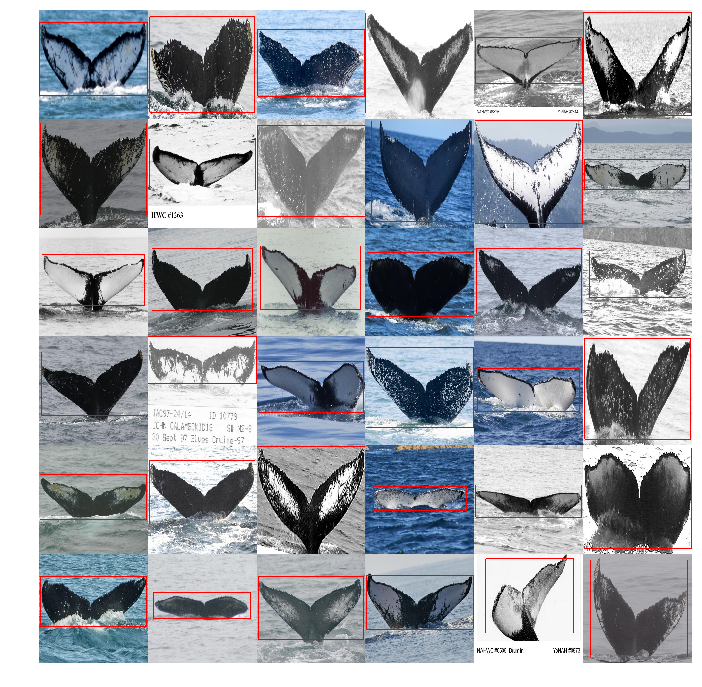

In [13]:
predicted_bboxes = ((preds + 1) / 2 * SZIN).numpy()

def draw_bbox(img, bbox, target=None, color=(255, 0, 0), thickness=2):
    y_min, x_min, y_max, x_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    if target is not None:
        y_min, x_min, y_max, x_max = map(int, target)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=thickness)
    return img

def cv_read(path):    
    im = cv2.imread(str(path), cv2.IMREAD_COLOR)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Targets are in green, predictions in red.
ims = np.stack([draw_bbox(cv_read(data.test_ds.items[i]), predicted_bboxes[i]) for i in range(36)])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

In [14]:
from concurrent.futures import ThreadPoolExecutor

In [12]:
def resize_img(path_bbox, extra_ratio=0.1):
    path, bbox = path_bbox 
    y_min_bb, x_min_bb, y_max_bb, x_max_bb = map(int, bbox)
    w_bb = x_max_bb - x_min_bb
    h_bb = y_max_bb - y_min_bb
    y_min_c = max(0,y_min_bb-extra_ratio*h_bb/2.0)
    y_max_c = min(SZIN,y_max_bb+extra_ratio*h_bb/2.0)
    x_min_c = max(0,x_min_bb-extra_ratio*w_bb/2.0)
    x_max_c = min(SZIN,x_max_bb+extra_ratio*w_bb/2.0)
    (PIL.Image.open(str(path))
        .crop([x_min_c,y_min_c,x_max_c,y_max_c])
        .resize((SZOUT,SZOUT),resample=PIL.Image.BICUBIC)
        .save((PATH/f'test-bbox-{SZOUT}'/path.name)))

In [17]:
extra_ratio=0.1
dtype='test'

def resize_img(path_bbox):
    path, bbox = path_bbox
    im_width, im_height = PIL.Image.open((PATH/f'{dtype}'/path.name)).size
    y_min_bb, x_min_bb, y_max_bb, x_max_bb = map(float, bbox)
    y_min_bb = y_min_bb * im_height / SZIN
    x_min_bb = x_min_bb * im_width / SZIN
    y_max_bb = y_max_bb * im_height / SZIN
    x_max_bb = x_max_bb * im_width / SZIN
    w_bb = x_max_bb - x_min_bb
    h_bb = y_max_bb - y_min_bb
    y_min_c = max(0,y_min_bb-extra_ratio*h_bb/2.0)
    y_max_c = min(SZIN,y_max_bb+extra_ratio*h_bb/2.0)
    x_min_c = max(0,x_min_bb-extra_ratio*w_bb/2.0)
    x_max_c = min(SZIN,x_max_bb+extra_ratio*w_bb/2.0)
    (PIL.Image.open(str(path))
        .crop([x_min_c,y_min_c,x_max_c,y_max_c])
        .resize((SZOUT,SZOUT),resample=PIL.Image.BICUBIC)
        .save((PATH/f'{dtype}-bbox-{SZOUT}'/path.name)))

In [18]:
%%time
#files = list((PATH/'train').iterdir()) + list((PATH/'test').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, zip(list((PATH/f'{dtype}').iterdir()),predicted_bboxes))

CPU times: user 4min 4s, sys: 2.64 s, total: 4min 7s
Wall time: 32 s


In [19]:
len(list((PATH/f'{dtype}-{SZIN}').iterdir())), len(list((PATH/f'{dtype}-bbox-{SZOUT}').iterdir()))

(7960, 7960)

In [16]:
%%time

data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], path=f'data/train-{SZIN}', cols=['Image'])
        .no_split()
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder(f'data/train-{SZIN}'))
        .transform(get_transforms(do_flip=False), size=SZIN, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

learn = Learner(data, FlukeDetector(arch=models.resnet50), loss_func=loss_fn)
learn.load('bounding_boxes_v0')

preds, _ = learn.get_preds(DatasetType.Test)

def resize_img(path_bbox, extra_ratio=0.1):
    path, bbox = path_bbox 
    y_min_bb, x_min_bb, y_max_bb, x_max_bb = map(int, bbox)
    w_bb = x_max_bb - x_min_bb
    h_bb = y_max_bb - y_min_bb
    y_min_c = max(0,y_min_bb-extra_ratio*h_bb/2.0)
    y_max_c = min(SZIN,y_max_bb+extra_ratio*h_bb/2.0)
    x_min_c = max(0,x_min_bb-extra_ratio*w_bb/2.0)
    x_max_c = min(SZIN,x_max_bb+extra_ratio*w_bb/2.0)
    (PIL.Image.open(str(path))
        .crop([x_min_c,y_min_c,x_max_c,y_max_c])
        .resize((SZOUT,SZOUT),resample=PIL.Image.BICUBIC)
        .save((PATH/f'train-bbox-{SZOUT}'/path.name)))

predicted_bboxes = ((preds + 1) / 2 * SZIN).numpy()

with ThreadPoolExecutor(8) as e: e.map(resize_img, zip(data.test_ds.items,predicted_bboxes))

CPU times: user 8min 32s, sys: 1min 23s, total: 9min 56s
Wall time: 4min 40s


In [17]:
len(list((PATH/f'train-{SZIN}').iterdir())), len(list((PATH/f'train-bbox-{SZOUT}').iterdir()))

(25363, 25361)

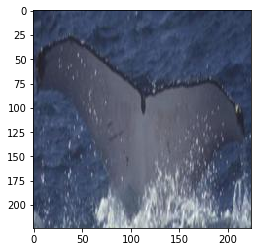

In [20]:
im = cv2.imread('data/train-bbox-224/0005c1ef8.jpg', cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [11]:
PIL.Image.open('data/train/0005c1ef8.jpg').size

(1050, 525)

In [16]:
list((PATH/f'{DTYPE}').iterdir())[1]

PosixPath('data/train/5d7b60985.jpg')

In [17]:
data.test_ds.items[1]

PosixPath('data/train-448/5d7b60985.jpg')

In [23]:
resize_img((list((PATH/f'{DTYPE}').iterdir())[1],predicted_bboxes[1]))

448
(575, 329)
(93.05387878417969, 10.431093215942383, 339.159912109375, 437.1641845703125)
(68.33644223213196, 13.388121873140335, 249.07056045532227, 561.0924243927002)
(59.29973632097244, 0, 258.1072663664818, 575)
